##### Copyright 2022 The TensorFlow Compression Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learned data compression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/data_compression">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/data_compression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This notebook shows how to do lossy data compression using neural networks and [TensorFlow Compression](https://github.com/tensorflow/compression).

Lossy compression involves making a trade-off between **rate**, the expected number of bits needed to encode a sample, and **distortion**, the expected error in the reconstruction of the sample.

The examples below use an autoencoder-like model to compress images from the MNIST dataset. The method is based on the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

More background on learned data compression can be found in [this paper](https://arxiv.org/abs/2007.03034) targeted at people familiar with classical data compression, or [this survey](https://arxiv.org/abs/2202.06533) targeted at a machine learning audience.


## Setup

Install Tensorflow Compression via `pip`.

In [2]:
# Installs the latest version of TFC compatible with the installed TF version.
!pip install tensorflow-compression~=$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d\.\d).*/\1.0/sg')


Import library dependencies.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds


## Define the trainer model.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [4]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


In [5]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original digits and their reconstructions.


In [6]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


### Compute rate and distortion.

Let's walk through this step by step, using one image from the training set. Load the MNIST dataset for training and validation:

In [7]:
training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)


And extract one image $x$:

Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


2022-06-14 01:23:41.484874: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


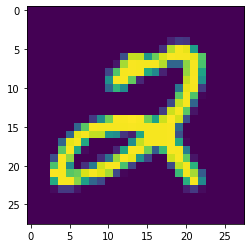

In [8]:
(x, _), = validation_dataset.take(1)

plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


To get the latent representation $y$, we need to cast it to `float32`, add a batch dimension, and pass it through the analysis transform.

In [9]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)

print("y:", y)


y: tf.Tensor(
[[-0.03596018  0.02976677  0.04654873 -0.04329199 -0.02063924  0.07961531
   0.06324859 -0.02948999 -0.08282233 -0.0033717 ]], shape=(1, 10), dtype=float32)


The latents will be quantized at test time. To model this in a differentiable way during training, we add uniform noise in the interval $(-.5, .5)$ and call the result $\tilde y$. This is the same terminology as used in the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

In [10]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

print("y_tilde:", y_tilde)


y_tilde: tf.Tensor(
[[ 0.26787832 -0.336036   -0.36863232 -0.01119763 -0.21013504  0.46640497
   0.49586838  0.08665098  0.4023888   0.15769626]], shape=(1, 10), dtype=float32)


The "prior" is a probability density that we train to model the marginal distribution of the noisy latents. For example, it could be a set of independent [logistic distributions](https://en.wikipedia.org/wiki/Logistic_distribution) with different scales for each latent dimension. `tfc.NoisyLogistic` accounts for the fact that the latents have additive noise. As the scale approaches zero, a logistic distribution approaches a dirac delta (spike), but the added noise causes the "noisy" distribution to approach the uniform distribution instead.

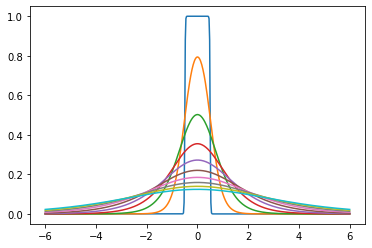

In [11]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


During training, `tfc.ContinuousBatchedEntropyModel` adds uniform noise, and uses the noise and the prior to compute a (differentiable) upper bound on the rate (the average number of bits necessary to encode the latent representation). That bound can be minimized as a loss.

In [12]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
print("y_tilde:", y_tilde)


rate: tf.Tensor([18.188126], shape=(1,), dtype=float32)
y_tilde: tf.Tensor(
[[-0.44882008  0.02260551 -0.2765367  -0.5319677   0.09461814 -0.18998818
   0.24599524 -0.44672346 -0.40305805  0.02805377]], shape=(1, 10), dtype=float32)


Lastly, the noisy latents are passed back through the synthesis transform to produce an image reconstruction $\tilde x$. Distortion is the error between original image and reconstruction. Obviously, with the transforms untrained, the reconstruction is not very useful.

distortion: tf.Tensor(0.17110279, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


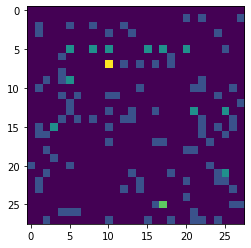

In [13]:
x_tilde = make_synthesis_transform()(y_tilde)

# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


For every batch of digits, calling the `MNISTCompressionTrainer` produces the rate and distortion as an average over that batch:


In [14]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


2022-06-14 01:23:46.909859: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14659302, shape=(), dtype=float32)


In the next section, we set up the model to do gradient descent on these two losses.

## Train the model.

We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter $\lambda$.

This loss function affects the different parts of the model differently:
- The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
- The synthesis transform is trained to minimize distortion, given the latent representation.
- The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [15]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


Next, train the model. The human annotations are not necessary here, since we just want to compress the images, so we drop them using a `map` and instead add "dummy" targets for rate and distortion.

In [16]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)


Epoch 1/15


  1/469 [..............................] - ETA: 16:37 - loss: 352.4216 - distortion_loss: 0.1248 - rate_loss: 102.9141 - distortion_pass_through_loss: 0.1248 - rate_pass_through_loss: 102.9141

 10/469 [..............................] - ETA: 2s - loss: 367.2201 - distortion_loss: 0.1323 - rate_loss: 102.6386 - distortion_pass_through_loss: 0.1323 - rate_pass_through_loss: 102.6386   

 20/469 [>.............................] - ETA: 2s - loss: 362.3097 - distortion_loss: 0.1298 - rate_loss: 102.6863 - distortion_pass_through_loss: 0.1298 - rate_pass_through_loss: 102.6863

 30/469 [>.............................] - ETA: 2s - loss: 356.6143 - distortion_loss: 0.1271 - rate_loss: 102.5111 - distortion_pass_through_loss: 0.1271 - rate_pass_through_loss: 102.5111

 40/469 [=>............................] - ETA: 2s - loss: 347.7689 - distortion_loss: 0.1226 - rate_loss: 102.5820 - distortion_pass_through_loss: 0.1226 - rate_pass_through_loss: 102.5820

 50/469 [==>...........................] - ETA: 2s - loss: 338.1442 - distortion_loss: 0.1177 - rate_loss: 102.7881 - distortion_pass_through_loss: 0.1177 - rate_pass_through_loss: 102.7881

 60/469 [==>...........................] - ETA: 2s - loss: 328.8490 - distortion_loss: 0.1130 - rate_loss: 102.8068 - distortion_pass_through_loss: 0.1130 - rate_pass_through_loss: 102.8068

 71/469 [===>..........................] - ETA: 2s - loss: 319.8019 - distortion_loss: 0.1085 - rate_loss: 102.8780 - distortion_pass_through_loss: 0.1085 - rate_pass_through_loss: 102.8780

 81/469 [====>.........................] - ETA: 2s - loss: 312.2447 - distortion_loss: 0.1046 - rate_loss: 102.9629 - distortion_pass_through_loss: 0.1046 - rate_pass_through_loss: 102.9629

 91/469 [====>.........................] - ETA: 1s - loss: 305.2532 - distortion_loss: 0.1011 - rate_loss: 103.0475 - distortion_pass_through_loss: 0.1011 - rate_pass_through_loss: 103.0475

101/469 [=====>........................] - ETA: 1s - loss: 299.0794 - distortion_loss: 0.0980 - rate_loss: 103.1456 - distortion_pass_through_loss: 0.0980 - rate_pass_through_loss: 103.1456

111/469 [======>.......................] - ETA: 1s - loss: 293.4054 - distortion_loss: 0.0951 - rate_loss: 103.2005 - distortion_pass_through_loss: 0.0951 - rate_pass_through_loss: 103.2005

121/469 [======>.......................] - ETA: 1s - loss: 288.2666 - distortion_loss: 0.0925 - rate_loss: 103.2433 - distortion_pass_through_loss: 0.0925 - rate_pass_through_loss: 103.2433

131/469 [=======>......................] - ETA: 1s - loss: 283.3691 - distortion_loss: 0.0900 - rate_loss: 103.2702 - distortion_pass_through_loss: 0.0900 - rate_pass_through_loss: 103.2702

141/469 [========>.....................] - ETA: 1s - loss: 279.0173 - distortion_loss: 0.0879 - rate_loss: 103.2905 - distortion_pass_through_loss: 0.0879 - rate_pass_through_loss: 103.2905

151/469 [========>.....................] - ETA: 1s - loss: 275.0878 - distortion_loss: 0.0859 - rate_loss: 103.2990 - distortion_pass_through_loss: 0.0859 - rate_pass_through_loss: 103.2990

161/469 [=========>....................] - ETA: 1s - loss: 271.5166 - distortion_loss: 0.0841 - rate_loss: 103.3072 - distortion_pass_through_loss: 0.0841 - rate_pass_through_loss: 103.3072

171/469 [=========>....................] - ETA: 1s - loss: 268.1621 - distortion_loss: 0.0824 - rate_loss: 103.2766 - distortion_pass_through_loss: 0.0824 - rate_pass_through_loss: 103.2766

181/469 [==========>...................] - ETA: 1s - loss: 265.0482 - distortion_loss: 0.0809 - rate_loss: 103.2526 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 103.2526

191/469 [===========>..................] - ETA: 1s - loss: 262.1545 - distortion_loss: 0.0795 - rate_loss: 103.2049 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 103.2049

201/469 [===========>..................] - ETA: 1s - loss: 259.4343 - distortion_loss: 0.0781 - rate_loss: 103.1454 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 103.1454

211/469 [============>.................] - ETA: 1s - loss: 256.7475 - distortion_loss: 0.0768 - rate_loss: 103.0832 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 103.0832

222/469 [=============>................] - ETA: 1s - loss: 254.0340 - distortion_loss: 0.0755 - rate_loss: 103.0211 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 103.0211

232/469 [=============>................] - ETA: 1s - loss: 251.7474 - distortion_loss: 0.0744 - rate_loss: 102.9481 - distortion_pass_through_loss: 0.0744 - rate_pass_through_loss: 102.9481

242/469 [==============>...............] - ETA: 1s - loss: 249.5487 - distortion_loss: 0.0733 - rate_loss: 102.8620 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 102.8620

252/469 [===============>..............] - ETA: 1s - loss: 247.5690 - distortion_loss: 0.0724 - rate_loss: 102.7734 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 102.7734

262/469 [===============>..............] - ETA: 1s - loss: 245.6710 - distortion_loss: 0.0715 - rate_loss: 102.6739 - distortion_pass_through_loss: 0.0715 - rate_pass_through_loss: 102.6739

272/469 [================>.............] - ETA: 1s - loss: 243.8335 - distortion_loss: 0.0706 - rate_loss: 102.5662 - distortion_pass_through_loss: 0.0706 - rate_pass_through_loss: 102.5662

282/469 [=================>............] - ETA: 0s - loss: 242.1015 - distortion_loss: 0.0698 - rate_loss: 102.4613 - distortion_pass_through_loss: 0.0698 - rate_pass_through_loss: 102.4613

292/469 [=================>............] - ETA: 0s - loss: 240.4341 - distortion_loss: 0.0690 - rate_loss: 102.3535 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 102.3535

302/469 [==================>...........] - ETA: 0s - loss: 238.8039 - distortion_loss: 0.0683 - rate_loss: 102.2394 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 102.2394

312/469 [==================>...........] - ETA: 0s - loss: 237.2943 - distortion_loss: 0.0676 - rate_loss: 102.1207 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 102.1207

322/469 [===================>..........] - ETA: 0s - loss: 235.8635 - distortion_loss: 0.0669 - rate_loss: 101.9916 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 101.9916

332/469 [====================>.........] - ETA: 0s - loss: 234.4645 - distortion_loss: 0.0663 - rate_loss: 101.8575 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 101.8575

342/469 [====================>.........] - ETA: 0s - loss: 233.1103 - distortion_loss: 0.0657 - rate_loss: 101.7304 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 101.7304

352/469 [=====================>........] - ETA: 0s - loss: 231.8393 - distortion_loss: 0.0651 - rate_loss: 101.5901 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 101.5901

362/469 [======================>.......] - ETA: 0s - loss: 230.6115 - distortion_loss: 0.0646 - rate_loss: 101.4504 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 101.4504

372/469 [======================>.......] - ETA: 0s - loss: 229.4128 - distortion_loss: 0.0641 - rate_loss: 101.3048 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 101.3048

382/469 [=======================>......] - ETA: 0s - loss: 228.2664 - distortion_loss: 0.0636 - rate_loss: 101.1526 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 101.1526

392/469 [========================>.....] - ETA: 0s - loss: 227.1370 - distortion_loss: 0.0631 - rate_loss: 101.0055 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 101.0055

402/469 [========================>.....] - ETA: 0s - loss: 226.0173 - distortion_loss: 0.0626 - rate_loss: 100.8560 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 100.8560

412/469 [=========================>....] - ETA: 0s - loss: 224.9538 - distortion_loss: 0.0621 - rate_loss: 100.7117 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 100.7117

422/469 [=========================>....] - ETA: 0s - loss: 223.9021 - distortion_loss: 0.0617 - rate_loss: 100.5564 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 100.5564

432/469 [==========================>...] - ETA: 0s - loss: 222.9299 - distortion_loss: 0.0613 - rate_loss: 100.4042 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 100.4042

442/469 [===========================>..] - ETA: 0s - loss: 221.9746 - distortion_loss: 0.0609 - rate_loss: 100.2477 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 100.2477

452/469 [===========================>..] - ETA: 0s - loss: 221.0449 - distortion_loss: 0.0605 - rate_loss: 100.0904 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 100.0904

462/469 [============================>.] - ETA: 0s - loss: 220.1499 - distortion_loss: 0.0601 - rate_loss: 99.9370 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 99.9370  

469/469 [==============================] - 5s 7ms/step - loss: 219.5430 - distortion_loss: 0.0599 - rate_loss: 99.8240 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 99.8193 - val_loss: 176.7449 - val_distortion_loss: 0.0422 - val_rate_loss: 92.3387 - val_distortion_pass_through_loss: 0.0422 - val_rate_pass_through_loss: 92.3541


Epoch 2/15


  1/469 [..............................] - ETA: 4s - loss: 171.3944 - distortion_loss: 0.0399 - rate_loss: 91.4999 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 91.4999

 12/469 [..............................] - ETA: 2s - loss: 178.0358 - distortion_loss: 0.0428 - rate_loss: 92.3477 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 92.3477

 23/469 [>.............................] - ETA: 2s - loss: 178.0059 - distortion_loss: 0.0430 - rate_loss: 92.0429 - distortion_pass_through_loss: 0.0430 - rate_pass_through_loss: 92.0429

 34/469 [=>............................] - ETA: 2s - loss: 177.8215 - distortion_loss: 0.0430 - rate_loss: 91.8024 - distortion_pass_through_loss: 0.0430 - rate_pass_through_loss: 91.8024

 45/469 [=>............................] - ETA: 2s - loss: 177.1864 - distortion_loss: 0.0428 - rate_loss: 91.5212 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 91.5212

 56/469 [==>...........................] - ETA: 1s - loss: 176.9107 - distortion_loss: 0.0428 - rate_loss: 91.3671 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 91.3671

 67/469 [===>..........................] - ETA: 1s - loss: 176.8313 - distortion_loss: 0.0428 - rate_loss: 91.1933 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 91.1933

 78/469 [===>..........................] - ETA: 1s - loss: 176.3313 - distortion_loss: 0.0427 - rate_loss: 90.9712 - distortion_pass_through_loss: 0.0427 - rate_pass_through_loss: 90.9712

 89/469 [====>.........................] - ETA: 1s - loss: 175.8674 - distortion_loss: 0.0425 - rate_loss: 90.7702 - distortion_pass_through_loss: 0.0425 - rate_pass_through_loss: 90.7702

100/469 [=====>........................] - ETA: 1s - loss: 175.4567 - distortion_loss: 0.0424 - rate_loss: 90.5580 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 90.5580

111/469 [======>.......................] - ETA: 1s - loss: 175.0477 - distortion_loss: 0.0424 - rate_loss: 90.3422 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 90.3422

122/469 [======>.......................] - ETA: 1s - loss: 174.6952 - distortion_loss: 0.0423 - rate_loss: 90.1380 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.1380

133/469 [=======>......................] - ETA: 1s - loss: 174.3346 - distortion_loss: 0.0422 - rate_loss: 89.8896 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.8896

144/469 [========>.....................] - ETA: 1s - loss: 174.1305 - distortion_loss: 0.0422 - rate_loss: 89.6613 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.6613

155/469 [========>.....................] - ETA: 1s - loss: 173.8842 - distortion_loss: 0.0422 - rate_loss: 89.4901 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.4901

166/469 [=========>....................] - ETA: 1s - loss: 173.6375 - distortion_loss: 0.0422 - rate_loss: 89.2806 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 89.2806

177/469 [==========>...................] - ETA: 1s - loss: 173.3710 - distortion_loss: 0.0421 - rate_loss: 89.1024 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 89.1024

188/469 [===========>..................] - ETA: 1s - loss: 173.0710 - distortion_loss: 0.0421 - rate_loss: 88.9142 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 88.9142

199/469 [===========>..................] - ETA: 1s - loss: 172.7986 - distortion_loss: 0.0420 - rate_loss: 88.7298 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 88.7298

210/469 [============>.................] - ETA: 1s - loss: 172.4331 - distortion_loss: 0.0420 - rate_loss: 88.5287 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 88.5287

221/469 [=============>................] - ETA: 1s - loss: 172.1302 - distortion_loss: 0.0419 - rate_loss: 88.3438 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 88.3438

232/469 [=============>................] - ETA: 1s - loss: 171.8498 - distortion_loss: 0.0418 - rate_loss: 88.1544 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 88.1544

243/469 [==============>...............] - ETA: 1s - loss: 171.5451 - distortion_loss: 0.0418 - rate_loss: 87.9479 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 87.9479

254/469 [===============>..............] - ETA: 1s - loss: 171.3504 - distortion_loss: 0.0418 - rate_loss: 87.7727 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 87.7727

265/469 [===============>..............] - ETA: 0s - loss: 171.0713 - distortion_loss: 0.0417 - rate_loss: 87.5939 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 87.5939

276/469 [================>.............] - ETA: 0s - loss: 170.8377 - distortion_loss: 0.0417 - rate_loss: 87.4053 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 87.4053

287/469 [=================>............] - ETA: 0s - loss: 170.6244 - distortion_loss: 0.0417 - rate_loss: 87.2281 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 87.2281

298/469 [==================>...........] - ETA: 0s - loss: 170.3171 - distortion_loss: 0.0416 - rate_loss: 87.0456 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 87.0456

309/469 [==================>...........] - ETA: 0s - loss: 170.0759 - distortion_loss: 0.0416 - rate_loss: 86.8642 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 86.8642

320/469 [===================>..........] - ETA: 0s - loss: 169.8107 - distortion_loss: 0.0416 - rate_loss: 86.6901 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 86.6901

331/469 [====================>.........] - ETA: 0s - loss: 169.5938 - distortion_loss: 0.0415 - rate_loss: 86.5057 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 86.5057

342/469 [====================>.........] - ETA: 0s - loss: 169.3748 - distortion_loss: 0.0415 - rate_loss: 86.3285 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 86.3285

353/469 [=====================>........] - ETA: 0s - loss: 169.1532 - distortion_loss: 0.0415 - rate_loss: 86.1498 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 86.1498

364/469 [======================>.......] - ETA: 0s - loss: 168.9516 - distortion_loss: 0.0415 - rate_loss: 85.9670 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 85.9670

375/469 [======================>.......] - ETA: 0s - loss: 168.7370 - distortion_loss: 0.0415 - rate_loss: 85.7946 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 85.7946

386/469 [=======================>......] - ETA: 0s - loss: 168.4969 - distortion_loss: 0.0414 - rate_loss: 85.6133 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 85.6133

397/469 [========================>.....] - ETA: 0s - loss: 168.2702 - distortion_loss: 0.0414 - rate_loss: 85.4407 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 85.4407

408/469 [=========================>....] - ETA: 0s - loss: 167.9949 - distortion_loss: 0.0414 - rate_loss: 85.2567 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 85.2567

419/469 [=========================>....] - ETA: 0s - loss: 167.7851 - distortion_loss: 0.0413 - rate_loss: 85.0856 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 85.0856

430/469 [==========================>...] - ETA: 0s - loss: 167.5746 - distortion_loss: 0.0413 - rate_loss: 84.9179 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 84.9179

441/469 [===========================>..] - ETA: 0s - loss: 167.3647 - distortion_loss: 0.0413 - rate_loss: 84.7409 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 84.7409

452/469 [===========================>..] - ETA: 0s - loss: 167.1468 - distortion_loss: 0.0413 - rate_loss: 84.5700 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 84.5700

463/469 [============================>.] - ETA: 0s - loss: 166.9421 - distortion_loss: 0.0413 - rate_loss: 84.3998 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 84.3998

469/469 [==============================] - 2s 5ms/step - loss: 166.8285 - distortion_loss: 0.0413 - rate_loss: 84.3090 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 84.3050 - val_loss: 157.4475 - val_distortion_loss: 0.0403 - val_rate_loss: 76.8713 - val_distortion_pass_through_loss: 0.0403 - val_rate_pass_through_loss: 76.8923


Epoch 3/15


  1/469 [..............................] - ETA: 3s - loss: 152.4910 - distortion_loss: 0.0381 - rate_loss: 76.3831 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 76.3831

 12/469 [..............................] - ETA: 2s - loss: 158.4443 - distortion_loss: 0.0407 - rate_loss: 77.0797 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 77.0797

 23/469 [>.............................] - ETA: 2s - loss: 158.6248 - distortion_loss: 0.0410 - rate_loss: 76.6772 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 76.6772

 34/469 [=>............................] - ETA: 2s - loss: 158.4159 - distortion_loss: 0.0409 - rate_loss: 76.6220 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 76.6220

 45/469 [=>............................] - ETA: 2s - loss: 157.8237 - distortion_loss: 0.0407 - rate_loss: 76.4433 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 76.4433

 56/469 [==>...........................] - ETA: 2s - loss: 157.6049 - distortion_loss: 0.0406 - rate_loss: 76.3816 - distortion_pass_through_loss: 0.0406 - rate_pass_through_loss: 76.3816

 67/469 [===>..........................] - ETA: 1s - loss: 157.5242 - distortion_loss: 0.0406 - rate_loss: 76.2630 - distortion_pass_through_loss: 0.0406 - rate_pass_through_loss: 76.2630

 78/469 [===>..........................] - ETA: 1s - loss: 157.1932 - distortion_loss: 0.0405 - rate_loss: 76.1205 - distortion_pass_through_loss: 0.0405 - rate_pass_through_loss: 76.1205

 89/469 [====>.........................] - ETA: 1s - loss: 156.9470 - distortion_loss: 0.0405 - rate_loss: 75.9864 - distortion_pass_through_loss: 0.0405 - rate_pass_through_loss: 75.9864

100/469 [=====>........................] - ETA: 1s - loss: 156.6747 - distortion_loss: 0.0404 - rate_loss: 75.8347 - distortion_pass_through_loss: 0.0404 - rate_pass_through_loss: 75.8347

111/469 [======>.......................] - ETA: 1s - loss: 156.4277 - distortion_loss: 0.0404 - rate_loss: 75.7003 - distortion_pass_through_loss: 0.0404 - rate_pass_through_loss: 75.7003

122/469 [======>.......................] - ETA: 1s - loss: 156.2331 - distortion_loss: 0.0403 - rate_loss: 75.5446 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 75.5446

132/469 [=======>......................] - ETA: 1s - loss: 155.9424 - distortion_loss: 0.0403 - rate_loss: 75.3927 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 75.3927

142/469 [========>.....................] - ETA: 1s - loss: 155.7613 - distortion_loss: 0.0403 - rate_loss: 75.2558 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 75.2558

152/469 [========>.....................] - ETA: 1s - loss: 155.6308 - distortion_loss: 0.0402 - rate_loss: 75.1522 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.1522

163/469 [=========>....................] - ETA: 1s - loss: 155.5143 - distortion_loss: 0.0402 - rate_loss: 75.0206 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 75.0206

174/469 [==========>...................] - ETA: 1s - loss: 155.4060 - distortion_loss: 0.0403 - rate_loss: 74.8900 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 74.8900

184/469 [==========>...................] - ETA: 1s - loss: 155.3024 - distortion_loss: 0.0403 - rate_loss: 74.7692 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 74.7692

194/469 [===========>..................] - ETA: 1s - loss: 155.1859 - distortion_loss: 0.0403 - rate_loss: 74.6627 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 74.6627

204/469 [============>.................] - ETA: 1s - loss: 155.0214 - distortion_loss: 0.0402 - rate_loss: 74.5424 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 74.5424

214/469 [============>.................] - ETA: 1s - loss: 154.8631 - distortion_loss: 0.0402 - rate_loss: 74.4123 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 74.4123

224/469 [=============>................] - ETA: 1s - loss: 154.7128 - distortion_loss: 0.0402 - rate_loss: 74.2995 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 74.2995

234/469 [=============>................] - ETA: 1s - loss: 154.5972 - distortion_loss: 0.0402 - rate_loss: 74.1833 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 74.1833

244/469 [==============>...............] - ETA: 1s - loss: 154.4340 - distortion_loss: 0.0402 - rate_loss: 74.0583 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 74.0583

254/469 [===============>..............] - ETA: 1s - loss: 154.3729 - distortion_loss: 0.0402 - rate_loss: 73.9384 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 73.9384

265/469 [===============>..............] - ETA: 1s - loss: 154.2410 - distortion_loss: 0.0402 - rate_loss: 73.8056 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 73.8056

276/469 [================>.............] - ETA: 0s - loss: 154.1359 - distortion_loss: 0.0402 - rate_loss: 73.6846 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 73.6846

287/469 [=================>............] - ETA: 0s - loss: 154.0158 - distortion_loss: 0.0402 - rate_loss: 73.5670 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 73.5670

297/469 [=================>............] - ETA: 0s - loss: 153.8481 - distortion_loss: 0.0402 - rate_loss: 73.4439 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 73.4439

307/469 [==================>...........] - ETA: 0s - loss: 153.7570 - distortion_loss: 0.0402 - rate_loss: 73.3220 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 73.3220

317/469 [===================>..........] - ETA: 0s - loss: 153.6596 - distortion_loss: 0.0402 - rate_loss: 73.2091 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 73.2091

327/469 [===================>..........] - ETA: 0s - loss: 153.5312 - distortion_loss: 0.0402 - rate_loss: 73.0981 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 73.0981

337/469 [====================>.........] - ETA: 0s - loss: 153.4251 - distortion_loss: 0.0402 - rate_loss: 72.9924 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.9924

347/469 [=====================>........] - ETA: 0s - loss: 153.3052 - distortion_loss: 0.0402 - rate_loss: 72.8837 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.8837

358/469 [=====================>........] - ETA: 0s - loss: 153.1875 - distortion_loss: 0.0402 - rate_loss: 72.7647 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.7647

369/469 [======================>.......] - ETA: 0s - loss: 153.1028 - distortion_loss: 0.0402 - rate_loss: 72.6537 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.6537

379/469 [=======================>......] - ETA: 0s - loss: 152.9675 - distortion_loss: 0.0402 - rate_loss: 72.5462 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.5462

389/469 [=======================>......] - ETA: 0s - loss: 152.8597 - distortion_loss: 0.0402 - rate_loss: 72.4410 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.4410

399/469 [========================>.....] - ETA: 0s - loss: 152.7210 - distortion_loss: 0.0402 - rate_loss: 72.3328 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.3328

410/469 [=========================>....] - ETA: 0s - loss: 152.5789 - distortion_loss: 0.0402 - rate_loss: 72.2279 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.2279

421/469 [=========================>....] - ETA: 0s - loss: 152.4631 - distortion_loss: 0.0402 - rate_loss: 72.1129 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.1129

432/469 [==========================>...] - ETA: 0s - loss: 152.3580 - distortion_loss: 0.0402 - rate_loss: 72.0060 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 72.0060

443/469 [===========================>..] - ETA: 0s - loss: 152.2374 - distortion_loss: 0.0402 - rate_loss: 71.8907 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 71.8907

453/469 [===========================>..] - ETA: 0s - loss: 152.1265 - distortion_loss: 0.0402 - rate_loss: 71.7916 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 71.7916

464/469 [============================>.] - ETA: 0s - loss: 152.0172 - distortion_loss: 0.0402 - rate_loss: 71.6825 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 71.6825

469/469 [==============================] - 2s 5ms/step - loss: 151.9537 - distortion_loss: 0.0402 - rate_loss: 71.6350 - distortion_pass_through_loss: 0.0402 - rate_pass_through_loss: 71.6317 - val_loss: 145.8981 - val_distortion_loss: 0.0409 - val_rate_loss: 64.1213 - val_distortion_pass_through_loss: 0.0409 - val_rate_pass_through_loss: 64.1344


Epoch 4/15


  1/469 [..............................] - ETA: 3s - loss: 141.6594 - distortion_loss: 0.0381 - rate_loss: 65.4543 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 65.4543

 12/469 [..............................] - ETA: 2s - loss: 146.8077 - distortion_loss: 0.0399 - rate_loss: 66.9146 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.9146

 23/469 [>.............................] - ETA: 2s - loss: 146.8470 - distortion_loss: 0.0400 - rate_loss: 66.9152 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.9152

 34/469 [=>............................] - ETA: 2s - loss: 146.8802 - distortion_loss: 0.0400 - rate_loss: 66.8676 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.8676

 45/469 [=>............................] - ETA: 2s - loss: 146.4182 - distortion_loss: 0.0399 - rate_loss: 66.6384 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.6384

 56/469 [==>...........................] - ETA: 1s - loss: 146.5149 - distortion_loss: 0.0400 - rate_loss: 66.5992 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.5992

 67/469 [===>..........................] - ETA: 1s - loss: 146.5829 - distortion_loss: 0.0400 - rate_loss: 66.5293 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 66.5293

 78/469 [===>..........................] - ETA: 1s - loss: 146.2804 - distortion_loss: 0.0399 - rate_loss: 66.4305 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.4305

 88/469 [====>.........................] - ETA: 1s - loss: 146.0789 - distortion_loss: 0.0399 - rate_loss: 66.2972 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.2972

 99/469 [=====>........................] - ETA: 1s - loss: 145.9040 - distortion_loss: 0.0399 - rate_loss: 66.1569 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.1569

110/469 [======>.......................] - ETA: 1s - loss: 145.7444 - distortion_loss: 0.0398 - rate_loss: 66.0610 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.0610

121/469 [======>.......................] - ETA: 1s - loss: 145.5934 - distortion_loss: 0.0398 - rate_loss: 65.9763 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.9763

132/469 [=======>......................] - ETA: 1s - loss: 145.3518 - distortion_loss: 0.0398 - rate_loss: 65.8387 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.8387

143/469 [========>.....................] - ETA: 1s - loss: 145.2210 - distortion_loss: 0.0397 - rate_loss: 65.7588 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.7588

153/469 [========>.....................] - ETA: 1s - loss: 145.1552 - distortion_loss: 0.0397 - rate_loss: 65.7175 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.7175

164/469 [=========>....................] - ETA: 1s - loss: 145.1212 - distortion_loss: 0.0397 - rate_loss: 65.6305 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.6305

174/469 [==========>...................] - ETA: 1s - loss: 145.0467 - distortion_loss: 0.0397 - rate_loss: 65.5510 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.5510

185/469 [==========>...................] - ETA: 1s - loss: 145.0336 - distortion_loss: 0.0398 - rate_loss: 65.4799 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.4799

196/469 [===========>..................] - ETA: 1s - loss: 144.9924 - distortion_loss: 0.0398 - rate_loss: 65.4159 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.4159

207/469 [============>.................] - ETA: 1s - loss: 144.8939 - distortion_loss: 0.0398 - rate_loss: 65.3193 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.3193

218/469 [============>.................] - ETA: 1s - loss: 144.7211 - distortion_loss: 0.0398 - rate_loss: 65.2110 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.2110

229/469 [=============>................] - ETA: 1s - loss: 144.6017 - distortion_loss: 0.0397 - rate_loss: 65.1396 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.1396

240/469 [==============>...............] - ETA: 1s - loss: 144.5208 - distortion_loss: 0.0397 - rate_loss: 65.0646 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.0646

251/469 [===============>..............] - ETA: 1s - loss: 144.4467 - distortion_loss: 0.0397 - rate_loss: 64.9760 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.9760

262/469 [===============>..............] - ETA: 1s - loss: 144.3338 - distortion_loss: 0.0397 - rate_loss: 64.8993 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.8993

273/469 [================>.............] - ETA: 0s - loss: 144.2250 - distortion_loss: 0.0397 - rate_loss: 64.8284 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.8284

284/469 [=================>............] - ETA: 0s - loss: 144.1619 - distortion_loss: 0.0397 - rate_loss: 64.7611 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.7611

294/469 [=================>............] - ETA: 0s - loss: 144.0461 - distortion_loss: 0.0397 - rate_loss: 64.6822 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.6822

305/469 [==================>...........] - ETA: 0s - loss: 143.9554 - distortion_loss: 0.0397 - rate_loss: 64.6121 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.6121

316/469 [===================>..........] - ETA: 0s - loss: 143.9039 - distortion_loss: 0.0397 - rate_loss: 64.5328 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.5328

327/469 [===================>..........] - ETA: 0s - loss: 143.8447 - distortion_loss: 0.0397 - rate_loss: 64.4547 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.4547

338/469 [====================>.........] - ETA: 0s - loss: 143.7831 - distortion_loss: 0.0397 - rate_loss: 64.3751 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.3751

349/469 [=====================>........] - ETA: 0s - loss: 143.7207 - distortion_loss: 0.0397 - rate_loss: 64.3038 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.3038

359/469 [=====================>........] - ETA: 0s - loss: 143.6561 - distortion_loss: 0.0397 - rate_loss: 64.2388 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.2388

370/469 [======================>.......] - ETA: 0s - loss: 143.6112 - distortion_loss: 0.0397 - rate_loss: 64.1690 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.1690

381/469 [=======================>......] - ETA: 0s - loss: 143.5247 - distortion_loss: 0.0397 - rate_loss: 64.1009 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.1009

392/469 [========================>.....] - ETA: 0s - loss: 143.4481 - distortion_loss: 0.0397 - rate_loss: 64.0235 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 64.0235

403/469 [========================>.....] - ETA: 0s - loss: 143.3189 - distortion_loss: 0.0397 - rate_loss: 63.9474 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.9474

414/469 [=========================>....] - ETA: 0s - loss: 143.2560 - distortion_loss: 0.0397 - rate_loss: 63.8838 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.8838

425/469 [==========================>...] - ETA: 0s - loss: 143.1500 - distortion_loss: 0.0397 - rate_loss: 63.8226 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.8226

436/469 [==========================>...] - ETA: 0s - loss: 143.0850 - distortion_loss: 0.0397 - rate_loss: 63.7522 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.7522

447/469 [===========================>..] - ETA: 0s - loss: 143.0293 - distortion_loss: 0.0397 - rate_loss: 63.6837 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.6837

458/469 [============================>.] - ETA: 0s - loss: 142.9538 - distortion_loss: 0.0397 - rate_loss: 63.6073 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.6073

469/469 [==============================] - ETA: 0s - loss: 142.8845 - distortion_loss: 0.0397 - rate_loss: 63.5405 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.5382

469/469 [==============================] - 2s 5ms/step - loss: 142.8845 - distortion_loss: 0.0397 - rate_loss: 63.5405 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 63.5382 - val_loss: 136.7687 - val_distortion_loss: 0.0403 - val_rate_loss: 56.0768 - val_distortion_pass_through_loss: 0.0403 - val_rate_pass_through_loss: 56.0828


Epoch 5/15


  1/469 [..............................] - ETA: 3s - loss: 133.4384 - distortion_loss: 0.0366 - rate_loss: 60.2637 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 60.2637

 11/469 [..............................] - ETA: 2s - loss: 139.7148 - distortion_loss: 0.0394 - rate_loss: 60.8861 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.8861

 22/469 [>.............................] - ETA: 2s - loss: 139.9719 - distortion_loss: 0.0396 - rate_loss: 60.8409 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.8409

 33/469 [=>............................] - ETA: 2s - loss: 139.6326 - distortion_loss: 0.0395 - rate_loss: 60.6029 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.6029

 43/469 [=>............................] - ETA: 2s - loss: 139.3214 - distortion_loss: 0.0394 - rate_loss: 60.5838 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.5838

 54/469 [==>...........................] - ETA: 2s - loss: 139.2884 - distortion_loss: 0.0394 - rate_loss: 60.5376 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.5376

 65/469 [===>..........................] - ETA: 1s - loss: 139.3958 - distortion_loss: 0.0395 - rate_loss: 60.4713 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.4713

 76/469 [===>..........................] - ETA: 1s - loss: 139.2475 - distortion_loss: 0.0394 - rate_loss: 60.4364 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.4364

 87/469 [====>.........................] - ETA: 1s - loss: 139.2188 - distortion_loss: 0.0395 - rate_loss: 60.2875 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.2875

 98/469 [=====>........................] - ETA: 1s - loss: 138.9789 - distortion_loss: 0.0394 - rate_loss: 60.2073 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 60.2073

109/469 [=====>........................] - ETA: 1s - loss: 138.8826 - distortion_loss: 0.0393 - rate_loss: 60.1887 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 60.1887

120/469 [======>.......................] - ETA: 1s - loss: 138.7682 - distortion_loss: 0.0393 - rate_loss: 60.1149 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 60.1149

131/469 [=======>......................] - ETA: 1s - loss: 138.5911 - distortion_loss: 0.0393 - rate_loss: 60.0257 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 60.0257

142/469 [========>.....................] - ETA: 1s - loss: 138.5015 - distortion_loss: 0.0393 - rate_loss: 59.9652 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.9652

153/469 [========>.....................] - ETA: 1s - loss: 138.4491 - distortion_loss: 0.0393 - rate_loss: 59.9115 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.9115

164/469 [=========>....................] - ETA: 1s - loss: 138.4266 - distortion_loss: 0.0393 - rate_loss: 59.8599 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.8599

174/469 [==========>...................] - ETA: 1s - loss: 138.3781 - distortion_loss: 0.0393 - rate_loss: 59.8170 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.8170

185/469 [==========>...................] - ETA: 1s - loss: 138.3991 - distortion_loss: 0.0393 - rate_loss: 59.7626 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.7626

196/469 [===========>..................] - ETA: 1s - loss: 138.4407 - distortion_loss: 0.0394 - rate_loss: 59.7122 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.7122

207/469 [============>.................] - ETA: 1s - loss: 138.3725 - distortion_loss: 0.0394 - rate_loss: 59.6592 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.6592

218/469 [============>.................] - ETA: 1s - loss: 138.2142 - distortion_loss: 0.0393 - rate_loss: 59.5969 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5969

229/469 [=============>................] - ETA: 1s - loss: 138.1011 - distortion_loss: 0.0393 - rate_loss: 59.5393 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5393

240/469 [==============>...............] - ETA: 1s - loss: 138.0995 - distortion_loss: 0.0393 - rate_loss: 59.5046 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5046

251/469 [===============>..............] - ETA: 1s - loss: 138.0708 - distortion_loss: 0.0393 - rate_loss: 59.4380 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4380

262/469 [===============>..............] - ETA: 1s - loss: 138.0106 - distortion_loss: 0.0393 - rate_loss: 59.3997 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3997

273/469 [================>.............] - ETA: 0s - loss: 137.9561 - distortion_loss: 0.0393 - rate_loss: 59.3544 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3544

283/469 [=================>............] - ETA: 0s - loss: 137.9458 - distortion_loss: 0.0393 - rate_loss: 59.3317 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3317

294/469 [=================>............] - ETA: 0s - loss: 137.8303 - distortion_loss: 0.0393 - rate_loss: 59.2745 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2745

305/469 [==================>...........] - ETA: 0s - loss: 137.7495 - distortion_loss: 0.0393 - rate_loss: 59.2236 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2236

316/469 [===================>..........] - ETA: 0s - loss: 137.6998 - distortion_loss: 0.0393 - rate_loss: 59.1840 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1840

327/469 [===================>..........] - ETA: 0s - loss: 137.6457 - distortion_loss: 0.0393 - rate_loss: 59.1428 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1428

338/469 [====================>.........] - ETA: 0s - loss: 137.5964 - distortion_loss: 0.0393 - rate_loss: 59.0960 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0960

349/469 [=====================>........] - ETA: 0s - loss: 137.5715 - distortion_loss: 0.0393 - rate_loss: 59.0431 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0431

360/469 [======================>.......] - ETA: 0s - loss: 137.5263 - distortion_loss: 0.0393 - rate_loss: 59.0028 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0028

371/469 [======================>.......] - ETA: 0s - loss: 137.5125 - distortion_loss: 0.0393 - rate_loss: 58.9586 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9586

382/469 [=======================>......] - ETA: 0s - loss: 137.4441 - distortion_loss: 0.0393 - rate_loss: 58.9135 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9135

393/469 [========================>.....] - ETA: 0s - loss: 137.3893 - distortion_loss: 0.0393 - rate_loss: 58.8694 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8694

404/469 [========================>.....] - ETA: 0s - loss: 137.2790 - distortion_loss: 0.0392 - rate_loss: 58.8265 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.8265

415/469 [=========================>....] - ETA: 0s - loss: 137.2391 - distortion_loss: 0.0392 - rate_loss: 58.7911 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7911

426/469 [==========================>...] - ETA: 0s - loss: 137.1708 - distortion_loss: 0.0392 - rate_loss: 58.7510 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7510

437/469 [==========================>...] - ETA: 0s - loss: 137.1199 - distortion_loss: 0.0392 - rate_loss: 58.7103 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.7103

448/469 [===========================>..] - ETA: 0s - loss: 137.0810 - distortion_loss: 0.0392 - rate_loss: 58.6723 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6723

459/469 [============================>.] - ETA: 0s - loss: 137.0400 - distortion_loss: 0.0392 - rate_loss: 58.6217 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.6217

469/469 [==============================] - 2s 5ms/step - loss: 137.0008 - distortion_loss: 0.0392 - rate_loss: 58.5897 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 58.5873 - val_loss: 131.0233 - val_distortion_loss: 0.0415 - val_rate_loss: 48.0806 - val_distortion_pass_through_loss: 0.0415 - val_rate_pass_through_loss: 48.0994


Epoch 6/15


  1/469 [..............................] - ETA: 4s - loss: 128.7207 - distortion_loss: 0.0369 - rate_loss: 54.9926 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 54.9926

 12/469 [..............................] - ETA: 2s - loss: 135.5687 - distortion_loss: 0.0395 - rate_loss: 56.5674 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 56.5674

 23/469 [>.............................] - ETA: 2s - loss: 135.3190 - distortion_loss: 0.0393 - rate_loss: 56.7066 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.7066

 34/469 [=>............................] - ETA: 2s - loss: 135.3057 - distortion_loss: 0.0393 - rate_loss: 56.7921 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.7921

 45/469 [=>............................] - ETA: 2s - loss: 134.7890 - distortion_loss: 0.0391 - rate_loss: 56.6765 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6765

 56/469 [==>...........................] - ETA: 2s - loss: 134.7515 - distortion_loss: 0.0391 - rate_loss: 56.6333 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6333

 67/469 [===>..........................] - ETA: 1s - loss: 134.8220 - distortion_loss: 0.0391 - rate_loss: 56.6574 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6574

 78/469 [===>..........................] - ETA: 1s - loss: 134.5431 - distortion_loss: 0.0390 - rate_loss: 56.5758 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.5758

 89/469 [====>.........................] - ETA: 1s - loss: 134.4056 - distortion_loss: 0.0389 - rate_loss: 56.5355 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.5355

100/469 [=====>........................] - ETA: 1s - loss: 134.2508 - distortion_loss: 0.0389 - rate_loss: 56.4900 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.4900

111/469 [======>.......................] - ETA: 1s - loss: 134.1607 - distortion_loss: 0.0389 - rate_loss: 56.4570 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 56.4570

122/469 [======>.......................] - ETA: 1s - loss: 134.0612 - distortion_loss: 0.0388 - rate_loss: 56.4406 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.4406

133/469 [=======>......................] - ETA: 1s - loss: 133.8273 - distortion_loss: 0.0387 - rate_loss: 56.3647 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 56.3647

144/469 [========>.....................] - ETA: 1s - loss: 133.7549 - distortion_loss: 0.0387 - rate_loss: 56.3051 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 56.3051

155/469 [========>.....................] - ETA: 1s - loss: 133.7822 - distortion_loss: 0.0387 - rate_loss: 56.2823 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 56.2823

166/469 [=========>....................] - ETA: 1s - loss: 133.7814 - distortion_loss: 0.0388 - rate_loss: 56.2349 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.2349

177/469 [==========>...................] - ETA: 1s - loss: 133.8134 - distortion_loss: 0.0388 - rate_loss: 56.2125 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.2125

188/469 [===========>..................] - ETA: 1s - loss: 133.7905 - distortion_loss: 0.0388 - rate_loss: 56.1697 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.1697

199/469 [===========>..................] - ETA: 1s - loss: 133.7961 - distortion_loss: 0.0388 - rate_loss: 56.1451 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.1451

210/469 [============>.................] - ETA: 1s - loss: 133.7307 - distortion_loss: 0.0388 - rate_loss: 56.1117 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.1117

221/469 [=============>................] - ETA: 1s - loss: 133.6490 - distortion_loss: 0.0388 - rate_loss: 56.0763 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.0763

232/469 [=============>................] - ETA: 1s - loss: 133.5907 - distortion_loss: 0.0388 - rate_loss: 56.0455 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.0455

243/469 [==============>...............] - ETA: 1s - loss: 133.5366 - distortion_loss: 0.0388 - rate_loss: 56.0129 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 56.0129

254/469 [===============>..............] - ETA: 1s - loss: 133.5816 - distortion_loss: 0.0388 - rate_loss: 55.9972 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.9972

265/469 [===============>..............] - ETA: 0s - loss: 133.5159 - distortion_loss: 0.0388 - rate_loss: 55.9656 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.9656

276/469 [================>.............] - ETA: 0s - loss: 133.4734 - distortion_loss: 0.0388 - rate_loss: 55.9324 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.9324

287/469 [=================>............] - ETA: 0s - loss: 133.4482 - distortion_loss: 0.0388 - rate_loss: 55.8996 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.8996

298/469 [==================>...........] - ETA: 0s - loss: 133.3466 - distortion_loss: 0.0387 - rate_loss: 55.8673 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 55.8673

309/469 [==================>...........] - ETA: 0s - loss: 133.3586 - distortion_loss: 0.0388 - rate_loss: 55.8455 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.8455

320/469 [===================>..........] - ETA: 0s - loss: 133.3391 - distortion_loss: 0.0388 - rate_loss: 55.8007 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.8007

331/469 [====================>.........] - ETA: 0s - loss: 133.3071 - distortion_loss: 0.0388 - rate_loss: 55.7796 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.7796

342/469 [====================>.........] - ETA: 0s - loss: 133.2775 - distortion_loss: 0.0388 - rate_loss: 55.7528 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.7528

353/469 [=====================>........] - ETA: 0s - loss: 133.2791 - distortion_loss: 0.0388 - rate_loss: 55.7246 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.7246

364/469 [======================>.......] - ETA: 0s - loss: 133.2702 - distortion_loss: 0.0388 - rate_loss: 55.7050 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.7050

375/469 [======================>.......] - ETA: 0s - loss: 133.2298 - distortion_loss: 0.0388 - rate_loss: 55.6690 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.6690

386/469 [=======================>......] - ETA: 0s - loss: 133.1827 - distortion_loss: 0.0388 - rate_loss: 55.6489 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.6489

397/469 [========================>.....] - ETA: 0s - loss: 133.1509 - distortion_loss: 0.0388 - rate_loss: 55.6231 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.6231

408/469 [=========================>....] - ETA: 0s - loss: 133.0763 - distortion_loss: 0.0387 - rate_loss: 55.5869 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 55.5869

418/469 [=========================>....] - ETA: 0s - loss: 133.0718 - distortion_loss: 0.0388 - rate_loss: 55.5647 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.5647

428/469 [==========================>...] - ETA: 0s - loss: 133.0592 - distortion_loss: 0.0388 - rate_loss: 55.5447 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.5447

439/469 [===========================>..] - ETA: 0s - loss: 133.0268 - distortion_loss: 0.0388 - rate_loss: 55.5153 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.5153

450/469 [===========================>..] - ETA: 0s - loss: 133.0218 - distortion_loss: 0.0388 - rate_loss: 55.4878 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.4878

461/469 [============================>.] - ETA: 0s - loss: 133.0007 - distortion_loss: 0.0388 - rate_loss: 55.4706 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.4706

469/469 [==============================] - 2s 5ms/step - loss: 132.9696 - distortion_loss: 0.0388 - rate_loss: 55.4426 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 55.4409 - val_loss: 126.9303 - val_distortion_loss: 0.0409 - val_rate_loss: 45.0330 - val_distortion_pass_through_loss: 0.0409 - val_rate_pass_through_loss: 45.0385


Epoch 7/15


  1/469 [..............................] - ETA: 3s - loss: 124.0208 - distortion_loss: 0.0353 - rate_loss: 53.3455 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 53.3455

 11/469 [..............................] - ETA: 2s - loss: 131.0264 - distortion_loss: 0.0384 - rate_loss: 54.2938 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 54.2938

 22/469 [>.............................] - ETA: 2s - loss: 131.3285 - distortion_loss: 0.0385 - rate_loss: 54.3122 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 54.3122

 33/469 [=>............................] - ETA: 2s - loss: 131.2538 - distortion_loss: 0.0385 - rate_loss: 54.1888 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 54.1888

 44/469 [=>............................] - ETA: 2s - loss: 131.2525 - distortion_loss: 0.0386 - rate_loss: 54.1287 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 54.1287

 55/469 [==>...........................] - ETA: 2s - loss: 131.2759 - distortion_loss: 0.0386 - rate_loss: 54.1437 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 54.1437

 66/469 [===>..........................] - ETA: 1s - loss: 131.3290 - distortion_loss: 0.0386 - rate_loss: 54.1566 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 54.1566

 77/469 [===>..........................] - ETA: 1s - loss: 131.1443 - distortion_loss: 0.0385 - rate_loss: 54.1176 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 54.1176

 88/469 [====>.........................] - ETA: 1s - loss: 130.9797 - distortion_loss: 0.0385 - rate_loss: 54.0619 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 54.0619

 99/469 [=====>........................] - ETA: 1s - loss: 130.8438 - distortion_loss: 0.0384 - rate_loss: 54.0256 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 54.0256

109/469 [=====>........................] - ETA: 1s - loss: 130.7631 - distortion_loss: 0.0384 - rate_loss: 53.9606 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.9606

120/469 [======>.......................] - ETA: 1s - loss: 130.7761 - distortion_loss: 0.0384 - rate_loss: 53.9860 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.9860

131/469 [=======>......................] - ETA: 1s - loss: 130.6060 - distortion_loss: 0.0384 - rate_loss: 53.9029 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.9029

141/469 [========>.....................] - ETA: 1s - loss: 130.5284 - distortion_loss: 0.0383 - rate_loss: 53.8875 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 53.8875

152/469 [========>.....................] - ETA: 1s - loss: 130.5943 - distortion_loss: 0.0384 - rate_loss: 53.8778 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.8778

163/469 [=========>....................] - ETA: 1s - loss: 130.6600 - distortion_loss: 0.0384 - rate_loss: 53.8515 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.8515

174/469 [==========>...................] - ETA: 1s - loss: 130.6549 - distortion_loss: 0.0384 - rate_loss: 53.8185 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.8185

185/469 [==========>...................] - ETA: 1s - loss: 130.7077 - distortion_loss: 0.0384 - rate_loss: 53.8125 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.8125

196/469 [===========>..................] - ETA: 1s - loss: 130.6776 - distortion_loss: 0.0384 - rate_loss: 53.7984 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.7984

206/469 [============>.................] - ETA: 1s - loss: 130.6152 - distortion_loss: 0.0384 - rate_loss: 53.7746 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.7746

217/469 [============>.................] - ETA: 1s - loss: 130.5578 - distortion_loss: 0.0384 - rate_loss: 53.7364 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.7364

227/469 [=============>................] - ETA: 1s - loss: 130.5260 - distortion_loss: 0.0384 - rate_loss: 53.7106 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.7106

237/469 [==============>...............] - ETA: 1s - loss: 130.5208 - distortion_loss: 0.0384 - rate_loss: 53.6972 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.6972

247/469 [==============>...............] - ETA: 1s - loss: 130.5357 - distortion_loss: 0.0384 - rate_loss: 53.6815 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.6815

257/469 [===============>..............] - ETA: 1s - loss: 130.5442 - distortion_loss: 0.0384 - rate_loss: 53.6662 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.6662

268/469 [================>.............] - ETA: 0s - loss: 130.5347 - distortion_loss: 0.0384 - rate_loss: 53.6441 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.6441

279/469 [================>.............] - ETA: 0s - loss: 130.5647 - distortion_loss: 0.0385 - rate_loss: 53.6284 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.6284

290/469 [=================>............] - ETA: 0s - loss: 130.5557 - distortion_loss: 0.0385 - rate_loss: 53.6153 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.6153

300/469 [==================>...........] - ETA: 0s - loss: 130.4864 - distortion_loss: 0.0385 - rate_loss: 53.5740 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.5740

310/469 [==================>...........] - ETA: 0s - loss: 130.4446 - distortion_loss: 0.0384 - rate_loss: 53.5657 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5657

321/469 [===================>..........] - ETA: 0s - loss: 130.3907 - distortion_loss: 0.0384 - rate_loss: 53.5516 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5516

332/469 [====================>.........] - ETA: 0s - loss: 130.3612 - distortion_loss: 0.0384 - rate_loss: 53.5297 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5297

343/469 [====================>.........] - ETA: 0s - loss: 130.3224 - distortion_loss: 0.0384 - rate_loss: 53.5072 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.5072

354/469 [=====================>........] - ETA: 0s - loss: 130.3019 - distortion_loss: 0.0384 - rate_loss: 53.4834 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4834

365/469 [======================>.......] - ETA: 0s - loss: 130.3028 - distortion_loss: 0.0384 - rate_loss: 53.4628 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4628

376/469 [=======================>......] - ETA: 0s - loss: 130.2646 - distortion_loss: 0.0384 - rate_loss: 53.4468 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4468

386/469 [=======================>......] - ETA: 0s - loss: 130.2237 - distortion_loss: 0.0384 - rate_loss: 53.4270 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4270

396/469 [========================>.....] - ETA: 0s - loss: 130.1934 - distortion_loss: 0.0384 - rate_loss: 53.4136 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.4136

406/469 [========================>.....] - ETA: 0s - loss: 130.1271 - distortion_loss: 0.0384 - rate_loss: 53.3891 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3891

417/469 [=========================>....] - ETA: 0s - loss: 130.1054 - distortion_loss: 0.0384 - rate_loss: 53.3661 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3661

427/469 [==========================>...] - ETA: 0s - loss: 130.0809 - distortion_loss: 0.0384 - rate_loss: 53.3456 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3456

438/469 [===========================>..] - ETA: 0s - loss: 130.0620 - distortion_loss: 0.0384 - rate_loss: 53.3227 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3227

448/469 [===========================>..] - ETA: 0s - loss: 130.0377 - distortion_loss: 0.0384 - rate_loss: 53.3064 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.3064

459/469 [============================>.] - ETA: 0s - loss: 130.0079 - distortion_loss: 0.0384 - rate_loss: 53.2828 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2828

469/469 [==============================] - 2s 5ms/step - loss: 129.9940 - distortion_loss: 0.0384 - rate_loss: 53.2685 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 53.2674 - val_loss: 124.2637 - val_distortion_loss: 0.0412 - val_rate_loss: 41.9056 - val_distortion_pass_through_loss: 0.0412 - val_rate_pass_through_loss: 41.9085


Epoch 8/15


  1/469 [..............................] - ETA: 3s - loss: 122.7724 - distortion_loss: 0.0360 - rate_loss: 50.8079 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 50.8079

 12/469 [..............................] - ETA: 2s - loss: 129.8108 - distortion_loss: 0.0387 - rate_loss: 52.3995 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 52.3995

 23/469 [>.............................] - ETA: 2s - loss: 129.4146 - distortion_loss: 0.0386 - rate_loss: 52.2690 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 52.2690

 34/469 [=>............................] - ETA: 2s - loss: 129.2898 - distortion_loss: 0.0385 - rate_loss: 52.3705 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.3705

 45/469 [=>............................] - ETA: 2s - loss: 128.7805 - distortion_loss: 0.0383 - rate_loss: 52.2314 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.2314

 56/469 [==>...........................] - ETA: 1s - loss: 128.6169 - distortion_loss: 0.0382 - rate_loss: 52.2879 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.2879

 67/469 [===>..........................] - ETA: 1s - loss: 128.7797 - distortion_loss: 0.0382 - rate_loss: 52.2924 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.2924

 78/469 [===>..........................] - ETA: 1s - loss: 128.6787 - distortion_loss: 0.0382 - rate_loss: 52.2462 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.2462

 89/469 [====>.........................] - ETA: 1s - loss: 128.5494 - distortion_loss: 0.0382 - rate_loss: 52.1925 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.1925

100/469 [=====>........................] - ETA: 1s - loss: 128.3531 - distortion_loss: 0.0381 - rate_loss: 52.1362 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 52.1362

111/469 [======>.......................] - ETA: 1s - loss: 128.2346 - distortion_loss: 0.0381 - rate_loss: 52.1128 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 52.1128

122/469 [======>.......................] - ETA: 1s - loss: 128.2503 - distortion_loss: 0.0381 - rate_loss: 52.1108 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 52.1108

133/469 [=======>......................] - ETA: 1s - loss: 128.0563 - distortion_loss: 0.0380 - rate_loss: 52.0620 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 52.0620

144/469 [========>.....................] - ETA: 1s - loss: 128.0092 - distortion_loss: 0.0380 - rate_loss: 52.0223 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 52.0223

155/469 [========>.....................] - ETA: 1s - loss: 128.0398 - distortion_loss: 0.0380 - rate_loss: 52.0438 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 52.0438

166/469 [=========>....................] - ETA: 1s - loss: 128.0416 - distortion_loss: 0.0380 - rate_loss: 51.9886 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.9886

177/469 [==========>...................] - ETA: 1s - loss: 128.0412 - distortion_loss: 0.0380 - rate_loss: 51.9781 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.9781

188/469 [===========>..................] - ETA: 1s - loss: 128.0409 - distortion_loss: 0.0380 - rate_loss: 51.9436 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.9436

199/469 [===========>..................] - ETA: 1s - loss: 128.0471 - distortion_loss: 0.0381 - rate_loss: 51.9422 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.9422

210/469 [============>.................] - ETA: 1s - loss: 127.9597 - distortion_loss: 0.0380 - rate_loss: 51.9078 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.9078

221/469 [=============>................] - ETA: 1s - loss: 127.9014 - distortion_loss: 0.0380 - rate_loss: 51.8965 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.8965

232/469 [=============>................] - ETA: 1s - loss: 127.8542 - distortion_loss: 0.0380 - rate_loss: 51.8686 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.8686

243/469 [==============>...............] - ETA: 1s - loss: 127.7790 - distortion_loss: 0.0380 - rate_loss: 51.8538 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.8538

254/469 [===============>..............] - ETA: 1s - loss: 127.8302 - distortion_loss: 0.0380 - rate_loss: 51.8468 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.8468

265/469 [===============>..............] - ETA: 0s - loss: 127.7999 - distortion_loss: 0.0380 - rate_loss: 51.8256 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.8256

276/469 [================>.............] - ETA: 0s - loss: 127.8023 - distortion_loss: 0.0380 - rate_loss: 51.7911 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.7911

287/469 [=================>............] - ETA: 0s - loss: 127.8054 - distortion_loss: 0.0380 - rate_loss: 51.7777 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.7777

298/469 [==================>...........] - ETA: 0s - loss: 127.7256 - distortion_loss: 0.0380 - rate_loss: 51.7466 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.7466

309/469 [==================>...........] - ETA: 0s - loss: 127.7195 - distortion_loss: 0.0380 - rate_loss: 51.7487 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.7487

320/469 [===================>..........] - ETA: 0s - loss: 127.7005 - distortion_loss: 0.0380 - rate_loss: 51.7329 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.7329

331/469 [====================>.........] - ETA: 0s - loss: 127.6878 - distortion_loss: 0.0380 - rate_loss: 51.7097 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.7097

342/469 [====================>.........] - ETA: 0s - loss: 127.6757 - distortion_loss: 0.0380 - rate_loss: 51.6979 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6979

353/469 [=====================>........] - ETA: 0s - loss: 127.6595 - distortion_loss: 0.0380 - rate_loss: 51.6821 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6821

364/469 [======================>.......] - ETA: 0s - loss: 127.6535 - distortion_loss: 0.0380 - rate_loss: 51.6700 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6700

375/469 [======================>.......] - ETA: 0s - loss: 127.6286 - distortion_loss: 0.0380 - rate_loss: 51.6543 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6543

386/469 [=======================>......] - ETA: 0s - loss: 127.5859 - distortion_loss: 0.0380 - rate_loss: 51.6320 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6320

397/469 [========================>.....] - ETA: 0s - loss: 127.5642 - distortion_loss: 0.0380 - rate_loss: 51.6130 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.6130

408/469 [=========================>....] - ETA: 0s - loss: 127.5116 - distortion_loss: 0.0380 - rate_loss: 51.5851 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5851

419/469 [=========================>....] - ETA: 0s - loss: 127.5051 - distortion_loss: 0.0380 - rate_loss: 51.5754 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5754

430/469 [==========================>...] - ETA: 0s - loss: 127.4789 - distortion_loss: 0.0380 - rate_loss: 51.5616 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5616

441/469 [===========================>..] - ETA: 0s - loss: 127.4845 - distortion_loss: 0.0380 - rate_loss: 51.5378 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5378

452/469 [===========================>..] - ETA: 0s - loss: 127.4757 - distortion_loss: 0.0380 - rate_loss: 51.5073 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.5073

463/469 [============================>.] - ETA: 0s - loss: 127.4634 - distortion_loss: 0.0380 - rate_loss: 51.4916 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4916

469/469 [==============================] - 2s 5ms/step - loss: 127.4443 - distortion_loss: 0.0380 - rate_loss: 51.4851 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 51.4838 - val_loss: 120.1026 - val_distortion_loss: 0.0395 - val_rate_loss: 41.1668 - val_distortion_pass_through_loss: 0.0395 - val_rate_pass_through_loss: 41.1857


Epoch 9/15


  1/469 [..............................] - ETA: 4s - loss: 119.5497 - distortion_loss: 0.0353 - rate_loss: 48.8989 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 48.8989

 12/469 [..............................] - ETA: 2s - loss: 126.3956 - distortion_loss: 0.0379 - rate_loss: 50.5397 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.5397

 23/469 [>.............................] - ETA: 2s - loss: 126.2137 - distortion_loss: 0.0379 - rate_loss: 50.4828 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.4828

 34/469 [=>............................] - ETA: 2s - loss: 126.3929 - distortion_loss: 0.0379 - rate_loss: 50.6057 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6057

 45/469 [=>............................] - ETA: 1s - loss: 125.9995 - distortion_loss: 0.0377 - rate_loss: 50.6160 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.6160

 56/469 [==>...........................] - ETA: 1s - loss: 125.9839 - distortion_loss: 0.0376 - rate_loss: 50.7055 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.7055

 67/469 [===>..........................] - ETA: 1s - loss: 126.2407 - distortion_loss: 0.0378 - rate_loss: 50.7040 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.7040

 78/469 [===>..........................] - ETA: 1s - loss: 126.0966 - distortion_loss: 0.0377 - rate_loss: 50.6620 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.6620

 89/469 [====>.........................] - ETA: 1s - loss: 125.9821 - distortion_loss: 0.0377 - rate_loss: 50.6336 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.6336

100/469 [=====>........................] - ETA: 1s - loss: 125.8252 - distortion_loss: 0.0376 - rate_loss: 50.6054 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.6054

111/469 [======>.......................] - ETA: 1s - loss: 125.7853 - distortion_loss: 0.0376 - rate_loss: 50.5787 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.5787

122/469 [======>.......................] - ETA: 1s - loss: 125.7609 - distortion_loss: 0.0376 - rate_loss: 50.5716 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.5716

133/469 [=======>......................] - ETA: 1s - loss: 125.5867 - distortion_loss: 0.0375 - rate_loss: 50.5080 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.5080

144/469 [========>.....................] - ETA: 1s - loss: 125.5892 - distortion_loss: 0.0375 - rate_loss: 50.4944 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.4944

155/469 [========>.....................] - ETA: 1s - loss: 125.6008 - distortion_loss: 0.0376 - rate_loss: 50.4774 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.4774

166/469 [=========>....................] - ETA: 1s - loss: 125.5868 - distortion_loss: 0.0376 - rate_loss: 50.4393 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.4393

177/469 [==========>...................] - ETA: 1s - loss: 125.6028 - distortion_loss: 0.0376 - rate_loss: 50.4346 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.4346

188/469 [===========>..................] - ETA: 1s - loss: 125.5833 - distortion_loss: 0.0376 - rate_loss: 50.4193 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.4193

199/469 [===========>..................] - ETA: 1s - loss: 125.5688 - distortion_loss: 0.0376 - rate_loss: 50.3985 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 50.3985

210/469 [============>.................] - ETA: 1s - loss: 125.4454 - distortion_loss: 0.0375 - rate_loss: 50.3663 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.3663

221/469 [=============>................] - ETA: 1s - loss: 125.4278 - distortion_loss: 0.0375 - rate_loss: 50.3416 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.3416

232/469 [=============>................] - ETA: 1s - loss: 125.3980 - distortion_loss: 0.0375 - rate_loss: 50.3235 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.3235

243/469 [==============>...............] - ETA: 1s - loss: 125.3572 - distortion_loss: 0.0375 - rate_loss: 50.2995 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.2995

254/469 [===============>..............] - ETA: 1s - loss: 125.3864 - distortion_loss: 0.0375 - rate_loss: 50.3007 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.3007

265/469 [===============>..............] - ETA: 0s - loss: 125.3378 - distortion_loss: 0.0375 - rate_loss: 50.2901 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.2901

276/469 [================>.............] - ETA: 0s - loss: 125.2985 - distortion_loss: 0.0375 - rate_loss: 50.2825 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.2825

287/469 [=================>............] - ETA: 0s - loss: 125.3068 - distortion_loss: 0.0375 - rate_loss: 50.2683 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.2683

298/469 [==================>...........] - ETA: 0s - loss: 125.2769 - distortion_loss: 0.0375 - rate_loss: 50.2430 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.2430

309/469 [==================>...........] - ETA: 0s - loss: 125.2858 - distortion_loss: 0.0375 - rate_loss: 50.2266 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.2266

320/469 [===================>..........] - ETA: 0s - loss: 125.2489 - distortion_loss: 0.0375 - rate_loss: 50.2073 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.2073

330/469 [====================>.........] - ETA: 0s - loss: 125.2525 - distortion_loss: 0.0375 - rate_loss: 50.1907 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.1907

341/469 [====================>.........] - ETA: 0s - loss: 125.2345 - distortion_loss: 0.0375 - rate_loss: 50.1827 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.1827

352/469 [=====================>........] - ETA: 0s - loss: 125.2168 - distortion_loss: 0.0375 - rate_loss: 50.1609 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.1609

363/469 [======================>.......] - ETA: 0s - loss: 125.2201 - distortion_loss: 0.0375 - rate_loss: 50.1534 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.1534

374/469 [======================>.......] - ETA: 0s - loss: 125.1891 - distortion_loss: 0.0375 - rate_loss: 50.1405 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.1405

385/469 [=======================>......] - ETA: 0s - loss: 125.1458 - distortion_loss: 0.0375 - rate_loss: 50.1245 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.1245

396/469 [========================>.....] - ETA: 0s - loss: 125.1372 - distortion_loss: 0.0375 - rate_loss: 50.1078 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.1078

407/469 [=========================>....] - ETA: 0s - loss: 125.0949 - distortion_loss: 0.0375 - rate_loss: 50.0828 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.0828

418/469 [=========================>....] - ETA: 0s - loss: 125.0785 - distortion_loss: 0.0375 - rate_loss: 50.0680 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.0680

429/469 [==========================>...] - ETA: 0s - loss: 125.0658 - distortion_loss: 0.0375 - rate_loss: 50.0516 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.0516

440/469 [===========================>..] - ETA: 0s - loss: 125.0618 - distortion_loss: 0.0375 - rate_loss: 50.0340 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.0340

451/469 [===========================>..] - ETA: 0s - loss: 125.0359 - distortion_loss: 0.0375 - rate_loss: 50.0225 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.0225

462/469 [============================>.] - ETA: 0s - loss: 125.0281 - distortion_loss: 0.0375 - rate_loss: 50.0001 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 50.0001

469/469 [==============================] - 2s 5ms/step - loss: 125.0016 - distortion_loss: 0.0375 - rate_loss: 49.9920 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.9913 - val_loss: 118.0363 - val_distortion_loss: 0.0384 - val_rate_loss: 41.1388 - val_distortion_pass_through_loss: 0.0384 - val_rate_pass_through_loss: 41.1450


Epoch 10/15


  1/469 [..............................] - ETA: 3s - loss: 116.4671 - distortion_loss: 0.0341 - rate_loss: 48.2668 - distortion_pass_through_loss: 0.0341 - rate_pass_through_loss: 48.2668

 12/469 [..............................] - ETA: 2s - loss: 123.6902 - distortion_loss: 0.0372 - rate_loss: 49.2301 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.2301

 23/469 [>.............................] - ETA: 2s - loss: 123.6989 - distortion_loss: 0.0372 - rate_loss: 49.3044 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.3044

 34/469 [=>............................] - ETA: 2s - loss: 124.0188 - distortion_loss: 0.0373 - rate_loss: 49.3665 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.3665

 45/469 [=>............................] - ETA: 2s - loss: 123.7735 - distortion_loss: 0.0373 - rate_loss: 49.1907 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.1907

 55/469 [==>...........................] - ETA: 2s - loss: 123.9460 - distortion_loss: 0.0373 - rate_loss: 49.2886 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2886

 66/469 [===>..........................] - ETA: 1s - loss: 124.0265 - distortion_loss: 0.0374 - rate_loss: 49.2531 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.2531

 77/469 [===>..........................] - ETA: 1s - loss: 123.8044 - distortion_loss: 0.0373 - rate_loss: 49.2412 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 49.2412

 88/469 [====>.........................] - ETA: 1s - loss: 123.6676 - distortion_loss: 0.0372 - rate_loss: 49.2235 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.2235

 99/469 [=====>........................] - ETA: 1s - loss: 123.5368 - distortion_loss: 0.0372 - rate_loss: 49.1761 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.1761

110/469 [======>.......................] - ETA: 1s - loss: 123.4658 - distortion_loss: 0.0372 - rate_loss: 49.1641 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.1641

121/469 [======>.......................] - ETA: 1s - loss: 123.4332 - distortion_loss: 0.0372 - rate_loss: 49.1328 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.1328

132/469 [=======>......................] - ETA: 1s - loss: 123.2746 - distortion_loss: 0.0371 - rate_loss: 49.0530 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 49.0530

143/469 [========>.....................] - ETA: 1s - loss: 123.2315 - distortion_loss: 0.0371 - rate_loss: 49.0372 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 49.0372

154/469 [========>.....................] - ETA: 1s - loss: 123.2778 - distortion_loss: 0.0371 - rate_loss: 49.0419 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 49.0419

165/469 [=========>....................] - ETA: 1s - loss: 123.3423 - distortion_loss: 0.0372 - rate_loss: 49.0284 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 49.0284

176/469 [==========>...................] - ETA: 1s - loss: 123.3324 - distortion_loss: 0.0372 - rate_loss: 48.9950 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.9950

187/469 [==========>...................] - ETA: 1s - loss: 123.3119 - distortion_loss: 0.0372 - rate_loss: 48.9890 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.9890

198/469 [===========>..................] - ETA: 1s - loss: 123.3071 - distortion_loss: 0.0372 - rate_loss: 48.9964 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.9964

209/469 [============>.................] - ETA: 1s - loss: 123.2105 - distortion_loss: 0.0371 - rate_loss: 48.9838 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.9838

220/469 [=============>................] - ETA: 1s - loss: 123.2158 - distortion_loss: 0.0371 - rate_loss: 48.9658 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.9658

231/469 [=============>................] - ETA: 1s - loss: 123.1931 - distortion_loss: 0.0371 - rate_loss: 48.9349 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.9349

242/469 [==============>...............] - ETA: 1s - loss: 123.1421 - distortion_loss: 0.0371 - rate_loss: 48.9224 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.9224

253/469 [===============>..............] - ETA: 1s - loss: 123.1626 - distortion_loss: 0.0371 - rate_loss: 48.9195 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.9195

264/469 [===============>..............] - ETA: 0s - loss: 123.1282 - distortion_loss: 0.0371 - rate_loss: 48.8950 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.8950

275/469 [================>.............] - ETA: 0s - loss: 123.1709 - distortion_loss: 0.0372 - rate_loss: 48.8688 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.8688

286/469 [=================>............] - ETA: 0s - loss: 123.1858 - distortion_loss: 0.0372 - rate_loss: 48.8698 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.8698

297/469 [=================>............] - ETA: 0s - loss: 123.0847 - distortion_loss: 0.0371 - rate_loss: 48.8496 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.8496

307/469 [==================>...........] - ETA: 0s - loss: 123.0680 - distortion_loss: 0.0371 - rate_loss: 48.8460 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.8460

318/469 [===================>..........] - ETA: 0s - loss: 123.0754 - distortion_loss: 0.0371 - rate_loss: 48.8338 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.8338

329/469 [====================>.........] - ETA: 0s - loss: 123.0450 - distortion_loss: 0.0371 - rate_loss: 48.8133 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.8133

340/469 [====================>.........] - ETA: 0s - loss: 123.0167 - distortion_loss: 0.0371 - rate_loss: 48.7971 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.7971

351/469 [=====================>........] - ETA: 0s - loss: 123.0027 - distortion_loss: 0.0371 - rate_loss: 48.7892 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.7892

362/469 [======================>.......] - ETA: 0s - loss: 123.0021 - distortion_loss: 0.0371 - rate_loss: 48.7766 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.7766

373/469 [======================>.......] - ETA: 0s - loss: 122.9984 - distortion_loss: 0.0371 - rate_loss: 48.7629 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.7629

384/469 [=======================>......] - ETA: 0s - loss: 122.9769 - distortion_loss: 0.0371 - rate_loss: 48.7460 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.7460

395/469 [========================>.....] - ETA: 0s - loss: 122.9370 - distortion_loss: 0.0371 - rate_loss: 48.7241 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.7241

406/469 [========================>.....] - ETA: 0s - loss: 122.8903 - distortion_loss: 0.0371 - rate_loss: 48.7052 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.7052

417/469 [=========================>....] - ETA: 0s - loss: 122.8828 - distortion_loss: 0.0371 - rate_loss: 48.6942 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6942

428/469 [==========================>...] - ETA: 0s - loss: 122.8383 - distortion_loss: 0.0371 - rate_loss: 48.6730 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6730

439/469 [===========================>..] - ETA: 0s - loss: 122.8205 - distortion_loss: 0.0371 - rate_loss: 48.6640 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6640

450/469 [===========================>..] - ETA: 0s - loss: 122.8193 - distortion_loss: 0.0371 - rate_loss: 48.6511 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6511

461/469 [============================>.] - ETA: 0s - loss: 122.8160 - distortion_loss: 0.0371 - rate_loss: 48.6344 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6344

469/469 [==============================] - 2s 5ms/step - loss: 122.7839 - distortion_loss: 0.0371 - rate_loss: 48.6244 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.6231 - val_loss: 116.1021 - val_distortion_loss: 0.0375 - val_rate_loss: 41.0209 - val_distortion_pass_through_loss: 0.0375 - val_rate_pass_through_loss: 41.0351


Epoch 11/15


  1/469 [..............................] - ETA: 3s - loss: 116.1128 - distortion_loss: 0.0343 - rate_loss: 47.5299 - distortion_pass_through_loss: 0.0343 - rate_pass_through_loss: 47.5299

 12/469 [..............................] - ETA: 2s - loss: 121.6928 - distortion_loss: 0.0367 - rate_loss: 48.2418 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 48.2418

 23/469 [>.............................] - ETA: 2s - loss: 121.6439 - distortion_loss: 0.0367 - rate_loss: 48.1809 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 48.1809

 34/469 [=>............................] - ETA: 2s - loss: 121.8105 - distortion_loss: 0.0369 - rate_loss: 48.0647 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0647

 45/469 [=>............................] - ETA: 2s - loss: 121.4855 - distortion_loss: 0.0368 - rate_loss: 47.9822 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.9822

 56/469 [==>...........................] - ETA: 1s - loss: 121.5485 - distortion_loss: 0.0368 - rate_loss: 48.0317 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 48.0317

 67/469 [===>..........................] - ETA: 1s - loss: 121.7898 - distortion_loss: 0.0369 - rate_loss: 48.0141 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 48.0141

 78/469 [===>..........................] - ETA: 1s - loss: 121.7103 - distortion_loss: 0.0369 - rate_loss: 47.9842 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.9842

 89/469 [====>.........................] - ETA: 1s - loss: 121.6346 - distortion_loss: 0.0368 - rate_loss: 47.9463 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.9463

100/469 [=====>........................] - ETA: 1s - loss: 121.5056 - distortion_loss: 0.0368 - rate_loss: 47.9121 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.9121

111/469 [======>.......................] - ETA: 1s - loss: 121.3630 - distortion_loss: 0.0367 - rate_loss: 47.8883 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.8883

122/469 [======>.......................] - ETA: 1s - loss: 121.2803 - distortion_loss: 0.0367 - rate_loss: 47.8802 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.8802

133/469 [=======>......................] - ETA: 1s - loss: 121.1837 - distortion_loss: 0.0367 - rate_loss: 47.8221 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.8221

144/469 [========>.....................] - ETA: 1s - loss: 121.1696 - distortion_loss: 0.0367 - rate_loss: 47.8003 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.8003

155/469 [========>.....................] - ETA: 1s - loss: 121.1867 - distortion_loss: 0.0367 - rate_loss: 47.8026 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.8026

166/469 [=========>....................] - ETA: 1s - loss: 121.1544 - distortion_loss: 0.0367 - rate_loss: 47.7758 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.7758

177/469 [==========>...................] - ETA: 1s - loss: 121.1772 - distortion_loss: 0.0367 - rate_loss: 47.7792 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.7792

188/469 [===========>..................] - ETA: 1s - loss: 121.1588 - distortion_loss: 0.0367 - rate_loss: 47.7765 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.7765

199/469 [===========>..................] - ETA: 1s - loss: 121.1490 - distortion_loss: 0.0367 - rate_loss: 47.7658 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.7658

210/469 [============>.................] - ETA: 1s - loss: 121.0355 - distortion_loss: 0.0366 - rate_loss: 47.7512 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.7512

221/469 [=============>................] - ETA: 1s - loss: 120.9903 - distortion_loss: 0.0366 - rate_loss: 47.7393 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.7393

232/469 [=============>................] - ETA: 1s - loss: 120.9881 - distortion_loss: 0.0366 - rate_loss: 47.7319 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.7319

243/469 [==============>...............] - ETA: 1s - loss: 120.9307 - distortion_loss: 0.0366 - rate_loss: 47.7063 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.7063

254/469 [===============>..............] - ETA: 1s - loss: 120.9999 - distortion_loss: 0.0366 - rate_loss: 47.7054 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.7054

265/469 [===============>..............] - ETA: 0s - loss: 120.9647 - distortion_loss: 0.0366 - rate_loss: 47.6984 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.6984

276/469 [================>.............] - ETA: 0s - loss: 120.9501 - distortion_loss: 0.0366 - rate_loss: 47.6896 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.6896

287/469 [=================>............] - ETA: 0s - loss: 120.9296 - distortion_loss: 0.0366 - rate_loss: 47.6756 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.6756

298/469 [==================>...........] - ETA: 0s - loss: 120.8712 - distortion_loss: 0.0366 - rate_loss: 47.6656 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.6656

309/469 [==================>...........] - ETA: 0s - loss: 120.8947 - distortion_loss: 0.0366 - rate_loss: 47.6501 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.6501

320/469 [===================>..........] - ETA: 0s - loss: 120.8849 - distortion_loss: 0.0366 - rate_loss: 47.6309 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.6309

331/469 [====================>.........] - ETA: 0s - loss: 120.8917 - distortion_loss: 0.0366 - rate_loss: 47.6191 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.6191

342/469 [====================>.........] - ETA: 0s - loss: 120.8823 - distortion_loss: 0.0366 - rate_loss: 47.6104 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.6104

353/469 [=====================>........] - ETA: 0s - loss: 120.8492 - distortion_loss: 0.0366 - rate_loss: 47.6005 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.6005

364/469 [======================>.......] - ETA: 0s - loss: 120.8399 - distortion_loss: 0.0366 - rate_loss: 47.5959 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.5959

375/469 [======================>.......] - ETA: 0s - loss: 120.8182 - distortion_loss: 0.0366 - rate_loss: 47.5816 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.5816

386/469 [=======================>......] - ETA: 0s - loss: 120.7811 - distortion_loss: 0.0366 - rate_loss: 47.5635 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.5635

397/469 [========================>.....] - ETA: 0s - loss: 120.7722 - distortion_loss: 0.0366 - rate_loss: 47.5572 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.5572

408/469 [=========================>....] - ETA: 0s - loss: 120.7179 - distortion_loss: 0.0366 - rate_loss: 47.5368 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.5368

419/469 [=========================>....] - ETA: 0s - loss: 120.7328 - distortion_loss: 0.0366 - rate_loss: 47.5343 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.5343

430/469 [==========================>...] - ETA: 0s - loss: 120.7043 - distortion_loss: 0.0366 - rate_loss: 47.5248 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.5248

441/469 [===========================>..] - ETA: 0s - loss: 120.6755 - distortion_loss: 0.0366 - rate_loss: 47.5168 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.5168

452/469 [===========================>..] - ETA: 0s - loss: 120.6729 - distortion_loss: 0.0366 - rate_loss: 47.5064 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.5064

463/469 [============================>.] - ETA: 0s - loss: 120.6881 - distortion_loss: 0.0366 - rate_loss: 47.4976 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.4976

469/469 [==============================] - 2s 5ms/step - loss: 120.6783 - distortion_loss: 0.0366 - rate_loss: 47.4875 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.4865 - val_loss: 115.2810 - val_distortion_loss: 0.0371 - val_rate_loss: 41.1618 - val_distortion_pass_through_loss: 0.0371 - val_rate_pass_through_loss: 41.1847


Epoch 12/15


  1/469 [..............................] - ETA: 3s - loss: 115.1684 - distortion_loss: 0.0344 - rate_loss: 46.4094 - distortion_pass_through_loss: 0.0344 - rate_pass_through_loss: 46.4094

 12/469 [..............................] - ETA: 2s - loss: 120.5018 - distortion_loss: 0.0367 - rate_loss: 47.0543 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.0543

 23/469 [>.............................] - ETA: 2s - loss: 120.1471 - distortion_loss: 0.0365 - rate_loss: 47.1820 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.1820

 34/469 [=>............................] - ETA: 2s - loss: 120.3139 - distortion_loss: 0.0366 - rate_loss: 47.1073 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 47.1073

 44/469 [=>............................] - ETA: 2s - loss: 120.0526 - distortion_loss: 0.0365 - rate_loss: 46.9896 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 46.9896

 55/469 [==>...........................] - ETA: 2s - loss: 120.0138 - distortion_loss: 0.0365 - rate_loss: 47.0440 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.0440

 65/469 [===>..........................] - ETA: 2s - loss: 120.1200 - distortion_loss: 0.0365 - rate_loss: 47.0864 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.0864

 75/469 [===>..........................] - ETA: 1s - loss: 120.0925 - distortion_loss: 0.0365 - rate_loss: 47.0375 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.0375

 86/469 [====>.........................] - ETA: 1s - loss: 120.0360 - distortion_loss: 0.0365 - rate_loss: 47.0289 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 47.0289

 97/469 [=====>........................] - ETA: 1s - loss: 119.8660 - distortion_loss: 0.0364 - rate_loss: 46.9734 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.9734

108/469 [=====>........................] - ETA: 1s - loss: 119.7059 - distortion_loss: 0.0364 - rate_loss: 46.9542 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.9542

119/469 [======>.......................] - ETA: 1s - loss: 119.6748 - distortion_loss: 0.0364 - rate_loss: 46.9670 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.9670

130/469 [=======>......................] - ETA: 1s - loss: 119.5161 - distortion_loss: 0.0363 - rate_loss: 46.9213 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.9213

141/469 [========>.....................] - ETA: 1s - loss: 119.4631 - distortion_loss: 0.0363 - rate_loss: 46.8900 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.8900

152/469 [========>.....................] - ETA: 1s - loss: 119.4502 - distortion_loss: 0.0363 - rate_loss: 46.8800 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.8800

163/469 [=========>....................] - ETA: 1s - loss: 119.4139 - distortion_loss: 0.0363 - rate_loss: 46.8679 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.8679

174/469 [==========>...................] - ETA: 1s - loss: 119.4110 - distortion_loss: 0.0363 - rate_loss: 46.8650 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.8650

185/469 [==========>...................] - ETA: 1s - loss: 119.5281 - distortion_loss: 0.0363 - rate_loss: 46.8678 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.8678

196/469 [===========>..................] - ETA: 1s - loss: 119.5478 - distortion_loss: 0.0363 - rate_loss: 46.8559 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.8559

207/469 [============>.................] - ETA: 1s - loss: 119.4916 - distortion_loss: 0.0363 - rate_loss: 46.8592 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.8592

218/469 [============>.................] - ETA: 1s - loss: 119.3653 - distortion_loss: 0.0363 - rate_loss: 46.8221 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.8221

229/469 [=============>................] - ETA: 1s - loss: 119.3091 - distortion_loss: 0.0362 - rate_loss: 46.8185 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.8185

240/469 [==============>...............] - ETA: 1s - loss: 119.3068 - distortion_loss: 0.0362 - rate_loss: 46.8098 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.8098

251/469 [===============>..............] - ETA: 1s - loss: 119.3204 - distortion_loss: 0.0363 - rate_loss: 46.8100 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.8100

262/469 [===============>..............] - ETA: 1s - loss: 119.3102 - distortion_loss: 0.0363 - rate_loss: 46.7987 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.7987

273/469 [================>.............] - ETA: 0s - loss: 119.2889 - distortion_loss: 0.0363 - rate_loss: 46.7847 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.7847

284/469 [=================>............] - ETA: 0s - loss: 119.3190 - distortion_loss: 0.0363 - rate_loss: 46.7819 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.7819

295/469 [=================>............] - ETA: 0s - loss: 119.2685 - distortion_loss: 0.0362 - rate_loss: 46.7691 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.7691

306/469 [==================>...........] - ETA: 0s - loss: 119.2586 - distortion_loss: 0.0363 - rate_loss: 46.7542 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.7542

317/469 [===================>..........] - ETA: 0s - loss: 119.2637 - distortion_loss: 0.0363 - rate_loss: 46.7397 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.7397

328/469 [===================>..........] - ETA: 0s - loss: 119.2404 - distortion_loss: 0.0363 - rate_loss: 46.7277 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.7277

339/469 [====================>.........] - ETA: 0s - loss: 119.2326 - distortion_loss: 0.0363 - rate_loss: 46.7267 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.7267

350/469 [=====================>........] - ETA: 0s - loss: 119.2279 - distortion_loss: 0.0363 - rate_loss: 46.7116 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.7116

361/469 [======================>.......] - ETA: 0s - loss: 119.2190 - distortion_loss: 0.0363 - rate_loss: 46.7037 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.7037

372/469 [======================>.......] - ETA: 0s - loss: 119.1940 - distortion_loss: 0.0362 - rate_loss: 46.7013 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.7013

383/469 [=======================>......] - ETA: 0s - loss: 119.1762 - distortion_loss: 0.0362 - rate_loss: 46.6846 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6846

394/469 [========================>.....] - ETA: 0s - loss: 119.1469 - distortion_loss: 0.0362 - rate_loss: 46.6722 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6722

405/469 [========================>.....] - ETA: 0s - loss: 119.0993 - distortion_loss: 0.0362 - rate_loss: 46.6586 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6586

416/469 [=========================>....] - ETA: 0s - loss: 119.0888 - distortion_loss: 0.0362 - rate_loss: 46.6501 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6501

427/469 [==========================>...] - ETA: 0s - loss: 119.0624 - distortion_loss: 0.0362 - rate_loss: 46.6405 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6405

438/469 [===========================>..] - ETA: 0s - loss: 119.0666 - distortion_loss: 0.0362 - rate_loss: 46.6313 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6313

449/469 [===========================>..] - ETA: 0s - loss: 119.0650 - distortion_loss: 0.0362 - rate_loss: 46.6223 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6223

460/469 [============================>.] - ETA: 0s - loss: 119.0420 - distortion_loss: 0.0362 - rate_loss: 46.6115 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6115

469/469 [==============================] - 2s 5ms/step - loss: 119.0230 - distortion_loss: 0.0362 - rate_loss: 46.6046 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.6035 - val_loss: 113.7711 - val_distortion_loss: 0.0365 - val_rate_loss: 40.6715 - val_distortion_pass_through_loss: 0.0366 - val_rate_pass_through_loss: 40.6991


Epoch 13/15


  1/469 [..............................] - ETA: 3s - loss: 112.9636 - distortion_loss: 0.0340 - rate_loss: 44.8993 - distortion_pass_through_loss: 0.0340 - rate_pass_through_loss: 44.8993

 12/469 [..............................] - ETA: 2s - loss: 118.3597 - distortion_loss: 0.0360 - rate_loss: 46.3259 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.3259

 23/469 [>.............................] - ETA: 2s - loss: 118.3076 - distortion_loss: 0.0360 - rate_loss: 46.2430 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2430

 33/469 [=>............................] - ETA: 2s - loss: 118.3114 - distortion_loss: 0.0360 - rate_loss: 46.2843 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2843

 44/469 [=>............................] - ETA: 2s - loss: 118.0579 - distortion_loss: 0.0360 - rate_loss: 46.1458 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.1458

 54/469 [==>...........................] - ETA: 2s - loss: 118.1348 - distortion_loss: 0.0360 - rate_loss: 46.1701 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.1701

 65/469 [===>..........................] - ETA: 1s - loss: 118.1929 - distortion_loss: 0.0360 - rate_loss: 46.2062 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2062

 75/469 [===>..........................] - ETA: 1s - loss: 118.1763 - distortion_loss: 0.0360 - rate_loss: 46.2034 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.2034

 86/469 [====>.........................] - ETA: 1s - loss: 118.1623 - distortion_loss: 0.0360 - rate_loss: 46.1807 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.1807

 97/469 [=====>........................] - ETA: 1s - loss: 118.0107 - distortion_loss: 0.0360 - rate_loss: 46.1078 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.1078

108/469 [=====>........................] - ETA: 1s - loss: 117.9080 - distortion_loss: 0.0359 - rate_loss: 46.1146 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 46.1146

119/469 [======>.......................] - ETA: 1s - loss: 117.8966 - distortion_loss: 0.0359 - rate_loss: 46.1342 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 46.1342

129/469 [=======>......................] - ETA: 1s - loss: 117.7368 - distortion_loss: 0.0358 - rate_loss: 46.0802 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 46.0802

140/469 [=======>......................] - ETA: 1s - loss: 117.6816 - distortion_loss: 0.0358 - rate_loss: 46.0507 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 46.0507

151/469 [========>.....................] - ETA: 1s - loss: 117.6492 - distortion_loss: 0.0358 - rate_loss: 46.0507 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 46.0507

162/469 [=========>....................] - ETA: 1s - loss: 117.6608 - distortion_loss: 0.0358 - rate_loss: 46.0287 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 46.0287

173/469 [==========>...................] - ETA: 1s - loss: 117.6931 - distortion_loss: 0.0358 - rate_loss: 46.0113 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 46.0113

184/469 [==========>...................] - ETA: 1s - loss: 117.7410 - distortion_loss: 0.0359 - rate_loss: 46.0068 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 46.0068

195/469 [===========>..................] - ETA: 1s - loss: 117.7886 - distortion_loss: 0.0359 - rate_loss: 45.9963 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.9963

206/469 [============>.................] - ETA: 1s - loss: 117.7194 - distortion_loss: 0.0359 - rate_loss: 45.9758 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.9758

217/469 [============>.................] - ETA: 1s - loss: 117.6590 - distortion_loss: 0.0359 - rate_loss: 45.9562 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.9562

228/469 [=============>................] - ETA: 1s - loss: 117.6233 - distortion_loss: 0.0358 - rate_loss: 45.9618 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9618

239/469 [==============>...............] - ETA: 1s - loss: 117.6263 - distortion_loss: 0.0358 - rate_loss: 45.9732 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9732

250/469 [==============>...............] - ETA: 1s - loss: 117.6480 - distortion_loss: 0.0358 - rate_loss: 45.9675 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9675

261/469 [===============>..............] - ETA: 1s - loss: 117.6035 - distortion_loss: 0.0358 - rate_loss: 45.9603 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9603

272/469 [================>.............] - ETA: 0s - loss: 117.5839 - distortion_loss: 0.0358 - rate_loss: 45.9440 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9440

283/469 [=================>............] - ETA: 0s - loss: 117.6387 - distortion_loss: 0.0358 - rate_loss: 45.9476 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9476

294/469 [=================>............] - ETA: 0s - loss: 117.5978 - distortion_loss: 0.0358 - rate_loss: 45.9455 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9455

305/469 [==================>...........] - ETA: 0s - loss: 117.5836 - distortion_loss: 0.0358 - rate_loss: 45.9275 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9275

316/469 [===================>..........] - ETA: 0s - loss: 117.6057 - distortion_loss: 0.0358 - rate_loss: 45.9192 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9192

327/469 [===================>..........] - ETA: 0s - loss: 117.5814 - distortion_loss: 0.0358 - rate_loss: 45.9139 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9139

338/469 [====================>.........] - ETA: 0s - loss: 117.5601 - distortion_loss: 0.0358 - rate_loss: 45.9185 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9185

349/469 [=====================>........] - ETA: 0s - loss: 117.5481 - distortion_loss: 0.0358 - rate_loss: 45.9029 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9029

360/469 [======================>.......] - ETA: 0s - loss: 117.5423 - distortion_loss: 0.0358 - rate_loss: 45.9076 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.9076

371/469 [======================>.......] - ETA: 0s - loss: 117.5660 - distortion_loss: 0.0358 - rate_loss: 45.8961 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8961

382/469 [=======================>......] - ETA: 0s - loss: 117.5480 - distortion_loss: 0.0358 - rate_loss: 45.8790 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8790

393/469 [========================>.....] - ETA: 0s - loss: 117.5406 - distortion_loss: 0.0358 - rate_loss: 45.8791 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8791

404/469 [========================>.....] - ETA: 0s - loss: 117.4878 - distortion_loss: 0.0358 - rate_loss: 45.8648 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8648

415/469 [=========================>....] - ETA: 0s - loss: 117.4820 - distortion_loss: 0.0358 - rate_loss: 45.8608 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8608

426/469 [==========================>...] - ETA: 0s - loss: 117.4419 - distortion_loss: 0.0358 - rate_loss: 45.8560 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8560

437/469 [==========================>...] - ETA: 0s - loss: 117.4254 - distortion_loss: 0.0358 - rate_loss: 45.8473 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8473

448/469 [===========================>..] - ETA: 0s - loss: 117.4293 - distortion_loss: 0.0358 - rate_loss: 45.8459 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8459

459/469 [============================>.] - ETA: 0s - loss: 117.4222 - distortion_loss: 0.0358 - rate_loss: 45.8344 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8344

469/469 [==============================] - 2s 5ms/step - loss: 117.4259 - distortion_loss: 0.0358 - rate_loss: 45.8302 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8292 - val_loss: 113.6195 - val_distortion_loss: 0.0365 - val_rate_loss: 40.7041 - val_distortion_pass_through_loss: 0.0365 - val_rate_pass_through_loss: 40.7239


Epoch 14/15


  1/469 [..............................] - ETA: 3s - loss: 110.9526 - distortion_loss: 0.0333 - rate_loss: 44.3339 - distortion_pass_through_loss: 0.0333 - rate_pass_through_loss: 44.3339

 11/469 [..............................] - ETA: 2s - loss: 116.8408 - distortion_loss: 0.0357 - rate_loss: 45.4520 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.4520

 22/469 [>.............................] - ETA: 2s - loss: 117.0338 - distortion_loss: 0.0358 - rate_loss: 45.4247 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.4247

 33/469 [=>............................] - ETA: 2s - loss: 116.7816 - distortion_loss: 0.0357 - rate_loss: 45.4764 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.4764

 44/469 [=>............................] - ETA: 2s - loss: 116.5699 - distortion_loss: 0.0356 - rate_loss: 45.4264 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.4264

 55/469 [==>...........................] - ETA: 2s - loss: 116.6364 - distortion_loss: 0.0356 - rate_loss: 45.4684 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.4684

 66/469 [===>..........................] - ETA: 1s - loss: 116.9197 - distortion_loss: 0.0357 - rate_loss: 45.5051 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.5051

 77/469 [===>..........................] - ETA: 1s - loss: 116.7649 - distortion_loss: 0.0357 - rate_loss: 45.4534 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.4534

 88/469 [====>.........................] - ETA: 1s - loss: 116.6839 - distortion_loss: 0.0356 - rate_loss: 45.4354 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.4354

 99/469 [=====>........................] - ETA: 1s - loss: 116.6200 - distortion_loss: 0.0356 - rate_loss: 45.3960 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3960

110/469 [======>.......................] - ETA: 1s - loss: 116.5793 - distortion_loss: 0.0356 - rate_loss: 45.3963 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3963

121/469 [======>.......................] - ETA: 1s - loss: 116.5464 - distortion_loss: 0.0356 - rate_loss: 45.4145 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.4145

132/469 [=======>......................] - ETA: 1s - loss: 116.4152 - distortion_loss: 0.0355 - rate_loss: 45.3644 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3644

143/469 [========>.....................] - ETA: 1s - loss: 116.3773 - distortion_loss: 0.0355 - rate_loss: 45.3573 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3573

153/469 [========>.....................] - ETA: 1s - loss: 116.3801 - distortion_loss: 0.0355 - rate_loss: 45.3754 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3754

164/469 [=========>....................] - ETA: 1s - loss: 116.4046 - distortion_loss: 0.0355 - rate_loss: 45.3568 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3568

175/469 [==========>...................] - ETA: 1s - loss: 116.4092 - distortion_loss: 0.0355 - rate_loss: 45.3522 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3522

186/469 [==========>...................] - ETA: 1s - loss: 116.4100 - distortion_loss: 0.0355 - rate_loss: 45.3512 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3512

197/469 [===========>..................] - ETA: 1s - loss: 116.4490 - distortion_loss: 0.0356 - rate_loss: 45.3436 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.3436

208/469 [============>.................] - ETA: 1s - loss: 116.3988 - distortion_loss: 0.0355 - rate_loss: 45.3263 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3263

219/469 [=============>................] - ETA: 1s - loss: 116.3354 - distortion_loss: 0.0355 - rate_loss: 45.3240 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3240

230/469 [=============>................] - ETA: 1s - loss: 116.3224 - distortion_loss: 0.0355 - rate_loss: 45.3333 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3333

241/469 [==============>...............] - ETA: 1s - loss: 116.3261 - distortion_loss: 0.0355 - rate_loss: 45.3356 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3356

252/469 [===============>..............] - ETA: 1s - loss: 116.3466 - distortion_loss: 0.0355 - rate_loss: 45.3241 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3241

263/469 [===============>..............] - ETA: 0s - loss: 116.3291 - distortion_loss: 0.0355 - rate_loss: 45.3278 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3278

274/469 [================>.............] - ETA: 0s - loss: 116.3309 - distortion_loss: 0.0355 - rate_loss: 45.3196 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3196

285/469 [=================>............] - ETA: 0s - loss: 116.3410 - distortion_loss: 0.0355 - rate_loss: 45.3344 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3344

296/469 [=================>............] - ETA: 0s - loss: 116.2411 - distortion_loss: 0.0355 - rate_loss: 45.3206 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3206

307/469 [==================>...........] - ETA: 0s - loss: 116.2585 - distortion_loss: 0.0355 - rate_loss: 45.3086 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3086

318/469 [===================>..........] - ETA: 0s - loss: 116.2727 - distortion_loss: 0.0355 - rate_loss: 45.3080 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.3080

329/469 [====================>.........] - ETA: 0s - loss: 116.2801 - distortion_loss: 0.0355 - rate_loss: 45.2987 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2987

340/469 [====================>.........] - ETA: 0s - loss: 116.2825 - distortion_loss: 0.0355 - rate_loss: 45.2885 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2885

351/469 [=====================>........] - ETA: 0s - loss: 116.2734 - distortion_loss: 0.0355 - rate_loss: 45.2900 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2900

362/469 [======================>.......] - ETA: 0s - loss: 116.2851 - distortion_loss: 0.0355 - rate_loss: 45.2917 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2917

373/469 [======================>.......] - ETA: 0s - loss: 116.2934 - distortion_loss: 0.0355 - rate_loss: 45.2876 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2876

384/469 [=======================>......] - ETA: 0s - loss: 116.3043 - distortion_loss: 0.0355 - rate_loss: 45.2835 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2835

394/469 [========================>.....] - ETA: 0s - loss: 116.2875 - distortion_loss: 0.0355 - rate_loss: 45.2777 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2777

405/469 [========================>.....] - ETA: 0s - loss: 116.2415 - distortion_loss: 0.0355 - rate_loss: 45.2666 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2666

416/469 [=========================>....] - ETA: 0s - loss: 116.2497 - distortion_loss: 0.0355 - rate_loss: 45.2660 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2660

427/469 [==========================>...] - ETA: 0s - loss: 116.2198 - distortion_loss: 0.0355 - rate_loss: 45.2583 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2583

438/469 [===========================>..] - ETA: 0s - loss: 116.2280 - distortion_loss: 0.0355 - rate_loss: 45.2601 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2601

449/469 [===========================>..] - ETA: 0s - loss: 116.2480 - distortion_loss: 0.0355 - rate_loss: 45.2541 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2541

459/469 [============================>.] - ETA: 0s - loss: 116.2517 - distortion_loss: 0.0355 - rate_loss: 45.2540 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2540

469/469 [==============================] - 2s 5ms/step - loss: 116.2441 - distortion_loss: 0.0355 - rate_loss: 45.2506 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.2500 - val_loss: 113.2898 - val_distortion_loss: 0.0362 - val_rate_loss: 40.9044 - val_distortion_pass_through_loss: 0.0362 - val_rate_pass_through_loss: 40.9304


Epoch 15/15


  1/469 [..............................] - ETA: 3s - loss: 110.8481 - distortion_loss: 0.0331 - rate_loss: 44.6211 - distortion_pass_through_loss: 0.0331 - rate_pass_through_loss: 44.6211

 12/469 [..............................] - ETA: 2s - loss: 115.8094 - distortion_loss: 0.0354 - rate_loss: 45.0772 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 45.0772

 23/469 [>.............................] - ETA: 2s - loss: 115.5395 - distortion_loss: 0.0353 - rate_loss: 45.0016 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 45.0016

 34/469 [=>............................] - ETA: 2s - loss: 115.7120 - distortion_loss: 0.0353 - rate_loss: 45.1178 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 45.1178

 45/469 [=>............................] - ETA: 2s - loss: 115.4515 - distortion_loss: 0.0352 - rate_loss: 45.0434 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 45.0434

 56/469 [==>...........................] - ETA: 2s - loss: 115.5326 - distortion_loss: 0.0352 - rate_loss: 45.1092 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 45.1092

 67/469 [===>..........................] - ETA: 1s - loss: 115.7441 - distortion_loss: 0.0353 - rate_loss: 45.1188 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 45.1188

 78/469 [===>..........................] - ETA: 1s - loss: 115.7002 - distortion_loss: 0.0353 - rate_loss: 45.0983 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 45.0983

 88/469 [====>.........................] - ETA: 1s - loss: 115.7405 - distortion_loss: 0.0353 - rate_loss: 45.0430 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 45.0430

 99/469 [=====>........................] - ETA: 1s - loss: 115.7125 - distortion_loss: 0.0354 - rate_loss: 45.0009 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 45.0009

110/469 [======>.......................] - ETA: 1s - loss: 115.6462 - distortion_loss: 0.0353 - rate_loss: 44.9938 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.9938

121/469 [======>.......................] - ETA: 1s - loss: 115.5605 - distortion_loss: 0.0353 - rate_loss: 44.9965 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.9965

132/469 [=======>......................] - ETA: 1s - loss: 115.3769 - distortion_loss: 0.0352 - rate_loss: 44.9640 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.9640

143/469 [========>.....................] - ETA: 1s - loss: 115.3424 - distortion_loss: 0.0352 - rate_loss: 44.9367 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.9367

154/469 [========>.....................] - ETA: 1s - loss: 115.3942 - distortion_loss: 0.0352 - rate_loss: 44.9710 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.9710

165/469 [=========>....................] - ETA: 1s - loss: 115.4099 - distortion_loss: 0.0352 - rate_loss: 44.9573 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.9573

176/469 [==========>...................] - ETA: 1s - loss: 115.4408 - distortion_loss: 0.0352 - rate_loss: 44.9508 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.9508

187/469 [==========>...................] - ETA: 1s - loss: 115.4871 - distortion_loss: 0.0353 - rate_loss: 44.9532 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.9532

198/469 [===========>..................] - ETA: 1s - loss: 115.5273 - distortion_loss: 0.0353 - rate_loss: 44.9520 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.9520

209/469 [============>.................] - ETA: 1s - loss: 115.4703 - distortion_loss: 0.0353 - rate_loss: 44.9424 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.9424

220/469 [=============>................] - ETA: 1s - loss: 115.4052 - distortion_loss: 0.0352 - rate_loss: 44.9327 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.9327

231/469 [=============>................] - ETA: 1s - loss: 115.4380 - distortion_loss: 0.0353 - rate_loss: 44.9093 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.9093

242/469 [==============>...............] - ETA: 1s - loss: 115.4444 - distortion_loss: 0.0353 - rate_loss: 44.9058 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.9058

253/469 [===============>..............] - ETA: 1s - loss: 115.4731 - distortion_loss: 0.0353 - rate_loss: 44.8894 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8894

264/469 [===============>..............] - ETA: 0s - loss: 115.4272 - distortion_loss: 0.0353 - rate_loss: 44.8960 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8960

275/469 [================>.............] - ETA: 0s - loss: 115.4282 - distortion_loss: 0.0353 - rate_loss: 44.8839 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8839

286/469 [=================>............] - ETA: 0s - loss: 115.4449 - distortion_loss: 0.0353 - rate_loss: 44.8871 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8871

297/469 [=================>............] - ETA: 0s - loss: 115.4007 - distortion_loss: 0.0353 - rate_loss: 44.8720 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8720

308/469 [==================>...........] - ETA: 0s - loss: 115.4178 - distortion_loss: 0.0353 - rate_loss: 44.8649 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8649

319/469 [===================>..........] - ETA: 0s - loss: 115.4154 - distortion_loss: 0.0353 - rate_loss: 44.8620 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8620

330/469 [====================>.........] - ETA: 0s - loss: 115.4232 - distortion_loss: 0.0353 - rate_loss: 44.8592 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8592

341/469 [====================>.........] - ETA: 0s - loss: 115.3852 - distortion_loss: 0.0353 - rate_loss: 44.8602 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8602

352/469 [=====================>........] - ETA: 0s - loss: 115.3796 - distortion_loss: 0.0353 - rate_loss: 44.8583 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8583

363/469 [======================>.......] - ETA: 0s - loss: 115.3975 - distortion_loss: 0.0353 - rate_loss: 44.8594 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8594

374/469 [======================>.......] - ETA: 0s - loss: 115.3893 - distortion_loss: 0.0353 - rate_loss: 44.8488 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8488

385/469 [=======================>......] - ETA: 0s - loss: 115.3587 - distortion_loss: 0.0353 - rate_loss: 44.8435 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8435

396/469 [========================>.....] - ETA: 0s - loss: 115.3500 - distortion_loss: 0.0353 - rate_loss: 44.8462 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8462

407/469 [=========================>....] - ETA: 0s - loss: 115.3153 - distortion_loss: 0.0352 - rate_loss: 44.8381 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.8381

418/469 [=========================>....] - ETA: 0s - loss: 115.3472 - distortion_loss: 0.0353 - rate_loss: 44.8373 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8373

429/469 [==========================>...] - ETA: 0s - loss: 115.3597 - distortion_loss: 0.0353 - rate_loss: 44.8376 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8376

440/469 [===========================>..] - ETA: 0s - loss: 115.3542 - distortion_loss: 0.0353 - rate_loss: 44.8374 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8374

451/469 [===========================>..] - ETA: 0s - loss: 115.3417 - distortion_loss: 0.0353 - rate_loss: 44.8347 - distortion_pass_through_loss: 0.0353 - rate_pass_through_loss: 44.8347

462/469 [============================>.] - ETA: 0s - loss: 115.3313 - distortion_loss: 0.0352 - rate_loss: 44.8325 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.8325

469/469 [==============================] - 2s 5ms/step - loss: 115.3178 - distortion_loss: 0.0352 - rate_loss: 44.8268 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 44.8259 - val_loss: 112.4323 - val_distortion_loss: 0.0356 - val_rate_loss: 41.2075 - val_distortion_pass_through_loss: 0.0356 - val_rate_pass_through_loss: 41.2298


## Compress some MNIST images.

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [17]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [18]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [19]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)


Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.

In [20]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)


Compress them to strings, and keep track of each of their information content in bits.

In [21]:
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first digit in hexadecimal: 0x244e73750429
Number of bits actually needed to represent it: 41.99


Decompress the images back from the strings.

In [22]:
reconstructions = decompressor(strings)


Display each of 16 original digits together with its compressed binary representation, and the reconstructed digit.

In [23]:
#@title

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


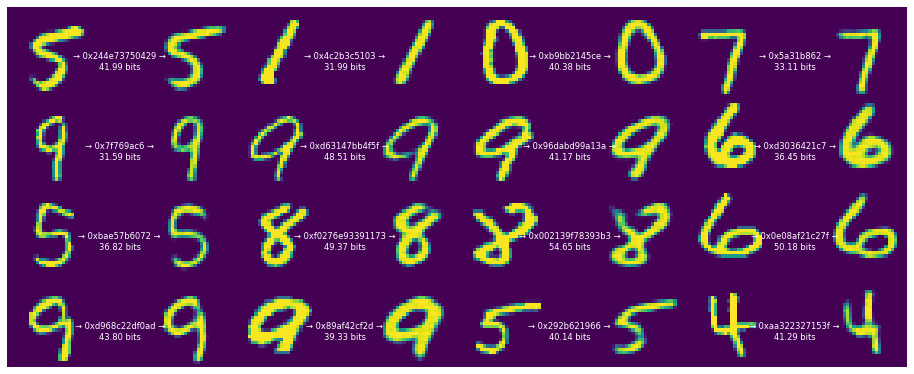

In [24]:
display_digits(originals, strings, entropies, reconstructions)


Note that the length of the encoded string differs from the information content of each digit.

This is because the range coding process works with discretized probabilities, and has a small amount of overhead. So, especially for short strings, the correspondence is only approximate. However, range coding is **asymptotically optimal**: in the limit, the expected bit count will approach the cross entropy (the expected information content), for which the rate term in the training model is an upper bound.

## The rate–distortion trade-off

Above, the model was trained for a specific trade-off (given by `lmbda=2000`) between the average number of bits used to represent each digit and the incurred error in the reconstruction.

What happens when we repeat the experiment with different values?

Let's start by reducing $\lambda$ to 500.

Epoch 1/15


  1/469 [..............................] - ETA: 7:58 - loss: 164.8975 - distortion_loss: 0.1239 - rate_loss: 102.9392 - distortion_pass_through_loss: 0.1239 - rate_pass_through_loss: 102.9392

 11/469 [..............................] - ETA: 2s - loss: 168.5556 - distortion_loss: 0.1319 - rate_loss: 102.5815 - distortion_pass_through_loss: 0.1319 - rate_pass_through_loss: 102.5815  

 22/469 [>.............................] - ETA: 2s - loss: 167.0379 - distortion_loss: 0.1295 - rate_loss: 102.2831 - distortion_pass_through_loss: 0.1295 - rate_pass_through_loss: 102.2831

 33/469 [=>............................] - ETA: 2s - loss: 165.4417 - distortion_loss: 0.1269 - rate_loss: 101.9736 - distortion_pass_through_loss: 0.1269 - rate_pass_through_loss: 101.9736

 44/469 [=>............................] - ETA: 2s - loss: 163.7989 - distortion_loss: 0.1242 - rate_loss: 101.7157 - distortion_pass_through_loss: 0.1242 - rate_pass_through_loss: 101.7157

 55/469 [==>...........................] - ETA: 1s - loss: 161.6396 - distortion_loss: 0.1200 - rate_loss: 101.6214 - distortion_pass_through_loss: 0.1200 - rate_pass_through_loss: 101.6214

 66/469 [===>..........................] - ETA: 1s - loss: 159.4840 - distortion_loss: 0.1161 - rate_loss: 101.4334 - distortion_pass_through_loss: 0.1161 - rate_pass_through_loss: 101.4334

 77/469 [===>..........................] - ETA: 1s - loss: 157.3074 - distortion_loss: 0.1121 - rate_loss: 101.2640 - distortion_pass_through_loss: 0.1121 - rate_pass_through_loss: 101.2640

 88/469 [====>.........................] - ETA: 1s - loss: 155.3172 - distortion_loss: 0.1084 - rate_loss: 101.1026 - distortion_pass_through_loss: 0.1084 - rate_pass_through_loss: 101.1026

 99/469 [=====>........................] - ETA: 1s - loss: 153.4592 - distortion_loss: 0.1051 - rate_loss: 100.9256 - distortion_pass_through_loss: 0.1051 - rate_pass_through_loss: 100.9256

110/469 [======>.......................] - ETA: 1s - loss: 151.8026 - distortion_loss: 0.1021 - rate_loss: 100.7382 - distortion_pass_through_loss: 0.1021 - rate_pass_through_loss: 100.7382

121/469 [======>.......................] - ETA: 1s - loss: 150.2955 - distortion_loss: 0.0995 - rate_loss: 100.5499 - distortion_pass_through_loss: 0.0995 - rate_pass_through_loss: 100.5499

132/469 [=======>......................] - ETA: 1s - loss: 148.8347 - distortion_loss: 0.0970 - rate_loss: 100.3485 - distortion_pass_through_loss: 0.0970 - rate_pass_through_loss: 100.3485

143/469 [========>.....................] - ETA: 1s - loss: 147.5334 - distortion_loss: 0.0948 - rate_loss: 100.1461 - distortion_pass_through_loss: 0.0948 - rate_pass_through_loss: 100.1461

154/469 [========>.....................] - ETA: 1s - loss: 146.3510 - distortion_loss: 0.0928 - rate_loss: 99.9396 - distortion_pass_through_loss: 0.0928 - rate_pass_through_loss: 99.9396  

165/469 [=========>....................] - ETA: 1s - loss: 145.2532 - distortion_loss: 0.0911 - rate_loss: 99.7255 - distortion_pass_through_loss: 0.0911 - rate_pass_through_loss: 99.7255

176/469 [==========>...................] - ETA: 1s - loss: 144.2074 - distortion_loss: 0.0894 - rate_loss: 99.5027 - distortion_pass_through_loss: 0.0894 - rate_pass_through_loss: 99.5027

187/469 [==========>...................] - ETA: 1s - loss: 143.2307 - distortion_loss: 0.0879 - rate_loss: 99.2698 - distortion_pass_through_loss: 0.0879 - rate_pass_through_loss: 99.2698

198/469 [===========>..................] - ETA: 1s - loss: 142.3044 - distortion_loss: 0.0865 - rate_loss: 99.0411 - distortion_pass_through_loss: 0.0865 - rate_pass_through_loss: 99.0411

209/469 [============>.................] - ETA: 1s - loss: 141.3870 - distortion_loss: 0.0852 - rate_loss: 98.8037 - distortion_pass_through_loss: 0.0852 - rate_pass_through_loss: 98.8037

220/469 [=============>................] - ETA: 1s - loss: 140.5312 - distortion_loss: 0.0839 - rate_loss: 98.5631 - distortion_pass_through_loss: 0.0839 - rate_pass_through_loss: 98.5631

230/469 [=============>................] - ETA: 1s - loss: 139.7843 - distortion_loss: 0.0829 - rate_loss: 98.3432 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 98.3432

241/469 [==============>...............] - ETA: 1s - loss: 139.0121 - distortion_loss: 0.0818 - rate_loss: 98.0941 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 98.0941

252/469 [===============>..............] - ETA: 1s - loss: 138.2901 - distortion_loss: 0.0809 - rate_loss: 97.8415 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 97.8415

263/469 [===============>..............] - ETA: 0s - loss: 137.5695 - distortion_loss: 0.0800 - rate_loss: 97.5872 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 97.5872

274/469 [================>.............] - ETA: 0s - loss: 136.8781 - distortion_loss: 0.0791 - rate_loss: 97.3326 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 97.3326

285/469 [=================>............] - ETA: 0s - loss: 136.2273 - distortion_loss: 0.0783 - rate_loss: 97.0777 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 97.0777

296/469 [=================>............] - ETA: 0s - loss: 135.5603 - distortion_loss: 0.0775 - rate_loss: 96.8209 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 96.8209

307/469 [==================>...........] - ETA: 0s - loss: 134.9408 - distortion_loss: 0.0768 - rate_loss: 96.5588 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 96.5588

318/469 [===================>..........] - ETA: 0s - loss: 134.3417 - distortion_loss: 0.0761 - rate_loss: 96.2970 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 96.2970

329/469 [====================>.........] - ETA: 0s - loss: 133.7504 - distortion_loss: 0.0754 - rate_loss: 96.0314 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 96.0314

340/469 [====================>.........] - ETA: 0s - loss: 133.1678 - distortion_loss: 0.0748 - rate_loss: 95.7648 - distortion_pass_through_loss: 0.0748 - rate_pass_through_loss: 95.7648

351/469 [=====================>........] - ETA: 0s - loss: 132.6105 - distortion_loss: 0.0742 - rate_loss: 95.4964 - distortion_pass_through_loss: 0.0742 - rate_pass_through_loss: 95.4964

362/469 [======================>.......] - ETA: 0s - loss: 132.0668 - distortion_loss: 0.0737 - rate_loss: 95.2301 - distortion_pass_through_loss: 0.0737 - rate_pass_through_loss: 95.2301

373/469 [======================>.......] - ETA: 0s - loss: 131.5324 - distortion_loss: 0.0731 - rate_loss: 94.9605 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 94.9605

384/469 [=======================>......] - ETA: 0s - loss: 131.0087 - distortion_loss: 0.0726 - rate_loss: 94.6913 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 94.6913

395/469 [========================>.....] - ETA: 0s - loss: 130.4950 - distortion_loss: 0.0721 - rate_loss: 94.4209 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 94.4209

406/469 [========================>.....] - ETA: 0s - loss: 129.9815 - distortion_loss: 0.0717 - rate_loss: 94.1472 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 94.1472

417/469 [=========================>....] - ETA: 0s - loss: 129.4904 - distortion_loss: 0.0712 - rate_loss: 93.8783 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 93.8783

428/469 [==========================>...] - ETA: 0s - loss: 129.0074 - distortion_loss: 0.0708 - rate_loss: 93.6075 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 93.6075

438/469 [===========================>..] - ETA: 0s - loss: 128.5820 - distortion_loss: 0.0704 - rate_loss: 93.3634 - distortion_pass_through_loss: 0.0704 - rate_pass_through_loss: 93.3634

449/469 [===========================>..] - ETA: 0s - loss: 128.1279 - distortion_loss: 0.0701 - rate_loss: 93.0872 - distortion_pass_through_loss: 0.0701 - rate_pass_through_loss: 93.0872

460/469 [============================>.] - ETA: 0s - loss: 127.6725 - distortion_loss: 0.0697 - rate_loss: 92.8186 - distortion_pass_through_loss: 0.0697 - rate_pass_through_loss: 92.8186

469/469 [==============================] - 4s 6ms/step - loss: 127.3147 - distortion_loss: 0.0694 - rate_loss: 92.6021 - distortion_pass_through_loss: 0.0694 - rate_pass_through_loss: 92.5958 - val_loss: 108.2520 - val_distortion_loss: 0.0575 - val_rate_loss: 79.5169 - val_distortion_pass_through_loss: 0.0575 - val_rate_pass_through_loss: 79.5210


Epoch 2/15


  1/469 [..............................] - ETA: 3s - loss: 106.7520 - distortion_loss: 0.0523 - rate_loss: 80.5907 - distortion_pass_through_loss: 0.0523 - rate_pass_through_loss: 80.5907

 12/469 [..............................] - ETA: 2s - loss: 108.0801 - distortion_loss: 0.0549 - rate_loss: 80.6543 - distortion_pass_through_loss: 0.0549 - rate_pass_through_loss: 80.6543

 23/469 [>.............................] - ETA: 2s - loss: 107.7339 - distortion_loss: 0.0547 - rate_loss: 80.3997 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 80.3997

 33/469 [=>............................] - ETA: 2s - loss: 107.4797 - distortion_loss: 0.0546 - rate_loss: 80.1775 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 80.1775

 44/469 [=>............................] - ETA: 2s - loss: 107.0916 - distortion_loss: 0.0544 - rate_loss: 79.9055 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.9055

 55/469 [==>...........................] - ETA: 2s - loss: 106.8292 - distortion_loss: 0.0544 - rate_loss: 79.6412 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.6412

 66/469 [===>..........................] - ETA: 1s - loss: 106.5836 - distortion_loss: 0.0544 - rate_loss: 79.3638 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.3638

 76/469 [===>..........................] - ETA: 1s - loss: 106.3139 - distortion_loss: 0.0543 - rate_loss: 79.1398 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.1398

 86/469 [====>.........................] - ETA: 1s - loss: 106.0285 - distortion_loss: 0.0543 - rate_loss: 78.8840 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 78.8840

 97/469 [=====>........................] - ETA: 1s - loss: 105.6870 - distortion_loss: 0.0542 - rate_loss: 78.6038 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 78.6038

108/469 [=====>........................] - ETA: 1s - loss: 105.3995 - distortion_loss: 0.0541 - rate_loss: 78.3354 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.3354

119/469 [======>.......................] - ETA: 1s - loss: 105.1303 - distortion_loss: 0.0541 - rate_loss: 78.0790 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.0790

130/469 [=======>......................] - ETA: 1s - loss: 104.8012 - distortion_loss: 0.0540 - rate_loss: 77.7988 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.7988

141/469 [========>.....................] - ETA: 1s - loss: 104.5188 - distortion_loss: 0.0540 - rate_loss: 77.5414 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.5414

152/469 [========>.....................] - ETA: 1s - loss: 104.2514 - distortion_loss: 0.0539 - rate_loss: 77.2792 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.2792

163/469 [=========>....................] - ETA: 1s - loss: 104.0089 - distortion_loss: 0.0540 - rate_loss: 77.0230 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 77.0230

174/469 [==========>...................] - ETA: 1s - loss: 103.7568 - distortion_loss: 0.0540 - rate_loss: 76.7614 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.7614

185/469 [==========>...................] - ETA: 1s - loss: 103.5161 - distortion_loss: 0.0540 - rate_loss: 76.5023 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 76.5023

196/469 [===========>..................] - ETA: 1s - loss: 103.2802 - distortion_loss: 0.0541 - rate_loss: 76.2538 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 76.2538

207/469 [============>.................] - ETA: 1s - loss: 103.0241 - distortion_loss: 0.0540 - rate_loss: 75.9998 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.9998

218/469 [============>.................] - ETA: 1s - loss: 102.7408 - distortion_loss: 0.0540 - rate_loss: 75.7389 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.7389

229/469 [=============>................] - ETA: 1s - loss: 102.4761 - distortion_loss: 0.0540 - rate_loss: 75.4842 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.4842

240/469 [==============>...............] - ETA: 1s - loss: 102.2335 - distortion_loss: 0.0540 - rate_loss: 75.2382 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 75.2382

251/469 [===============>..............] - ETA: 1s - loss: 101.9913 - distortion_loss: 0.0540 - rate_loss: 74.9874 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.9874

262/469 [===============>..............] - ETA: 1s - loss: 101.7443 - distortion_loss: 0.0540 - rate_loss: 74.7383 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.7383

273/469 [================>.............] - ETA: 0s - loss: 101.4931 - distortion_loss: 0.0540 - rate_loss: 74.4860 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.4860

284/469 [=================>............] - ETA: 0s - loss: 101.2651 - distortion_loss: 0.0540 - rate_loss: 74.2453 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 74.2453

295/469 [=================>............] - ETA: 0s - loss: 101.0088 - distortion_loss: 0.0540 - rate_loss: 73.9984 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.9984

306/469 [==================>...........] - ETA: 0s - loss: 100.7675 - distortion_loss: 0.0540 - rate_loss: 73.7555 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.7555

317/469 [===================>..........] - ETA: 0s - loss: 100.5373 - distortion_loss: 0.0540 - rate_loss: 73.5132 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.5132

328/469 [===================>..........] - ETA: 0s - loss: 100.3038 - distortion_loss: 0.0541 - rate_loss: 73.2704 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 73.2704

339/469 [====================>.........] - ETA: 0s - loss: 100.0742 - distortion_loss: 0.0541 - rate_loss: 73.0337 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 73.0337

350/469 [=====================>........] - ETA: 0s - loss: 99.8421 - distortion_loss: 0.0541 - rate_loss: 72.7950 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 72.7950 

361/469 [======================>.......] - ETA: 0s - loss: 99.6100 - distortion_loss: 0.0541 - rate_loss: 72.5587 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 72.5587

372/469 [======================>.......] - ETA: 0s - loss: 99.3808 - distortion_loss: 0.0541 - rate_loss: 72.3216 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 72.3216

383/469 [=======================>......] - ETA: 0s - loss: 99.1495 - distortion_loss: 0.0541 - rate_loss: 72.0877 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 72.0877

394/469 [========================>.....] - ETA: 0s - loss: 98.9187 - distortion_loss: 0.0541 - rate_loss: 71.8504 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 71.8504

405/469 [========================>.....] - ETA: 0s - loss: 98.6791 - distortion_loss: 0.0541 - rate_loss: 71.6156 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 71.6156

416/469 [=========================>....] - ETA: 0s - loss: 98.4559 - distortion_loss: 0.0541 - rate_loss: 71.3838 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 71.3838

427/469 [==========================>...] - ETA: 0s - loss: 98.2273 - distortion_loss: 0.0541 - rate_loss: 71.1526 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 71.1526

438/469 [===========================>..] - ETA: 0s - loss: 98.0044 - distortion_loss: 0.0542 - rate_loss: 70.9211 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 70.9211

449/469 [===========================>..] - ETA: 0s - loss: 97.7842 - distortion_loss: 0.0542 - rate_loss: 70.6906 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 70.6906

460/469 [============================>.] - ETA: 0s - loss: 97.5634 - distortion_loss: 0.0542 - rate_loss: 70.4650 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 70.4650

469/469 [==============================] - 2s 5ms/step - loss: 97.3892 - distortion_loss: 0.0542 - rate_loss: 70.2840 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 70.2788 - val_loss: 86.1725 - val_distortion_loss: 0.0594 - val_rate_loss: 56.4715 - val_distortion_pass_through_loss: 0.0595 - val_rate_pass_through_loss: 56.4720


Epoch 3/15


  1/469 [..............................] - ETA: 3s - loss: 86.2248 - distortion_loss: 0.0509 - rate_loss: 60.7724 - distortion_pass_through_loss: 0.0509 - rate_pass_through_loss: 60.7724

 11/469 [..............................] - ETA: 2s - loss: 87.9834 - distortion_loss: 0.0553 - rate_loss: 60.3349 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 60.3349

 21/469 [>.............................] - ETA: 2s - loss: 87.8128 - distortion_loss: 0.0552 - rate_loss: 60.1910 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 60.1910

 32/469 [=>............................] - ETA: 2s - loss: 87.7061 - distortion_loss: 0.0553 - rate_loss: 60.0359 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 60.0359

 43/469 [=>............................] - ETA: 2s - loss: 87.4851 - distortion_loss: 0.0554 - rate_loss: 59.8066 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 59.8066

 54/469 [==>...........................] - ETA: 2s - loss: 87.3728 - distortion_loss: 0.0555 - rate_loss: 59.6293 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 59.6293

 65/469 [===>..........................] - ETA: 1s - loss: 87.2622 - distortion_loss: 0.0556 - rate_loss: 59.4660 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 59.4660

 75/469 [===>..........................] - ETA: 1s - loss: 87.0561 - distortion_loss: 0.0555 - rate_loss: 59.2857 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 59.2857

 86/469 [====>.........................] - ETA: 1s - loss: 86.8540 - distortion_loss: 0.0555 - rate_loss: 59.0894 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 59.0894

 97/469 [=====>........................] - ETA: 1s - loss: 86.6232 - distortion_loss: 0.0555 - rate_loss: 58.8866 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 58.8866

108/469 [=====>........................] - ETA: 1s - loss: 86.4130 - distortion_loss: 0.0555 - rate_loss: 58.6788 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 58.6788

119/469 [======>.......................] - ETA: 1s - loss: 86.2488 - distortion_loss: 0.0555 - rate_loss: 58.5018 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 58.5018

130/469 [=======>......................] - ETA: 1s - loss: 86.0196 - distortion_loss: 0.0554 - rate_loss: 58.3005 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 58.3005

141/469 [========>.....................] - ETA: 1s - loss: 85.8278 - distortion_loss: 0.0554 - rate_loss: 58.1192 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 58.1192

152/469 [========>.....................] - ETA: 1s - loss: 85.6593 - distortion_loss: 0.0554 - rate_loss: 57.9364 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 57.9364

163/469 [=========>....................] - ETA: 1s - loss: 85.5146 - distortion_loss: 0.0555 - rate_loss: 57.7636 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 57.7636

174/469 [==========>...................] - ETA: 1s - loss: 85.3648 - distortion_loss: 0.0556 - rate_loss: 57.5671 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 57.5671

185/469 [==========>...................] - ETA: 1s - loss: 85.2337 - distortion_loss: 0.0557 - rate_loss: 57.4003 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 57.4003

196/469 [===========>..................] - ETA: 1s - loss: 85.0795 - distortion_loss: 0.0557 - rate_loss: 57.2208 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 57.2208

207/469 [============>.................] - ETA: 1s - loss: 84.9000 - distortion_loss: 0.0557 - rate_loss: 57.0380 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 57.0380

218/469 [============>.................] - ETA: 1s - loss: 84.7075 - distortion_loss: 0.0557 - rate_loss: 56.8564 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 56.8564

229/469 [=============>................] - ETA: 1s - loss: 84.5462 - distortion_loss: 0.0557 - rate_loss: 56.6845 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 56.6845

240/469 [==============>...............] - ETA: 1s - loss: 84.3877 - distortion_loss: 0.0558 - rate_loss: 56.5076 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 56.5076

251/469 [===============>..............] - ETA: 1s - loss: 84.2391 - distortion_loss: 0.0558 - rate_loss: 56.3373 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 56.3373

262/469 [===============>..............] - ETA: 1s - loss: 84.0822 - distortion_loss: 0.0558 - rate_loss: 56.1655 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 56.1655

272/469 [================>.............] - ETA: 0s - loss: 83.9272 - distortion_loss: 0.0558 - rate_loss: 56.0081 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 56.0081

283/469 [=================>............] - ETA: 0s - loss: 83.7970 - distortion_loss: 0.0559 - rate_loss: 55.8453 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 55.8453

293/469 [=================>............] - ETA: 0s - loss: 83.6584 - distortion_loss: 0.0559 - rate_loss: 55.6930 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 55.6930

304/469 [==================>...........] - ETA: 0s - loss: 83.4955 - distortion_loss: 0.0560 - rate_loss: 55.5191 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 55.5191

314/469 [===================>..........] - ETA: 0s - loss: 83.3712 - distortion_loss: 0.0560 - rate_loss: 55.3723 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 55.3723

324/469 [===================>..........] - ETA: 0s - loss: 83.2380 - distortion_loss: 0.0560 - rate_loss: 55.2188 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 55.2188

334/469 [====================>.........] - ETA: 0s - loss: 83.1142 - distortion_loss: 0.0561 - rate_loss: 55.0678 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 55.0678

344/469 [=====================>........] - ETA: 0s - loss: 82.9787 - distortion_loss: 0.0561 - rate_loss: 54.9232 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.9232

355/469 [=====================>........] - ETA: 0s - loss: 82.8353 - distortion_loss: 0.0562 - rate_loss: 54.7567 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 54.7567

366/469 [======================>.......] - ETA: 0s - loss: 82.6937 - distortion_loss: 0.0562 - rate_loss: 54.5940 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 54.5940

377/469 [=======================>......] - ETA: 0s - loss: 82.5438 - distortion_loss: 0.0562 - rate_loss: 54.4303 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 54.4303

388/469 [=======================>......] - ETA: 0s - loss: 82.4019 - distortion_loss: 0.0563 - rate_loss: 54.2707 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 54.2707

399/469 [========================>.....] - ETA: 0s - loss: 82.2541 - distortion_loss: 0.0563 - rate_loss: 54.1077 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 54.1077

410/469 [=========================>....] - ETA: 0s - loss: 82.1155 - distortion_loss: 0.0563 - rate_loss: 53.9509 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.9509

421/469 [=========================>....] - ETA: 0s - loss: 81.9707 - distortion_loss: 0.0563 - rate_loss: 53.7979 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.7979

432/469 [==========================>...] - ETA: 0s - loss: 81.8410 - distortion_loss: 0.0564 - rate_loss: 53.6414 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 53.6414

443/469 [===========================>..] - ETA: 0s - loss: 81.7099 - distortion_loss: 0.0564 - rate_loss: 53.4875 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 53.4875

454/469 [============================>.] - ETA: 0s - loss: 81.5762 - distortion_loss: 0.0565 - rate_loss: 53.3324 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 53.3324

465/469 [============================>.] - ETA: 0s - loss: 81.4483 - distortion_loss: 0.0565 - rate_loss: 53.1784 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 53.1784

469/469 [==============================] - 2s 5ms/step - loss: 81.3976 - distortion_loss: 0.0565 - rate_loss: 53.1271 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 53.1236 - val_loss: 71.7689 - val_distortion_loss: 0.0657 - val_rate_loss: 38.9376 - val_distortion_pass_through_loss: 0.0657 - val_rate_pass_through_loss: 38.9333


Epoch 4/15


  1/469 [..............................] - ETA: 3s - loss: 73.3215 - distortion_loss: 0.0534 - rate_loss: 46.6342 - distortion_pass_through_loss: 0.0534 - rate_pass_through_loss: 46.6342

 12/469 [..............................] - ETA: 2s - loss: 75.6454 - distortion_loss: 0.0580 - rate_loss: 46.6413 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 46.6413

 23/469 [>.............................] - ETA: 2s - loss: 75.5326 - distortion_loss: 0.0582 - rate_loss: 46.4565 - distortion_pass_through_loss: 0.0582 - rate_pass_through_loss: 46.4565

 34/469 [=>............................] - ETA: 2s - loss: 75.4794 - distortion_loss: 0.0584 - rate_loss: 46.2805 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.2805

 45/469 [=>............................] - ETA: 2s - loss: 75.2725 - distortion_loss: 0.0583 - rate_loss: 46.1133 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 46.1133

 56/469 [==>...........................] - ETA: 1s - loss: 75.2139 - distortion_loss: 0.0584 - rate_loss: 46.0223 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.0223

 67/469 [===>..........................] - ETA: 1s - loss: 75.1963 - distortion_loss: 0.0586 - rate_loss: 45.9151 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 45.9151

 78/469 [===>..........................] - ETA: 1s - loss: 75.0280 - distortion_loss: 0.0585 - rate_loss: 45.7887 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.7887

 89/469 [====>.........................] - ETA: 1s - loss: 74.9191 - distortion_loss: 0.0585 - rate_loss: 45.6517 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.6517

100/469 [=====>........................] - ETA: 1s - loss: 74.7782 - distortion_loss: 0.0585 - rate_loss: 45.5150 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.5150

111/469 [======>.......................] - ETA: 1s - loss: 74.6583 - distortion_loss: 0.0585 - rate_loss: 45.3975 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.3975

122/469 [======>.......................] - ETA: 1s - loss: 74.5474 - distortion_loss: 0.0585 - rate_loss: 45.2764 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.2764

133/469 [=======>......................] - ETA: 1s - loss: 74.3726 - distortion_loss: 0.0585 - rate_loss: 45.1403 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.1403

144/469 [========>.....................] - ETA: 1s - loss: 74.2811 - distortion_loss: 0.0585 - rate_loss: 45.0229 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.0229

155/469 [========>.....................] - ETA: 1s - loss: 74.2104 - distortion_loss: 0.0586 - rate_loss: 44.9069 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.9069

166/469 [=========>....................] - ETA: 1s - loss: 74.1109 - distortion_loss: 0.0586 - rate_loss: 44.7918 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.7918

177/469 [==========>...................] - ETA: 1s - loss: 74.0218 - distortion_loss: 0.0587 - rate_loss: 44.6729 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 44.6729

188/469 [===========>..................] - ETA: 1s - loss: 73.9351 - distortion_loss: 0.0587 - rate_loss: 44.5733 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 44.5733

199/469 [===========>..................] - ETA: 1s - loss: 73.8472 - distortion_loss: 0.0588 - rate_loss: 44.4658 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 44.4658

210/469 [============>.................] - ETA: 1s - loss: 73.7241 - distortion_loss: 0.0588 - rate_loss: 44.3365 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 44.3365

220/469 [=============>................] - ETA: 1s - loss: 73.6252 - distortion_loss: 0.0588 - rate_loss: 44.2352 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 44.2352

231/469 [=============>................] - ETA: 1s - loss: 73.5337 - distortion_loss: 0.0588 - rate_loss: 44.1189 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 44.1189

242/469 [==============>...............] - ETA: 1s - loss: 73.4282 - distortion_loss: 0.0589 - rate_loss: 43.9986 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.9986

253/469 [===============>..............] - ETA: 1s - loss: 73.3562 - distortion_loss: 0.0589 - rate_loss: 43.8883 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.8883

264/469 [===============>..............] - ETA: 0s - loss: 73.2528 - distortion_loss: 0.0589 - rate_loss: 43.7783 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.7783

275/469 [================>.............] - ETA: 0s - loss: 73.1683 - distortion_loss: 0.0590 - rate_loss: 43.6714 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.6714

286/469 [=================>............] - ETA: 0s - loss: 73.0912 - distortion_loss: 0.0590 - rate_loss: 43.5748 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.5748

297/469 [=================>............] - ETA: 0s - loss: 72.9879 - distortion_loss: 0.0590 - rate_loss: 43.4643 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.4643

307/469 [==================>...........] - ETA: 0s - loss: 72.9021 - distortion_loss: 0.0591 - rate_loss: 43.3669 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 43.3669

318/469 [===================>..........] - ETA: 0s - loss: 72.8289 - distortion_loss: 0.0591 - rate_loss: 43.2641 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 43.2641

329/469 [====================>.........] - ETA: 0s - loss: 72.7437 - distortion_loss: 0.0592 - rate_loss: 43.1611 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 43.1611

339/469 [====================>.........] - ETA: 0s - loss: 72.6622 - distortion_loss: 0.0592 - rate_loss: 43.0638 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 43.0638

349/469 [=====================>........] - ETA: 0s - loss: 72.5824 - distortion_loss: 0.0592 - rate_loss: 42.9712 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.9712

360/469 [======================>.......] - ETA: 0s - loss: 72.4992 - distortion_loss: 0.0593 - rate_loss: 42.8725 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.8725

370/469 [======================>.......] - ETA: 0s - loss: 72.4332 - distortion_loss: 0.0593 - rate_loss: 42.7834 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.7834

381/469 [=======================>......] - ETA: 0s - loss: 72.3450 - distortion_loss: 0.0593 - rate_loss: 42.6813 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.6813

392/469 [========================>.....] - ETA: 0s - loss: 72.2647 - distortion_loss: 0.0594 - rate_loss: 42.5792 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.5792

403/469 [========================>.....] - ETA: 0s - loss: 72.1666 - distortion_loss: 0.0594 - rate_loss: 42.4718 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.4718

414/469 [=========================>....] - ETA: 0s - loss: 72.0987 - distortion_loss: 0.0594 - rate_loss: 42.3786 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.3786

425/469 [==========================>...] - ETA: 0s - loss: 72.0113 - distortion_loss: 0.0595 - rate_loss: 42.2774 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 42.2774

436/469 [==========================>...] - ETA: 0s - loss: 71.9367 - distortion_loss: 0.0595 - rate_loss: 42.1826 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 42.1826

446/469 [===========================>..] - ETA: 0s - loss: 71.8685 - distortion_loss: 0.0596 - rate_loss: 42.0933 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 42.0933

457/469 [============================>.] - ETA: 0s - loss: 71.7848 - distortion_loss: 0.0596 - rate_loss: 41.9959 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 41.9959

468/469 [============================>.] - ETA: 0s - loss: 71.7134 - distortion_loss: 0.0596 - rate_loss: 41.9035 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 41.9035

469/469 [==============================] - 2s 5ms/step - loss: 71.7039 - distortion_loss: 0.0596 - rate_loss: 41.8972 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 41.8951 - val_loss: 62.9125 - val_distortion_loss: 0.0743 - val_rate_loss: 25.7446 - val_distortion_pass_through_loss: 0.0744 - val_rate_pass_through_loss: 25.7398


Epoch 5/15


  1/469 [..............................] - ETA: 3s - loss: 66.0177 - distortion_loss: 0.0565 - rate_loss: 37.7895 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 37.7895

 11/469 [..............................] - ETA: 2s - loss: 68.5684 - distortion_loss: 0.0613 - rate_loss: 37.8934 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.8934

 22/469 [>.............................] - ETA: 2s - loss: 68.4829 - distortion_loss: 0.0616 - rate_loss: 37.6879 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 37.6879

 32/469 [=>............................] - ETA: 2s - loss: 68.3829 - distortion_loss: 0.0616 - rate_loss: 37.5825 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 37.5825

 43/469 [=>............................] - ETA: 2s - loss: 68.2628 - distortion_loss: 0.0616 - rate_loss: 37.4403 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 37.4403

 54/469 [==>...........................] - ETA: 2s - loss: 68.2279 - distortion_loss: 0.0616 - rate_loss: 37.4058 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 37.4058

 65/469 [===>..........................] - ETA: 1s - loss: 68.1904 - distortion_loss: 0.0617 - rate_loss: 37.3587 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 37.3587

 76/469 [===>..........................] - ETA: 1s - loss: 68.0432 - distortion_loss: 0.0615 - rate_loss: 37.2795 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 37.2795

 87/469 [====>.........................] - ETA: 1s - loss: 67.9342 - distortion_loss: 0.0614 - rate_loss: 37.2218 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 37.2218

 98/469 [=====>........................] - ETA: 1s - loss: 67.8021 - distortion_loss: 0.0614 - rate_loss: 37.1070 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 37.1070

109/469 [=====>........................] - ETA: 1s - loss: 67.7701 - distortion_loss: 0.0615 - rate_loss: 37.0312 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 37.0312

120/469 [======>.......................] - ETA: 1s - loss: 67.7369 - distortion_loss: 0.0615 - rate_loss: 36.9826 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.9826

131/469 [=======>......................] - ETA: 1s - loss: 67.6080 - distortion_loss: 0.0614 - rate_loss: 36.8846 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.8846

142/469 [========>.....................] - ETA: 1s - loss: 67.5031 - distortion_loss: 0.0614 - rate_loss: 36.7988 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.7988

153/469 [========>.....................] - ETA: 1s - loss: 67.4512 - distortion_loss: 0.0614 - rate_loss: 36.7318 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.7318

164/469 [=========>....................] - ETA: 1s - loss: 67.4122 - distortion_loss: 0.0615 - rate_loss: 36.6638 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.6638

175/469 [==========>...................] - ETA: 1s - loss: 67.3555 - distortion_loss: 0.0615 - rate_loss: 36.5848 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.5848

186/469 [==========>...................] - ETA: 1s - loss: 67.3113 - distortion_loss: 0.0616 - rate_loss: 36.5134 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.5134

197/469 [===========>..................] - ETA: 1s - loss: 67.2725 - distortion_loss: 0.0616 - rate_loss: 36.4544 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.4544

208/469 [============>.................] - ETA: 1s - loss: 67.2043 - distortion_loss: 0.0616 - rate_loss: 36.3846 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.3846

219/469 [=============>................] - ETA: 1s - loss: 67.1246 - distortion_loss: 0.0616 - rate_loss: 36.3161 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.3161

230/469 [=============>................] - ETA: 1s - loss: 67.0739 - distortion_loss: 0.0617 - rate_loss: 36.2463 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 36.2463

241/469 [==============>...............] - ETA: 1s - loss: 67.0258 - distortion_loss: 0.0617 - rate_loss: 36.1666 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 36.1666

252/469 [===============>..............] - ETA: 1s - loss: 66.9819 - distortion_loss: 0.0618 - rate_loss: 36.0942 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 36.0942

263/469 [===============>..............] - ETA: 0s - loss: 66.9212 - distortion_loss: 0.0618 - rate_loss: 36.0259 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 36.0259

274/469 [================>.............] - ETA: 0s - loss: 66.8782 - distortion_loss: 0.0619 - rate_loss: 35.9517 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.9517

285/469 [=================>............] - ETA: 0s - loss: 66.8440 - distortion_loss: 0.0619 - rate_loss: 35.8914 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.8914

296/469 [=================>............] - ETA: 0s - loss: 66.7666 - distortion_loss: 0.0619 - rate_loss: 35.8229 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.8229

307/469 [==================>...........] - ETA: 0s - loss: 66.7146 - distortion_loss: 0.0619 - rate_loss: 35.7601 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.7601

318/469 [===================>..........] - ETA: 0s - loss: 66.6778 - distortion_loss: 0.0620 - rate_loss: 35.6931 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.6931

329/469 [====================>.........] - ETA: 0s - loss: 66.6368 - distortion_loss: 0.0620 - rate_loss: 35.6352 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.6352

340/469 [====================>.........] - ETA: 0s - loss: 66.5812 - distortion_loss: 0.0620 - rate_loss: 35.5676 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.5676

351/469 [=====================>........] - ETA: 0s - loss: 66.5331 - distortion_loss: 0.0621 - rate_loss: 35.5005 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.5005

362/469 [======================>.......] - ETA: 0s - loss: 66.4838 - distortion_loss: 0.0621 - rate_loss: 35.4399 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.4399

373/469 [======================>.......] - ETA: 0s - loss: 66.4371 - distortion_loss: 0.0621 - rate_loss: 35.3742 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.3742

384/469 [=======================>......] - ETA: 0s - loss: 66.3846 - distortion_loss: 0.0621 - rate_loss: 35.3116 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.3116

395/469 [========================>.....] - ETA: 0s - loss: 66.3213 - distortion_loss: 0.0622 - rate_loss: 35.2407 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.2407

406/469 [========================>.....] - ETA: 0s - loss: 66.2537 - distortion_loss: 0.0622 - rate_loss: 35.1719 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.1719

417/469 [=========================>....] - ETA: 0s - loss: 66.2085 - distortion_loss: 0.0622 - rate_loss: 35.1148 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.1148

428/469 [==========================>...] - ETA: 0s - loss: 66.1571 - distortion_loss: 0.0622 - rate_loss: 35.0541 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.0541

439/469 [===========================>..] - ETA: 0s - loss: 66.1145 - distortion_loss: 0.0622 - rate_loss: 34.9952 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9952

450/469 [===========================>..] - ETA: 0s - loss: 66.0720 - distortion_loss: 0.0623 - rate_loss: 34.9334 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 34.9334

461/469 [============================>.] - ETA: 0s - loss: 66.0304 - distortion_loss: 0.0623 - rate_loss: 34.8731 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 34.8731

469/469 [==============================] - 2s 5ms/step - loss: 65.9941 - distortion_loss: 0.0623 - rate_loss: 34.8288 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 34.8277 - val_loss: 56.9836 - val_distortion_loss: 0.0770 - val_rate_loss: 18.5021 - val_distortion_pass_through_loss: 0.0770 - val_rate_pass_through_loss: 18.4913


Epoch 6/15


  1/469 [..............................] - ETA: 3s - loss: 61.3099 - distortion_loss: 0.0574 - rate_loss: 32.6191 - distortion_pass_through_loss: 0.0574 - rate_pass_through_loss: 32.6191

 11/469 [..............................] - ETA: 2s - loss: 63.8743 - distortion_loss: 0.0630 - rate_loss: 32.3771 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 32.3771

 22/469 [>.............................] - ETA: 2s - loss: 64.0445 - distortion_loss: 0.0637 - rate_loss: 32.1928 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 32.1928

 32/469 [=>............................] - ETA: 2s - loss: 63.9022 - distortion_loss: 0.0636 - rate_loss: 32.0909 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 32.0909

 43/469 [=>............................] - ETA: 2s - loss: 63.7788 - distortion_loss: 0.0636 - rate_loss: 31.9662 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.9662

 54/469 [==>...........................] - ETA: 2s - loss: 63.8078 - distortion_loss: 0.0637 - rate_loss: 31.9414 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.9414

 65/469 [===>..........................] - ETA: 1s - loss: 63.8605 - distortion_loss: 0.0638 - rate_loss: 31.9381 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.9381

 76/469 [===>..........................] - ETA: 1s - loss: 63.7692 - distortion_loss: 0.0638 - rate_loss: 31.8592 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.8592

 87/469 [====>.........................] - ETA: 1s - loss: 63.6918 - distortion_loss: 0.0637 - rate_loss: 31.8405 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.8405

 98/469 [=====>........................] - ETA: 1s - loss: 63.5935 - distortion_loss: 0.0636 - rate_loss: 31.7727 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.7727

109/469 [=====>........................] - ETA: 1s - loss: 63.4930 - distortion_loss: 0.0636 - rate_loss: 31.7068 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.7068

120/469 [======>.......................] - ETA: 1s - loss: 63.4846 - distortion_loss: 0.0636 - rate_loss: 31.6872 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.6872

131/469 [=======>......................] - ETA: 1s - loss: 63.3716 - distortion_loss: 0.0635 - rate_loss: 31.6307 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.6307

142/469 [========>.....................] - ETA: 1s - loss: 63.3239 - distortion_loss: 0.0635 - rate_loss: 31.5945 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5945

153/469 [========>.....................] - ETA: 1s - loss: 63.3017 - distortion_loss: 0.0635 - rate_loss: 31.5383 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 31.5383

164/469 [=========>....................] - ETA: 1s - loss: 63.2782 - distortion_loss: 0.0636 - rate_loss: 31.4916 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.4916

175/469 [==========>...................] - ETA: 1s - loss: 63.2407 - distortion_loss: 0.0636 - rate_loss: 31.4414 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.4414

186/469 [==========>...................] - ETA: 1s - loss: 63.2217 - distortion_loss: 0.0637 - rate_loss: 31.3940 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3940

197/469 [===========>..................] - ETA: 1s - loss: 63.2191 - distortion_loss: 0.0637 - rate_loss: 31.3550 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3550

208/469 [============>.................] - ETA: 1s - loss: 63.1760 - distortion_loss: 0.0637 - rate_loss: 31.3071 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.3071

219/469 [=============>................] - ETA: 1s - loss: 63.1264 - distortion_loss: 0.0637 - rate_loss: 31.2583 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.2583

230/469 [=============>................] - ETA: 1s - loss: 63.0853 - distortion_loss: 0.0638 - rate_loss: 31.2060 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2060

241/469 [==============>...............] - ETA: 1s - loss: 63.0477 - distortion_loss: 0.0638 - rate_loss: 31.1481 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1481

252/469 [===============>..............] - ETA: 1s - loss: 63.0243 - distortion_loss: 0.0638 - rate_loss: 31.1024 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.1024

263/469 [===============>..............] - ETA: 0s - loss: 62.9743 - distortion_loss: 0.0638 - rate_loss: 31.0513 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.0513

274/469 [================>.............] - ETA: 0s - loss: 62.9336 - distortion_loss: 0.0639 - rate_loss: 31.0081 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0081

285/469 [=================>............] - ETA: 0s - loss: 62.9198 - distortion_loss: 0.0639 - rate_loss: 30.9644 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.9644

296/469 [=================>............] - ETA: 0s - loss: 62.8612 - distortion_loss: 0.0639 - rate_loss: 30.9204 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.9204

307/469 [==================>...........] - ETA: 0s - loss: 62.8278 - distortion_loss: 0.0639 - rate_loss: 30.8748 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8748

318/469 [===================>..........] - ETA: 0s - loss: 62.7976 - distortion_loss: 0.0639 - rate_loss: 30.8293 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 30.8293

329/469 [====================>.........] - ETA: 0s - loss: 62.7690 - distortion_loss: 0.0640 - rate_loss: 30.7896 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.7896

340/469 [====================>.........] - ETA: 0s - loss: 62.7379 - distortion_loss: 0.0640 - rate_loss: 30.7504 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.7504

351/469 [=====================>........] - ETA: 0s - loss: 62.6989 - distortion_loss: 0.0640 - rate_loss: 30.7023 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.7023

362/469 [======================>.......] - ETA: 0s - loss: 62.6675 - distortion_loss: 0.0640 - rate_loss: 30.6586 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.6586

373/469 [======================>.......] - ETA: 0s - loss: 62.6321 - distortion_loss: 0.0640 - rate_loss: 30.6191 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.6191

384/469 [=======================>......] - ETA: 0s - loss: 62.6006 - distortion_loss: 0.0640 - rate_loss: 30.5757 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.5757

395/469 [========================>.....] - ETA: 0s - loss: 62.5562 - distortion_loss: 0.0641 - rate_loss: 30.5284 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.5284

406/469 [========================>.....] - ETA: 0s - loss: 62.5067 - distortion_loss: 0.0641 - rate_loss: 30.4795 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4795

417/469 [=========================>....] - ETA: 0s - loss: 62.4816 - distortion_loss: 0.0641 - rate_loss: 30.4467 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4467

428/469 [==========================>...] - ETA: 0s - loss: 62.4424 - distortion_loss: 0.0641 - rate_loss: 30.4042 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.4042

439/469 [===========================>..] - ETA: 0s - loss: 62.4094 - distortion_loss: 0.0641 - rate_loss: 30.3612 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.3612

450/469 [===========================>..] - ETA: 0s - loss: 62.3751 - distortion_loss: 0.0641 - rate_loss: 30.3206 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.3206

461/469 [============================>.] - ETA: 0s - loss: 62.3525 - distortion_loss: 0.0641 - rate_loss: 30.2786 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.2786

469/469 [==============================] - 2s 5ms/step - loss: 62.3329 - distortion_loss: 0.0642 - rate_loss: 30.2477 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.2465 - val_loss: 53.4482 - val_distortion_loss: 0.0779 - val_rate_loss: 14.5194 - val_distortion_pass_through_loss: 0.0779 - val_rate_pass_through_loss: 14.5169


Epoch 7/15


  1/469 [..............................] - ETA: 3s - loss: 59.2584 - distortion_loss: 0.0625 - rate_loss: 27.9857 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 27.9857

 12/469 [..............................] - ETA: 2s - loss: 61.3081 - distortion_loss: 0.0653 - rate_loss: 28.6368 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.6368

 23/469 [>.............................] - ETA: 2s - loss: 61.0473 - distortion_loss: 0.0652 - rate_loss: 28.4473 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.4473

 34/469 [=>............................] - ETA: 2s - loss: 61.1278 - distortion_loss: 0.0655 - rate_loss: 28.3949 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.3949

 45/469 [=>............................] - ETA: 2s - loss: 60.9444 - distortion_loss: 0.0653 - rate_loss: 28.3174 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3174

 56/469 [==>...........................] - ETA: 2s - loss: 60.9551 - distortion_loss: 0.0652 - rate_loss: 28.3418 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.3418

 67/469 [===>..........................] - ETA: 1s - loss: 60.9828 - distortion_loss: 0.0654 - rate_loss: 28.3059 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.3059

 78/469 [===>..........................] - ETA: 1s - loss: 60.8786 - distortion_loss: 0.0652 - rate_loss: 28.2837 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.2837

 89/469 [====>.........................] - ETA: 1s - loss: 60.8415 - distortion_loss: 0.0652 - rate_loss: 28.2555 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.2555

100/469 [=====>........................] - ETA: 1s - loss: 60.7771 - distortion_loss: 0.0651 - rate_loss: 28.2032 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.2032

111/469 [======>.......................] - ETA: 1s - loss: 60.7137 - distortion_loss: 0.0651 - rate_loss: 28.1565 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1565

122/469 [======>.......................] - ETA: 1s - loss: 60.6421 - distortion_loss: 0.0651 - rate_loss: 28.1157 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1157

133/469 [=======>......................] - ETA: 1s - loss: 60.5494 - distortion_loss: 0.0650 - rate_loss: 28.0633 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 28.0633

144/469 [========>.....................] - ETA: 1s - loss: 60.5169 - distortion_loss: 0.0650 - rate_loss: 28.0244 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 28.0244

155/469 [========>.....................] - ETA: 1s - loss: 60.5244 - distortion_loss: 0.0650 - rate_loss: 28.0077 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 28.0077

166/469 [=========>....................] - ETA: 1s - loss: 60.4921 - distortion_loss: 0.0651 - rate_loss: 27.9655 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.9655

177/469 [==========>...................] - ETA: 1s - loss: 60.4595 - distortion_loss: 0.0651 - rate_loss: 27.9267 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.9267

188/469 [===========>..................] - ETA: 1s - loss: 60.4325 - distortion_loss: 0.0651 - rate_loss: 27.8893 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.8893

198/469 [===========>..................] - ETA: 1s - loss: 60.4273 - distortion_loss: 0.0651 - rate_loss: 27.8702 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.8702

209/469 [============>.................] - ETA: 1s - loss: 60.3788 - distortion_loss: 0.0651 - rate_loss: 27.8294 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.8294

219/469 [=============>................] - ETA: 1s - loss: 60.3288 - distortion_loss: 0.0651 - rate_loss: 27.8003 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.8003

230/469 [=============>................] - ETA: 1s - loss: 60.2874 - distortion_loss: 0.0651 - rate_loss: 27.7544 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.7544

240/469 [==============>...............] - ETA: 1s - loss: 60.2682 - distortion_loss: 0.0651 - rate_loss: 27.7205 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.7205

250/469 [==============>...............] - ETA: 1s - loss: 60.2580 - distortion_loss: 0.0651 - rate_loss: 27.6887 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.6887

260/469 [===============>..............] - ETA: 1s - loss: 60.2195 - distortion_loss: 0.0651 - rate_loss: 27.6588 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.6588

271/469 [================>.............] - ETA: 0s - loss: 60.1888 - distortion_loss: 0.0651 - rate_loss: 27.6218 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.6218

281/469 [================>.............] - ETA: 0s - loss: 60.1634 - distortion_loss: 0.0651 - rate_loss: 27.5933 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.5933

292/469 [=================>............] - ETA: 0s - loss: 60.1379 - distortion_loss: 0.0652 - rate_loss: 27.5625 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.5625

303/469 [==================>...........] - ETA: 0s - loss: 60.0962 - distortion_loss: 0.0651 - rate_loss: 27.5224 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 27.5224

314/469 [===================>..........] - ETA: 0s - loss: 60.0668 - distortion_loss: 0.0652 - rate_loss: 27.4917 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.4917

325/469 [===================>..........] - ETA: 0s - loss: 60.0414 - distortion_loss: 0.0652 - rate_loss: 27.4608 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.4608

335/469 [====================>.........] - ETA: 0s - loss: 60.0258 - distortion_loss: 0.0652 - rate_loss: 27.4384 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.4384

346/469 [=====================>........] - ETA: 0s - loss: 59.9817 - distortion_loss: 0.0652 - rate_loss: 27.3994 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.3994

357/469 [=====================>........] - ETA: 0s - loss: 59.9527 - distortion_loss: 0.0652 - rate_loss: 27.3678 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.3678

368/469 [======================>.......] - ETA: 0s - loss: 59.9296 - distortion_loss: 0.0652 - rate_loss: 27.3338 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.3338

379/469 [=======================>......] - ETA: 0s - loss: 59.9024 - distortion_loss: 0.0652 - rate_loss: 27.3012 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.3012

390/469 [=======================>......] - ETA: 0s - loss: 59.8719 - distortion_loss: 0.0652 - rate_loss: 27.2710 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.2710

400/469 [========================>.....] - ETA: 0s - loss: 59.8463 - distortion_loss: 0.0652 - rate_loss: 27.2402 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.2402

411/469 [=========================>....] - ETA: 0s - loss: 59.8068 - distortion_loss: 0.0652 - rate_loss: 27.2041 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.2041

422/469 [=========================>....] - ETA: 0s - loss: 59.7808 - distortion_loss: 0.0652 - rate_loss: 27.1713 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.1713

433/469 [==========================>...] - ETA: 0s - loss: 59.7719 - distortion_loss: 0.0653 - rate_loss: 27.1461 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.1461

444/469 [===========================>..] - ETA: 0s - loss: 59.7501 - distortion_loss: 0.0653 - rate_loss: 27.1166 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.1166

455/469 [============================>.] - ETA: 0s - loss: 59.7281 - distortion_loss: 0.0653 - rate_loss: 27.0803 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.0803

466/469 [============================>.] - ETA: 0s - loss: 59.7064 - distortion_loss: 0.0653 - rate_loss: 27.0500 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.0500

469/469 [==============================] - 2s 5ms/step - loss: 59.6933 - distortion_loss: 0.0653 - rate_loss: 27.0410 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.0403 - val_loss: 50.4753 - val_distortion_loss: 0.0759 - val_rate_loss: 12.5500 - val_distortion_pass_through_loss: 0.0759 - val_rate_pass_through_loss: 12.5563


Epoch 8/15


  1/469 [..............................] - ETA: 3s - loss: 56.1489 - distortion_loss: 0.0636 - rate_loss: 24.3497 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 24.3497

 12/469 [..............................] - ETA: 2s - loss: 58.8131 - distortion_loss: 0.0664 - rate_loss: 25.5915 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 25.5915

 23/469 [>.............................] - ETA: 2s - loss: 58.7007 - distortion_loss: 0.0661 - rate_loss: 25.6504 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6504

 34/469 [=>............................] - ETA: 2s - loss: 58.7614 - distortion_loss: 0.0662 - rate_loss: 25.6389 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.6389

 45/469 [=>............................] - ETA: 2s - loss: 58.5514 - distortion_loss: 0.0659 - rate_loss: 25.6066 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.6066

 56/469 [==>...........................] - ETA: 1s - loss: 58.5142 - distortion_loss: 0.0659 - rate_loss: 25.5821 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.5821

 67/469 [===>..........................] - ETA: 1s - loss: 58.5771 - distortion_loss: 0.0661 - rate_loss: 25.5444 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.5444

 78/469 [===>..........................] - ETA: 1s - loss: 58.4613 - distortion_loss: 0.0659 - rate_loss: 25.4902 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4902

 89/469 [====>.........................] - ETA: 1s - loss: 58.3926 - distortion_loss: 0.0658 - rate_loss: 25.4736 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 25.4736

100/469 [=====>........................] - ETA: 1s - loss: 58.3175 - distortion_loss: 0.0657 - rate_loss: 25.4569 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.4569

111/469 [======>.......................] - ETA: 1s - loss: 58.2687 - distortion_loss: 0.0657 - rate_loss: 25.4195 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.4195

122/469 [======>.......................] - ETA: 1s - loss: 58.2260 - distortion_loss: 0.0656 - rate_loss: 25.4025 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.4025

133/469 [=======>......................] - ETA: 1s - loss: 58.1253 - distortion_loss: 0.0655 - rate_loss: 25.3598 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.3598

144/469 [========>.....................] - ETA: 1s - loss: 58.0926 - distortion_loss: 0.0655 - rate_loss: 25.3213 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 25.3213

155/469 [========>.....................] - ETA: 1s - loss: 58.1123 - distortion_loss: 0.0656 - rate_loss: 25.2897 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.2897

166/469 [=========>....................] - ETA: 1s - loss: 58.1037 - distortion_loss: 0.0657 - rate_loss: 25.2637 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.2637

177/469 [==========>...................] - ETA: 1s - loss: 58.0925 - distortion_loss: 0.0657 - rate_loss: 25.2454 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.2454

188/469 [===========>..................] - ETA: 1s - loss: 58.0767 - distortion_loss: 0.0657 - rate_loss: 25.2220 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.2220

199/469 [===========>..................] - ETA: 1s - loss: 58.0551 - distortion_loss: 0.0657 - rate_loss: 25.1957 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.1957

210/469 [============>.................] - ETA: 1s - loss: 58.0064 - distortion_loss: 0.0657 - rate_loss: 25.1618 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.1618

221/469 [=============>................] - ETA: 1s - loss: 57.9687 - distortion_loss: 0.0657 - rate_loss: 25.1330 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.1330

232/469 [=============>................] - ETA: 1s - loss: 57.9363 - distortion_loss: 0.0656 - rate_loss: 25.1140 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.1140

243/469 [==============>...............] - ETA: 1s - loss: 57.9075 - distortion_loss: 0.0656 - rate_loss: 25.0847 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 25.0847

254/469 [===============>..............] - ETA: 1s - loss: 57.9034 - distortion_loss: 0.0657 - rate_loss: 25.0557 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.0557

265/469 [===============>..............] - ETA: 0s - loss: 57.8627 - distortion_loss: 0.0657 - rate_loss: 25.0259 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.0259

276/469 [================>.............] - ETA: 0s - loss: 57.8454 - distortion_loss: 0.0657 - rate_loss: 25.0098 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 25.0098

287/469 [=================>............] - ETA: 0s - loss: 57.8396 - distortion_loss: 0.0657 - rate_loss: 24.9950 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.9950

298/469 [==================>...........] - ETA: 0s - loss: 57.8016 - distortion_loss: 0.0657 - rate_loss: 24.9683 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.9683

309/469 [==================>...........] - ETA: 0s - loss: 57.7798 - distortion_loss: 0.0657 - rate_loss: 24.9425 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.9425

319/469 [===================>..........] - ETA: 0s - loss: 57.7642 - distortion_loss: 0.0657 - rate_loss: 24.9252 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.9252

330/469 [====================>.........] - ETA: 0s - loss: 57.7523 - distortion_loss: 0.0657 - rate_loss: 24.9016 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.9016

341/469 [====================>.........] - ETA: 0s - loss: 57.7312 - distortion_loss: 0.0657 - rate_loss: 24.8800 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.8800

351/469 [=====================>........] - ETA: 0s - loss: 57.7118 - distortion_loss: 0.0657 - rate_loss: 24.8612 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.8612

361/469 [======================>.......] - ETA: 0s - loss: 57.6891 - distortion_loss: 0.0657 - rate_loss: 24.8365 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.8365

371/469 [======================>.......] - ETA: 0s - loss: 57.6734 - distortion_loss: 0.0657 - rate_loss: 24.8138 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.8138

381/469 [=======================>......] - ETA: 0s - loss: 57.6426 - distortion_loss: 0.0657 - rate_loss: 24.7890 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.7890

392/469 [========================>.....] - ETA: 0s - loss: 57.6204 - distortion_loss: 0.0657 - rate_loss: 24.7644 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.7644

403/469 [========================>.....] - ETA: 0s - loss: 57.5841 - distortion_loss: 0.0657 - rate_loss: 24.7415 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.7415

414/469 [=========================>....] - ETA: 0s - loss: 57.5770 - distortion_loss: 0.0657 - rate_loss: 24.7176 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.7176

424/469 [==========================>...] - ETA: 0s - loss: 57.5422 - distortion_loss: 0.0657 - rate_loss: 24.6949 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.6949

434/469 [==========================>...] - ETA: 0s - loss: 57.5280 - distortion_loss: 0.0657 - rate_loss: 24.6697 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.6697

445/469 [===========================>..] - ETA: 0s - loss: 57.5013 - distortion_loss: 0.0657 - rate_loss: 24.6429 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.6429

456/469 [============================>.] - ETA: 0s - loss: 57.4821 - distortion_loss: 0.0657 - rate_loss: 24.6189 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.6189

467/469 [============================>.] - ETA: 0s - loss: 57.4703 - distortion_loss: 0.0657 - rate_loss: 24.6051 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.6051

469/469 [==============================] - 2s 5ms/step - loss: 57.4602 - distortion_loss: 0.0657 - rate_loss: 24.5984 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 24.5975 - val_loss: 48.6026 - val_distortion_loss: 0.0723 - val_rate_loss: 12.4449 - val_distortion_pass_through_loss: 0.0723 - val_rate_pass_through_loss: 12.4473


Epoch 9/15


  1/469 [..............................] - ETA: 3s - loss: 53.8447 - distortion_loss: 0.0629 - rate_loss: 22.3716 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 22.3716

 12/469 [..............................] - ETA: 2s - loss: 56.4215 - distortion_loss: 0.0655 - rate_loss: 23.6494 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.6494

 23/469 [>.............................] - ETA: 2s - loss: 56.3303 - distortion_loss: 0.0657 - rate_loss: 23.4919 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 23.4919

 34/469 [=>............................] - ETA: 2s - loss: 56.3998 - distortion_loss: 0.0657 - rate_loss: 23.5435 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 23.5435

 45/469 [=>............................] - ETA: 2s - loss: 56.3184 - distortion_loss: 0.0657 - rate_loss: 23.4915 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 23.4915

 56/469 [==>...........................] - ETA: 1s - loss: 56.2839 - distortion_loss: 0.0656 - rate_loss: 23.4718 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 23.4718

 67/469 [===>..........................] - ETA: 1s - loss: 56.3317 - distortion_loss: 0.0657 - rate_loss: 23.4581 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 23.4581

 78/469 [===>..........................] - ETA: 1s - loss: 56.2540 - distortion_loss: 0.0656 - rate_loss: 23.4385 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 23.4385

 89/469 [====>.........................] - ETA: 1s - loss: 56.2147 - distortion_loss: 0.0656 - rate_loss: 23.4289 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 23.4289

100/469 [=====>........................] - ETA: 1s - loss: 56.1513 - distortion_loss: 0.0655 - rate_loss: 23.3927 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.3927

111/469 [======>.......................] - ETA: 1s - loss: 56.0987 - distortion_loss: 0.0655 - rate_loss: 23.3446 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.3446

122/469 [======>.......................] - ETA: 1s - loss: 56.0572 - distortion_loss: 0.0655 - rate_loss: 23.3192 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.3192

133/469 [=======>......................] - ETA: 1s - loss: 55.9534 - distortion_loss: 0.0654 - rate_loss: 23.2731 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.2731

144/469 [========>.....................] - ETA: 1s - loss: 55.9373 - distortion_loss: 0.0654 - rate_loss: 23.2488 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.2488

155/469 [========>.....................] - ETA: 1s - loss: 55.9421 - distortion_loss: 0.0654 - rate_loss: 23.2208 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.2208

166/469 [=========>....................] - ETA: 1s - loss: 55.9164 - distortion_loss: 0.0654 - rate_loss: 23.2057 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.2057

177/469 [==========>...................] - ETA: 1s - loss: 55.9188 - distortion_loss: 0.0655 - rate_loss: 23.1810 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.1810

188/469 [===========>..................] - ETA: 1s - loss: 55.9023 - distortion_loss: 0.0655 - rate_loss: 23.1745 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.1745

199/469 [===========>..................] - ETA: 1s - loss: 55.8917 - distortion_loss: 0.0655 - rate_loss: 23.1605 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 23.1605

210/469 [============>.................] - ETA: 1s - loss: 55.8371 - distortion_loss: 0.0654 - rate_loss: 23.1331 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.1331

221/469 [=============>................] - ETA: 1s - loss: 55.8073 - distortion_loss: 0.0654 - rate_loss: 23.1141 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.1141

232/469 [=============>................] - ETA: 1s - loss: 55.7989 - distortion_loss: 0.0654 - rate_loss: 23.1098 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.1098

243/469 [==============>...............] - ETA: 1s - loss: 55.7645 - distortion_loss: 0.0654 - rate_loss: 23.0864 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.0864

254/469 [===============>..............] - ETA: 1s - loss: 55.7739 - distortion_loss: 0.0654 - rate_loss: 23.0727 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.0727

265/469 [===============>..............] - ETA: 0s - loss: 55.7451 - distortion_loss: 0.0654 - rate_loss: 23.0525 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.0525

276/469 [================>.............] - ETA: 0s - loss: 55.7266 - distortion_loss: 0.0654 - rate_loss: 23.0320 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.0320

287/469 [=================>............] - ETA: 0s - loss: 55.7068 - distortion_loss: 0.0654 - rate_loss: 23.0161 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 23.0161

298/469 [==================>...........] - ETA: 0s - loss: 55.6714 - distortion_loss: 0.0654 - rate_loss: 22.9913 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.9913

309/469 [==================>...........] - ETA: 0s - loss: 55.6618 - distortion_loss: 0.0654 - rate_loss: 22.9694 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.9694

320/469 [===================>..........] - ETA: 0s - loss: 55.6415 - distortion_loss: 0.0654 - rate_loss: 22.9486 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.9486

331/469 [====================>.........] - ETA: 0s - loss: 55.6227 - distortion_loss: 0.0654 - rate_loss: 22.9289 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.9289

342/469 [====================>.........] - ETA: 0s - loss: 55.6094 - distortion_loss: 0.0654 - rate_loss: 22.9154 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.9154

352/469 [=====================>........] - ETA: 0s - loss: 55.5920 - distortion_loss: 0.0654 - rate_loss: 22.9018 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.9018

363/469 [======================>.......] - ETA: 0s - loss: 55.5693 - distortion_loss: 0.0654 - rate_loss: 22.8780 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8780

374/469 [======================>.......] - ETA: 0s - loss: 55.5536 - distortion_loss: 0.0654 - rate_loss: 22.8569 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8569

385/469 [=======================>......] - ETA: 0s - loss: 55.5323 - distortion_loss: 0.0654 - rate_loss: 22.8350 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8350

396/469 [========================>.....] - ETA: 0s - loss: 55.5090 - distortion_loss: 0.0654 - rate_loss: 22.8166 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.8166

407/469 [=========================>....] - ETA: 0s - loss: 55.4673 - distortion_loss: 0.0653 - rate_loss: 22.7924 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 22.7924

418/469 [=========================>....] - ETA: 0s - loss: 55.4463 - distortion_loss: 0.0654 - rate_loss: 22.7706 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 22.7706

429/469 [==========================>...] - ETA: 0s - loss: 55.4220 - distortion_loss: 0.0653 - rate_loss: 22.7553 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 22.7553

440/469 [===========================>..] - ETA: 0s - loss: 55.3950 - distortion_loss: 0.0653 - rate_loss: 22.7326 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 22.7326

451/469 [===========================>..] - ETA: 0s - loss: 55.3676 - distortion_loss: 0.0653 - rate_loss: 22.7095 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 22.7095

462/469 [============================>.] - ETA: 0s - loss: 55.3521 - distortion_loss: 0.0653 - rate_loss: 22.6927 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 22.6927

469/469 [==============================] - 2s 5ms/step - loss: 55.3320 - distortion_loss: 0.0653 - rate_loss: 22.6798 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 22.6792 - val_loss: 47.3538 - val_distortion_loss: 0.0683 - val_rate_loss: 13.1898 - val_distortion_pass_through_loss: 0.0683 - val_rate_pass_through_loss: 13.1987


Epoch 10/15


  1/469 [..............................] - ETA: 3s - loss: 52.3039 - distortion_loss: 0.0613 - rate_loss: 21.6608 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 21.6608

 12/469 [..............................] - ETA: 2s - loss: 54.4867 - distortion_loss: 0.0651 - rate_loss: 21.9599 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.9599

 23/469 [>.............................] - ETA: 2s - loss: 54.4306 - distortion_loss: 0.0650 - rate_loss: 21.9233 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 21.9233

 34/469 [=>............................] - ETA: 2s - loss: 54.5097 - distortion_loss: 0.0653 - rate_loss: 21.8550 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.8550

 45/469 [=>............................] - ETA: 2s - loss: 54.3350 - distortion_loss: 0.0651 - rate_loss: 21.7949 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.7949

 56/469 [==>...........................] - ETA: 1s - loss: 54.3516 - distortion_loss: 0.0650 - rate_loss: 21.8289 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 21.8289

 67/469 [===>..........................] - ETA: 1s - loss: 54.3972 - distortion_loss: 0.0651 - rate_loss: 21.8312 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 21.8312

 78/469 [===>..........................] - ETA: 1s - loss: 54.3074 - distortion_loss: 0.0650 - rate_loss: 21.8235 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 21.8235

 89/469 [====>.........................] - ETA: 1s - loss: 54.2600 - distortion_loss: 0.0649 - rate_loss: 21.7885 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 21.7885

100/469 [=====>........................] - ETA: 1s - loss: 54.2068 - distortion_loss: 0.0648 - rate_loss: 21.7822 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 21.7822

111/469 [======>.......................] - ETA: 1s - loss: 54.1662 - distortion_loss: 0.0649 - rate_loss: 21.7363 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 21.7363

122/469 [======>.......................] - ETA: 1s - loss: 54.1334 - distortion_loss: 0.0648 - rate_loss: 21.7229 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 21.7229

133/469 [=======>......................] - ETA: 1s - loss: 54.0273 - distortion_loss: 0.0647 - rate_loss: 21.6972 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6972

144/469 [========>.....................] - ETA: 1s - loss: 53.9924 - distortion_loss: 0.0646 - rate_loss: 21.6679 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.6679

155/469 [========>.....................] - ETA: 1s - loss: 54.0083 - distortion_loss: 0.0647 - rate_loss: 21.6737 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6737

166/469 [=========>....................] - ETA: 1s - loss: 54.0031 - distortion_loss: 0.0647 - rate_loss: 21.6510 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.6510

177/469 [==========>...................] - ETA: 1s - loss: 53.9963 - distortion_loss: 0.0648 - rate_loss: 21.6211 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 21.6211

188/469 [===========>..................] - ETA: 1s - loss: 53.9894 - distortion_loss: 0.0648 - rate_loss: 21.6045 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 21.6045

199/469 [===========>..................] - ETA: 1s - loss: 53.9950 - distortion_loss: 0.0648 - rate_loss: 21.6003 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 21.6003

210/469 [============>.................] - ETA: 1s - loss: 53.9363 - distortion_loss: 0.0647 - rate_loss: 21.5686 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.5686

221/469 [=============>................] - ETA: 1s - loss: 53.8918 - distortion_loss: 0.0647 - rate_loss: 21.5551 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.5551

232/469 [=============>................] - ETA: 1s - loss: 53.8671 - distortion_loss: 0.0647 - rate_loss: 21.5315 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.5315

243/469 [==============>...............] - ETA: 1s - loss: 53.8322 - distortion_loss: 0.0647 - rate_loss: 21.4999 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.4999

254/469 [===============>..............] - ETA: 1s - loss: 53.8368 - distortion_loss: 0.0647 - rate_loss: 21.4846 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.4846

265/469 [===============>..............] - ETA: 0s - loss: 53.8027 - distortion_loss: 0.0647 - rate_loss: 21.4649 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.4649

276/469 [================>.............] - ETA: 0s - loss: 53.7793 - distortion_loss: 0.0647 - rate_loss: 21.4518 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 21.4518

287/469 [=================>............] - ETA: 0s - loss: 53.7641 - distortion_loss: 0.0646 - rate_loss: 21.4418 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.4418

298/469 [==================>...........] - ETA: 0s - loss: 53.7219 - distortion_loss: 0.0646 - rate_loss: 21.4178 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.4178

309/469 [==================>...........] - ETA: 0s - loss: 53.7134 - distortion_loss: 0.0646 - rate_loss: 21.4024 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.4024

320/469 [===================>..........] - ETA: 0s - loss: 53.6974 - distortion_loss: 0.0646 - rate_loss: 21.3935 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3935

331/469 [====================>.........] - ETA: 0s - loss: 53.6801 - distortion_loss: 0.0646 - rate_loss: 21.3755 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3755

342/469 [====================>.........] - ETA: 0s - loss: 53.6575 - distortion_loss: 0.0646 - rate_loss: 21.3554 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3554

353/469 [=====================>........] - ETA: 0s - loss: 53.6308 - distortion_loss: 0.0646 - rate_loss: 21.3379 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3379

364/469 [======================>.......] - ETA: 0s - loss: 53.6197 - distortion_loss: 0.0646 - rate_loss: 21.3261 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3261

375/469 [======================>.......] - ETA: 0s - loss: 53.6022 - distortion_loss: 0.0646 - rate_loss: 21.3060 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.3060

386/469 [=======================>......] - ETA: 0s - loss: 53.5775 - distortion_loss: 0.0646 - rate_loss: 21.2903 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.2903

397/469 [========================>.....] - ETA: 0s - loss: 53.5532 - distortion_loss: 0.0646 - rate_loss: 21.2738 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 21.2738

408/469 [=========================>....] - ETA: 0s - loss: 53.5084 - distortion_loss: 0.0645 - rate_loss: 21.2534 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.2534

419/469 [=========================>....] - ETA: 0s - loss: 53.5017 - distortion_loss: 0.0645 - rate_loss: 21.2427 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.2427

430/469 [==========================>...] - ETA: 0s - loss: 53.4862 - distortion_loss: 0.0645 - rate_loss: 21.2264 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.2264

441/469 [===========================>..] - ETA: 0s - loss: 53.4656 - distortion_loss: 0.0645 - rate_loss: 21.2109 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.2109

452/469 [===========================>..] - ETA: 0s - loss: 53.4486 - distortion_loss: 0.0645 - rate_loss: 21.1955 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.1955

463/469 [============================>.] - ETA: 0s - loss: 53.4329 - distortion_loss: 0.0645 - rate_loss: 21.1815 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.1815

469/469 [==============================] - 2s 5ms/step - loss: 53.4230 - distortion_loss: 0.0645 - rate_loss: 21.1713 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 21.1709 - val_loss: 46.7967 - val_distortion_loss: 0.0657 - val_rate_loss: 13.9286 - val_distortion_pass_through_loss: 0.0657 - val_rate_pass_through_loss: 13.9347


Epoch 11/15


  1/469 [..............................] - ETA: 3s - loss: 50.9559 - distortion_loss: 0.0614 - rate_loss: 20.2700 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 20.2700

 12/469 [..............................] - ETA: 2s - loss: 52.7253 - distortion_loss: 0.0642 - rate_loss: 20.6144 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.6144

 23/469 [>.............................] - ETA: 2s - loss: 52.7268 - distortion_loss: 0.0644 - rate_loss: 20.5366 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.5366

 34/469 [=>............................] - ETA: 2s - loss: 52.7265 - distortion_loss: 0.0644 - rate_loss: 20.5242 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 20.5242

 45/469 [=>............................] - ETA: 2s - loss: 52.5672 - distortion_loss: 0.0641 - rate_loss: 20.4984 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.4984

 56/469 [==>...........................] - ETA: 1s - loss: 52.6147 - distortion_loss: 0.0643 - rate_loss: 20.4874 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.4874

 67/469 [===>..........................] - ETA: 1s - loss: 52.6847 - distortion_loss: 0.0643 - rate_loss: 20.5132 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 20.5132

 78/469 [===>..........................] - ETA: 1s - loss: 52.6092 - distortion_loss: 0.0642 - rate_loss: 20.5052 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 20.5052

 89/469 [====>.........................] - ETA: 1s - loss: 52.5523 - distortion_loss: 0.0641 - rate_loss: 20.4865 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.4865

100/469 [=====>........................] - ETA: 1s - loss: 52.5006 - distortion_loss: 0.0641 - rate_loss: 20.4704 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 20.4704

111/469 [======>.......................] - ETA: 1s - loss: 52.4603 - distortion_loss: 0.0640 - rate_loss: 20.4369 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 20.4369

122/469 [======>.......................] - ETA: 1s - loss: 52.4341 - distortion_loss: 0.0640 - rate_loss: 20.4354 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 20.4354

133/469 [=======>......................] - ETA: 1s - loss: 52.3473 - distortion_loss: 0.0639 - rate_loss: 20.4096 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 20.4096

144/469 [========>.....................] - ETA: 1s - loss: 52.3036 - distortion_loss: 0.0638 - rate_loss: 20.3975 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.3975

155/469 [========>.....................] - ETA: 1s - loss: 52.2886 - distortion_loss: 0.0638 - rate_loss: 20.3853 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.3853

166/469 [=========>....................] - ETA: 1s - loss: 52.2677 - distortion_loss: 0.0638 - rate_loss: 20.3781 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.3781

177/469 [==========>...................] - ETA: 1s - loss: 52.2475 - distortion_loss: 0.0638 - rate_loss: 20.3629 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.3629

188/469 [===========>..................] - ETA: 1s - loss: 52.2366 - distortion_loss: 0.0638 - rate_loss: 20.3600 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.3600

199/469 [===========>..................] - ETA: 1s - loss: 52.2369 - distortion_loss: 0.0638 - rate_loss: 20.3487 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 20.3487

210/469 [============>.................] - ETA: 1s - loss: 52.2025 - distortion_loss: 0.0637 - rate_loss: 20.3336 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.3336

221/469 [=============>................] - ETA: 1s - loss: 52.1835 - distortion_loss: 0.0637 - rate_loss: 20.3243 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.3243

232/469 [=============>................] - ETA: 1s - loss: 52.1683 - distortion_loss: 0.0637 - rate_loss: 20.3160 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.3160

243/469 [==============>...............] - ETA: 1s - loss: 52.1431 - distortion_loss: 0.0637 - rate_loss: 20.2989 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.2989

254/469 [===============>..............] - ETA: 1s - loss: 52.1419 - distortion_loss: 0.0637 - rate_loss: 20.2839 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.2839

265/469 [===============>..............] - ETA: 0s - loss: 52.1217 - distortion_loss: 0.0637 - rate_loss: 20.2661 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.2661

276/469 [================>.............] - ETA: 0s - loss: 52.1013 - distortion_loss: 0.0637 - rate_loss: 20.2537 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.2537

287/469 [=================>............] - ETA: 0s - loss: 52.0960 - distortion_loss: 0.0637 - rate_loss: 20.2514 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 20.2514

298/469 [==================>...........] - ETA: 0s - loss: 52.0635 - distortion_loss: 0.0636 - rate_loss: 20.2416 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2416

309/469 [==================>...........] - ETA: 0s - loss: 52.0455 - distortion_loss: 0.0636 - rate_loss: 20.2281 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2281

320/469 [===================>..........] - ETA: 0s - loss: 52.0249 - distortion_loss: 0.0636 - rate_loss: 20.2171 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2171

331/469 [====================>.........] - ETA: 0s - loss: 52.0134 - distortion_loss: 0.0636 - rate_loss: 20.2083 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.2083

342/469 [====================>.........] - ETA: 0s - loss: 52.0051 - distortion_loss: 0.0636 - rate_loss: 20.1937 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.1937

353/469 [=====================>........] - ETA: 0s - loss: 51.9865 - distortion_loss: 0.0636 - rate_loss: 20.1852 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.1852

364/469 [======================>.......] - ETA: 0s - loss: 51.9826 - distortion_loss: 0.0636 - rate_loss: 20.1700 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.1700

375/469 [======================>.......] - ETA: 0s - loss: 51.9728 - distortion_loss: 0.0636 - rate_loss: 20.1553 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.1553

386/469 [=======================>......] - ETA: 0s - loss: 51.9483 - distortion_loss: 0.0636 - rate_loss: 20.1456 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.1456

397/469 [========================>.....] - ETA: 0s - loss: 51.9270 - distortion_loss: 0.0636 - rate_loss: 20.1319 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.1319

408/469 [=========================>....] - ETA: 0s - loss: 51.8870 - distortion_loss: 0.0636 - rate_loss: 20.1097 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.1097

419/469 [=========================>....] - ETA: 0s - loss: 51.8768 - distortion_loss: 0.0636 - rate_loss: 20.0977 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.0977

430/469 [==========================>...] - ETA: 0s - loss: 51.8627 - distortion_loss: 0.0636 - rate_loss: 20.0850 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.0850

441/469 [===========================>..] - ETA: 0s - loss: 51.8505 - distortion_loss: 0.0636 - rate_loss: 20.0743 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.0743

452/469 [===========================>..] - ETA: 0s - loss: 51.8357 - distortion_loss: 0.0636 - rate_loss: 20.0585 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 20.0585

463/469 [============================>.] - ETA: 0s - loss: 51.8179 - distortion_loss: 0.0635 - rate_loss: 20.0509 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.0509

469/469 [==============================] - 2s 5ms/step - loss: 51.8072 - distortion_loss: 0.0635 - rate_loss: 20.0425 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 20.0420 - val_loss: 46.0393 - val_distortion_loss: 0.0637 - val_rate_loss: 14.1823 - val_distortion_pass_through_loss: 0.0637 - val_rate_pass_through_loss: 14.1948


Epoch 12/15


  1/469 [..............................] - ETA: 3s - loss: 49.0187 - distortion_loss: 0.0593 - rate_loss: 19.3580 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 19.3580

 12/469 [..............................] - ETA: 2s - loss: 51.2828 - distortion_loss: 0.0633 - rate_loss: 19.6423 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.6423

 23/469 [>.............................] - ETA: 2s - loss: 51.1107 - distortion_loss: 0.0632 - rate_loss: 19.4894 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.4894

 34/469 [=>............................] - ETA: 2s - loss: 51.1509 - distortion_loss: 0.0633 - rate_loss: 19.5242 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 19.5242

 45/469 [=>............................] - ETA: 2s - loss: 50.9935 - distortion_loss: 0.0630 - rate_loss: 19.5081 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.5081

 56/469 [==>...........................] - ETA: 2s - loss: 51.0454 - distortion_loss: 0.0631 - rate_loss: 19.4976 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 19.4976

 67/469 [===>..........................] - ETA: 1s - loss: 51.0994 - distortion_loss: 0.0632 - rate_loss: 19.4964 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 19.4964

 78/469 [===>..........................] - ETA: 1s - loss: 51.0382 - distortion_loss: 0.0631 - rate_loss: 19.5023 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 19.5023

 88/469 [====>.........................] - ETA: 1s - loss: 50.9957 - distortion_loss: 0.0630 - rate_loss: 19.4797 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 19.4797

 99/469 [=====>........................] - ETA: 1s - loss: 50.9223 - distortion_loss: 0.0629 - rate_loss: 19.4740 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 19.4740

110/469 [======>.......................] - ETA: 1s - loss: 50.8736 - distortion_loss: 0.0628 - rate_loss: 19.4493 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 19.4493

121/469 [======>.......................] - ETA: 1s - loss: 50.8556 - distortion_loss: 0.0628 - rate_loss: 19.4396 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 19.4396

132/469 [=======>......................] - ETA: 1s - loss: 50.7736 - distortion_loss: 0.0627 - rate_loss: 19.4240 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.4240

143/469 [========>.....................] - ETA: 1s - loss: 50.7374 - distortion_loss: 0.0627 - rate_loss: 19.4102 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.4102

154/469 [========>.....................] - ETA: 1s - loss: 50.7415 - distortion_loss: 0.0627 - rate_loss: 19.4031 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.4031

165/469 [=========>....................] - ETA: 1s - loss: 50.7589 - distortion_loss: 0.0627 - rate_loss: 19.3918 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3918

176/469 [==========>...................] - ETA: 1s - loss: 50.7263 - distortion_loss: 0.0627 - rate_loss: 19.3766 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3766

187/469 [==========>...................] - ETA: 1s - loss: 50.7323 - distortion_loss: 0.0627 - rate_loss: 19.3766 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3766

198/469 [===========>..................] - ETA: 1s - loss: 50.7455 - distortion_loss: 0.0627 - rate_loss: 19.3786 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3786

209/469 [============>.................] - ETA: 1s - loss: 50.7201 - distortion_loss: 0.0627 - rate_loss: 19.3674 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3674

220/469 [=============>................] - ETA: 1s - loss: 50.6933 - distortion_loss: 0.0627 - rate_loss: 19.3578 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3578

230/469 [=============>................] - ETA: 1s - loss: 50.6737 - distortion_loss: 0.0627 - rate_loss: 19.3425 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3425

241/469 [==============>...............] - ETA: 1s - loss: 50.6679 - distortion_loss: 0.0627 - rate_loss: 19.3337 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3337

252/469 [===============>..............] - ETA: 1s - loss: 50.6629 - distortion_loss: 0.0627 - rate_loss: 19.3291 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.3291

263/469 [===============>..............] - ETA: 1s - loss: 50.6381 - distortion_loss: 0.0626 - rate_loss: 19.3163 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.3163

274/469 [================>.............] - ETA: 0s - loss: 50.6217 - distortion_loss: 0.0626 - rate_loss: 19.3047 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.3047

284/469 [=================>............] - ETA: 0s - loss: 50.6358 - distortion_loss: 0.0627 - rate_loss: 19.2976 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2976

295/469 [=================>............] - ETA: 0s - loss: 50.6182 - distortion_loss: 0.0627 - rate_loss: 19.2912 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2912

306/469 [==================>...........] - ETA: 0s - loss: 50.6035 - distortion_loss: 0.0627 - rate_loss: 19.2781 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2781

317/469 [===================>..........] - ETA: 0s - loss: 50.6066 - distortion_loss: 0.0627 - rate_loss: 19.2722 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2722

328/469 [===================>..........] - ETA: 0s - loss: 50.5994 - distortion_loss: 0.0627 - rate_loss: 19.2677 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2677

339/469 [====================>.........] - ETA: 0s - loss: 50.5886 - distortion_loss: 0.0627 - rate_loss: 19.2576 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2576

350/469 [=====================>........] - ETA: 0s - loss: 50.5793 - distortion_loss: 0.0627 - rate_loss: 19.2511 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2511

361/469 [======================>.......] - ETA: 0s - loss: 50.5744 - distortion_loss: 0.0627 - rate_loss: 19.2453 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2453

372/469 [======================>.......] - ETA: 0s - loss: 50.5643 - distortion_loss: 0.0627 - rate_loss: 19.2344 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2344

383/469 [=======================>......] - ETA: 0s - loss: 50.5518 - distortion_loss: 0.0627 - rate_loss: 19.2256 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2256

394/469 [========================>.....] - ETA: 0s - loss: 50.5439 - distortion_loss: 0.0627 - rate_loss: 19.2119 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 19.2119

405/469 [========================>.....] - ETA: 0s - loss: 50.5198 - distortion_loss: 0.0626 - rate_loss: 19.2025 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.2025

416/469 [=========================>....] - ETA: 0s - loss: 50.5169 - distortion_loss: 0.0626 - rate_loss: 19.1938 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1938

427/469 [==========================>...] - ETA: 0s - loss: 50.5091 - distortion_loss: 0.0626 - rate_loss: 19.1867 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1867

438/469 [===========================>..] - ETA: 0s - loss: 50.4998 - distortion_loss: 0.0626 - rate_loss: 19.1796 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1796

449/469 [===========================>..] - ETA: 0s - loss: 50.4878 - distortion_loss: 0.0626 - rate_loss: 19.1693 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1693

460/469 [============================>.] - ETA: 0s - loss: 50.4765 - distortion_loss: 0.0626 - rate_loss: 19.1623 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1623

469/469 [==============================] - 2s 5ms/step - loss: 50.4670 - distortion_loss: 0.0626 - rate_loss: 19.1538 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 19.1536 - val_loss: 45.7597 - val_distortion_loss: 0.0624 - val_rate_loss: 14.5469 - val_distortion_pass_through_loss: 0.0624 - val_rate_pass_through_loss: 14.5495


Epoch 13/15


  1/469 [..............................] - ETA: 3s - loss: 47.4144 - distortion_loss: 0.0580 - rate_loss: 18.4187 - distortion_pass_through_loss: 0.0580 - rate_pass_through_loss: 18.4187

 11/469 [..............................] - ETA: 2s - loss: 50.0218 - distortion_loss: 0.0626 - rate_loss: 18.7308 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7308

 22/469 [>.............................] - ETA: 2s - loss: 50.0821 - distortion_loss: 0.0626 - rate_loss: 18.7684 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 18.7684

 33/469 [=>............................] - ETA: 2s - loss: 49.9908 - distortion_loss: 0.0625 - rate_loss: 18.7597 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7597

 44/469 [=>............................] - ETA: 2s - loss: 49.8857 - distortion_loss: 0.0623 - rate_loss: 18.7363 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 18.7363

 55/469 [==>...........................] - ETA: 2s - loss: 49.9183 - distortion_loss: 0.0624 - rate_loss: 18.7428 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7428

 66/469 [===>..........................] - ETA: 1s - loss: 49.9835 - distortion_loss: 0.0625 - rate_loss: 18.7551 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 18.7551

 77/469 [===>..........................] - ETA: 1s - loss: 49.9458 - distortion_loss: 0.0624 - rate_loss: 18.7393 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7393

 88/469 [====>.........................] - ETA: 1s - loss: 49.9153 - distortion_loss: 0.0624 - rate_loss: 18.7303 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 18.7303

 99/469 [=====>........................] - ETA: 1s - loss: 49.8339 - distortion_loss: 0.0622 - rate_loss: 18.7094 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.7094

110/469 [======>.......................] - ETA: 1s - loss: 49.8049 - distortion_loss: 0.0622 - rate_loss: 18.6913 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.6913

121/469 [======>.......................] - ETA: 1s - loss: 49.7743 - distortion_loss: 0.0622 - rate_loss: 18.6841 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 18.6841

132/469 [=======>......................] - ETA: 1s - loss: 49.6846 - distortion_loss: 0.0620 - rate_loss: 18.6780 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6780

143/469 [========>.....................] - ETA: 1s - loss: 49.6500 - distortion_loss: 0.0620 - rate_loss: 18.6702 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6702

154/469 [========>.....................] - ETA: 1s - loss: 49.6643 - distortion_loss: 0.0620 - rate_loss: 18.6648 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6648

165/469 [=========>....................] - ETA: 1s - loss: 49.6638 - distortion_loss: 0.0620 - rate_loss: 18.6525 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6525

176/469 [==========>...................] - ETA: 1s - loss: 49.6517 - distortion_loss: 0.0620 - rate_loss: 18.6412 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6412

187/469 [==========>...................] - ETA: 1s - loss: 49.6593 - distortion_loss: 0.0620 - rate_loss: 18.6403 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6403

198/469 [===========>..................] - ETA: 1s - loss: 49.6723 - distortion_loss: 0.0621 - rate_loss: 18.6454 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 18.6454

209/469 [============>.................] - ETA: 1s - loss: 49.6419 - distortion_loss: 0.0620 - rate_loss: 18.6314 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6314

220/469 [=============>................] - ETA: 1s - loss: 49.6256 - distortion_loss: 0.0620 - rate_loss: 18.6301 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6301

231/469 [=============>................] - ETA: 1s - loss: 49.6223 - distortion_loss: 0.0620 - rate_loss: 18.6257 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6257

242/469 [==============>...............] - ETA: 1s - loss: 49.5992 - distortion_loss: 0.0620 - rate_loss: 18.6089 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6089

253/469 [===============>..............] - ETA: 1s - loss: 49.6091 - distortion_loss: 0.0620 - rate_loss: 18.6053 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.6053

264/469 [===============>..............] - ETA: 0s - loss: 49.5871 - distortion_loss: 0.0620 - rate_loss: 18.5999 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5999

275/469 [================>.............] - ETA: 0s - loss: 49.5800 - distortion_loss: 0.0620 - rate_loss: 18.5885 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5885

286/469 [=================>............] - ETA: 0s - loss: 49.5875 - distortion_loss: 0.0620 - rate_loss: 18.5885 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.5885

297/469 [=================>............] - ETA: 0s - loss: 49.5481 - distortion_loss: 0.0619 - rate_loss: 18.5743 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5743

308/469 [==================>...........] - ETA: 0s - loss: 49.5344 - distortion_loss: 0.0619 - rate_loss: 18.5704 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5704

319/469 [===================>..........] - ETA: 0s - loss: 49.5334 - distortion_loss: 0.0619 - rate_loss: 18.5636 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5636

330/469 [====================>.........] - ETA: 0s - loss: 49.5292 - distortion_loss: 0.0619 - rate_loss: 18.5583 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5583

341/469 [====================>.........] - ETA: 0s - loss: 49.5212 - distortion_loss: 0.0619 - rate_loss: 18.5487 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5487

352/469 [=====================>........] - ETA: 0s - loss: 49.5105 - distortion_loss: 0.0619 - rate_loss: 18.5432 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5432

363/469 [======================>.......] - ETA: 0s - loss: 49.5028 - distortion_loss: 0.0619 - rate_loss: 18.5342 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5342

374/469 [======================>.......] - ETA: 0s - loss: 49.4951 - distortion_loss: 0.0619 - rate_loss: 18.5236 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5236

385/469 [=======================>......] - ETA: 0s - loss: 49.4787 - distortion_loss: 0.0619 - rate_loss: 18.5144 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5144

396/469 [========================>.....] - ETA: 0s - loss: 49.4737 - distortion_loss: 0.0619 - rate_loss: 18.5031 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.5031

407/469 [=========================>....] - ETA: 0s - loss: 49.4543 - distortion_loss: 0.0619 - rate_loss: 18.4953 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.4953

418/469 [=========================>....] - ETA: 0s - loss: 49.4514 - distortion_loss: 0.0619 - rate_loss: 18.4878 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.4878

429/469 [==========================>...] - ETA: 0s - loss: 49.4428 - distortion_loss: 0.0619 - rate_loss: 18.4822 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.4822

440/469 [===========================>..] - ETA: 0s - loss: 49.4291 - distortion_loss: 0.0619 - rate_loss: 18.4736 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.4736

451/469 [===========================>..] - ETA: 0s - loss: 49.4132 - distortion_loss: 0.0619 - rate_loss: 18.4669 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.4669

461/469 [============================>.] - ETA: 0s - loss: 49.4044 - distortion_loss: 0.0619 - rate_loss: 18.4596 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.4596

469/469 [==============================] - 2s 5ms/step - loss: 49.3925 - distortion_loss: 0.0619 - rate_loss: 18.4531 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.4527 - val_loss: 45.5513 - val_distortion_loss: 0.0629 - val_rate_loss: 14.1151 - val_distortion_pass_through_loss: 0.0629 - val_rate_pass_through_loss: 14.1163


Epoch 14/15


  1/469 [..............................] - ETA: 3s - loss: 46.7899 - distortion_loss: 0.0589 - rate_loss: 17.3387 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 17.3387

 12/469 [..............................] - ETA: 2s - loss: 49.1230 - distortion_loss: 0.0620 - rate_loss: 18.1204 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.1204

 23/469 [>.............................] - ETA: 2s - loss: 49.1038 - distortion_loss: 0.0620 - rate_loss: 18.1051 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 18.1051

 34/469 [=>............................] - ETA: 2s - loss: 49.1005 - distortion_loss: 0.0619 - rate_loss: 18.1466 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 18.1466

 45/469 [=>............................] - ETA: 2s - loss: 48.9552 - distortion_loss: 0.0617 - rate_loss: 18.1089 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 18.1089

 56/469 [==>...........................] - ETA: 1s - loss: 49.0025 - distortion_loss: 0.0618 - rate_loss: 18.0849 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.0849

 67/469 [===>..........................] - ETA: 1s - loss: 49.0267 - distortion_loss: 0.0618 - rate_loss: 18.1046 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 18.1046

 78/469 [===>..........................] - ETA: 1s - loss: 48.9263 - distortion_loss: 0.0616 - rate_loss: 18.1137 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 18.1137

 89/469 [====>.........................] - ETA: 1s - loss: 48.8610 - distortion_loss: 0.0615 - rate_loss: 18.1096 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 18.1096

100/469 [=====>........................] - ETA: 1s - loss: 48.8177 - distortion_loss: 0.0614 - rate_loss: 18.0994 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.0994

111/469 [======>.......................] - ETA: 1s - loss: 48.7941 - distortion_loss: 0.0614 - rate_loss: 18.0761 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.0761

122/469 [======>.......................] - ETA: 1s - loss: 48.7653 - distortion_loss: 0.0614 - rate_loss: 18.0745 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 18.0745

133/469 [=======>......................] - ETA: 1s - loss: 48.6814 - distortion_loss: 0.0613 - rate_loss: 18.0517 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 18.0517

144/469 [========>.....................] - ETA: 1s - loss: 48.6604 - distortion_loss: 0.0612 - rate_loss: 18.0531 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0531

155/469 [========>.....................] - ETA: 1s - loss: 48.6791 - distortion_loss: 0.0613 - rate_loss: 18.0510 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 18.0510

166/469 [=========>....................] - ETA: 1s - loss: 48.6699 - distortion_loss: 0.0612 - rate_loss: 18.0501 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0501

177/469 [==========>...................] - ETA: 1s - loss: 48.6653 - distortion_loss: 0.0612 - rate_loss: 18.0483 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0483

188/469 [===========>..................] - ETA: 1s - loss: 48.6658 - distortion_loss: 0.0612 - rate_loss: 18.0477 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0477

199/469 [===========>..................] - ETA: 1s - loss: 48.6632 - distortion_loss: 0.0612 - rate_loss: 18.0458 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0458

210/469 [============>.................] - ETA: 1s - loss: 48.6379 - distortion_loss: 0.0612 - rate_loss: 18.0376 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0376

221/469 [=============>................] - ETA: 1s - loss: 48.6284 - distortion_loss: 0.0612 - rate_loss: 18.0402 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0402

232/469 [=============>................] - ETA: 1s - loss: 48.6185 - distortion_loss: 0.0611 - rate_loss: 18.0442 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 18.0442

243/469 [==============>...............] - ETA: 1s - loss: 48.6105 - distortion_loss: 0.0612 - rate_loss: 18.0325 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0325

254/469 [===============>..............] - ETA: 1s - loss: 48.6354 - distortion_loss: 0.0612 - rate_loss: 18.0369 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0369

265/469 [===============>..............] - ETA: 0s - loss: 48.6110 - distortion_loss: 0.0612 - rate_loss: 18.0286 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0286

276/469 [================>.............] - ETA: 0s - loss: 48.6023 - distortion_loss: 0.0612 - rate_loss: 18.0210 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0210

287/469 [=================>............] - ETA: 0s - loss: 48.6190 - distortion_loss: 0.0612 - rate_loss: 18.0206 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0206

298/469 [==================>...........] - ETA: 0s - loss: 48.5978 - distortion_loss: 0.0612 - rate_loss: 18.0139 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0139

309/469 [==================>...........] - ETA: 0s - loss: 48.5939 - distortion_loss: 0.0612 - rate_loss: 18.0025 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0025

320/469 [===================>..........] - ETA: 0s - loss: 48.5927 - distortion_loss: 0.0612 - rate_loss: 18.0056 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 18.0056

331/469 [====================>.........] - ETA: 0s - loss: 48.5931 - distortion_loss: 0.0612 - rate_loss: 17.9986 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9986

342/469 [====================>.........] - ETA: 0s - loss: 48.5960 - distortion_loss: 0.0612 - rate_loss: 17.9935 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9935

353/469 [=====================>........] - ETA: 0s - loss: 48.5885 - distortion_loss: 0.0612 - rate_loss: 17.9904 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9904

363/469 [======================>.......] - ETA: 0s - loss: 48.5866 - distortion_loss: 0.0612 - rate_loss: 17.9883 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9883

374/469 [======================>.......] - ETA: 0s - loss: 48.5814 - distortion_loss: 0.0612 - rate_loss: 17.9785 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9785

385/469 [=======================>......] - ETA: 0s - loss: 48.5668 - distortion_loss: 0.0612 - rate_loss: 17.9696 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9696

395/469 [========================>.....] - ETA: 0s - loss: 48.5700 - distortion_loss: 0.0612 - rate_loss: 17.9687 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9687

405/469 [========================>.....] - ETA: 0s - loss: 48.5534 - distortion_loss: 0.0612 - rate_loss: 17.9649 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9649

416/469 [=========================>....] - ETA: 0s - loss: 48.5530 - distortion_loss: 0.0612 - rate_loss: 17.9614 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9614

427/469 [==========================>...] - ETA: 0s - loss: 48.5434 - distortion_loss: 0.0612 - rate_loss: 17.9565 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9565

438/469 [===========================>..] - ETA: 0s - loss: 48.5368 - distortion_loss: 0.0612 - rate_loss: 17.9534 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9534

449/469 [===========================>..] - ETA: 0s - loss: 48.5323 - distortion_loss: 0.0612 - rate_loss: 17.9468 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9468

460/469 [============================>.] - ETA: 0s - loss: 48.5288 - distortion_loss: 0.0612 - rate_loss: 17.9438 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9438

469/469 [==============================] - 2s 5ms/step - loss: 48.5220 - distortion_loss: 0.0612 - rate_loss: 17.9393 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.9388 - val_loss: 45.3540 - val_distortion_loss: 0.0615 - val_rate_loss: 14.6202 - val_distortion_pass_through_loss: 0.0615 - val_rate_pass_through_loss: 14.6301


Epoch 15/15


  1/469 [..............................] - ETA: 3s - loss: 46.1949 - distortion_loss: 0.0571 - rate_loss: 17.6376 - distortion_pass_through_loss: 0.0571 - rate_pass_through_loss: 17.6376

 12/469 [..............................] - ETA: 2s - loss: 48.5348 - distortion_loss: 0.0618 - rate_loss: 17.6461 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6461

 22/469 [>.............................] - ETA: 2s - loss: 48.6101 - distortion_loss: 0.0618 - rate_loss: 17.6919 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6919

 33/469 [=>............................] - ETA: 2s - loss: 48.5288 - distortion_loss: 0.0617 - rate_loss: 17.6903 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6903

 44/469 [=>............................] - ETA: 2s - loss: 48.4338 - distortion_loss: 0.0615 - rate_loss: 17.6672 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.6672

 55/469 [==>...........................] - ETA: 2s - loss: 48.4606 - distortion_loss: 0.0615 - rate_loss: 17.7022 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.7022

 66/469 [===>..........................] - ETA: 1s - loss: 48.4900 - distortion_loss: 0.0615 - rate_loss: 17.7298 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.7298

 77/469 [===>..........................] - ETA: 1s - loss: 48.4031 - distortion_loss: 0.0613 - rate_loss: 17.7308 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.7308

 88/469 [====>.........................] - ETA: 1s - loss: 48.3504 - distortion_loss: 0.0613 - rate_loss: 17.7200 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.7200

 99/469 [=====>........................] - ETA: 1s - loss: 48.2579 - distortion_loss: 0.0611 - rate_loss: 17.7021 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.7021

110/469 [======>.......................] - ETA: 1s - loss: 48.2360 - distortion_loss: 0.0611 - rate_loss: 17.7052 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.7052

121/469 [======>.......................] - ETA: 1s - loss: 48.2041 - distortion_loss: 0.0610 - rate_loss: 17.7043 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 17.7043

132/469 [=======>......................] - ETA: 1s - loss: 48.1128 - distortion_loss: 0.0609 - rate_loss: 17.6759 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 17.6759

143/469 [========>.....................] - ETA: 1s - loss: 48.0763 - distortion_loss: 0.0608 - rate_loss: 17.6688 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.6688

154/469 [========>.....................] - ETA: 1s - loss: 48.0806 - distortion_loss: 0.0608 - rate_loss: 17.6686 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.6686

165/469 [=========>....................] - ETA: 1s - loss: 48.0747 - distortion_loss: 0.0608 - rate_loss: 17.6639 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.6639

176/469 [==========>...................] - ETA: 1s - loss: 48.0528 - distortion_loss: 0.0608 - rate_loss: 17.6596 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.6596

187/469 [==========>...................] - ETA: 1s - loss: 48.0471 - distortion_loss: 0.0608 - rate_loss: 17.6615 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.6615

198/469 [===========>..................] - ETA: 1s - loss: 48.0529 - distortion_loss: 0.0608 - rate_loss: 17.6564 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.6564

209/469 [============>.................] - ETA: 1s - loss: 48.0212 - distortion_loss: 0.0608 - rate_loss: 17.6425 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.6425

220/469 [=============>................] - ETA: 1s - loss: 47.9983 - distortion_loss: 0.0607 - rate_loss: 17.6392 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.6392

231/469 [=============>................] - ETA: 1s - loss: 47.9927 - distortion_loss: 0.0607 - rate_loss: 17.6345 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.6345

242/469 [==============>...............] - ETA: 1s - loss: 47.9797 - distortion_loss: 0.0607 - rate_loss: 17.6219 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.6219

253/469 [===============>..............] - ETA: 1s - loss: 47.9845 - distortion_loss: 0.0607 - rate_loss: 17.6185 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.6185

264/469 [===============>..............] - ETA: 0s - loss: 47.9644 - distortion_loss: 0.0607 - rate_loss: 17.6136 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.6136

275/469 [================>.............] - ETA: 0s - loss: 47.9671 - distortion_loss: 0.0607 - rate_loss: 17.6078 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.6078

286/469 [=================>............] - ETA: 0s - loss: 47.9751 - distortion_loss: 0.0607 - rate_loss: 17.6090 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.6090

297/469 [=================>............] - ETA: 0s - loss: 47.9476 - distortion_loss: 0.0607 - rate_loss: 17.6001 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.6001

308/469 [==================>...........] - ETA: 0s - loss: 47.9424 - distortion_loss: 0.0607 - rate_loss: 17.5967 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5967

319/469 [===================>..........] - ETA: 0s - loss: 47.9479 - distortion_loss: 0.0607 - rate_loss: 17.5925 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5925

330/469 [====================>.........] - ETA: 0s - loss: 47.9544 - distortion_loss: 0.0607 - rate_loss: 17.5857 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5857

341/469 [====================>.........] - ETA: 0s - loss: 47.9580 - distortion_loss: 0.0608 - rate_loss: 17.5817 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.5817

352/469 [=====================>........] - ETA: 0s - loss: 47.9491 - distortion_loss: 0.0607 - rate_loss: 17.5775 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5775

363/469 [======================>.......] - ETA: 0s - loss: 47.9479 - distortion_loss: 0.0607 - rate_loss: 17.5739 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5739

374/469 [======================>.......] - ETA: 0s - loss: 47.9423 - distortion_loss: 0.0608 - rate_loss: 17.5654 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 17.5654

385/469 [=======================>......] - ETA: 0s - loss: 47.9285 - distortion_loss: 0.0607 - rate_loss: 17.5619 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5619

396/469 [========================>.....] - ETA: 0s - loss: 47.9232 - distortion_loss: 0.0607 - rate_loss: 17.5573 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5573

407/469 [=========================>....] - ETA: 0s - loss: 47.9057 - distortion_loss: 0.0607 - rate_loss: 17.5491 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5491

418/469 [=========================>....] - ETA: 0s - loss: 47.9016 - distortion_loss: 0.0607 - rate_loss: 17.5423 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5423

429/469 [==========================>...] - ETA: 0s - loss: 47.9029 - distortion_loss: 0.0607 - rate_loss: 17.5408 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5408

440/469 [===========================>..] - ETA: 0s - loss: 47.8921 - distortion_loss: 0.0607 - rate_loss: 17.5363 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5363

451/469 [===========================>..] - ETA: 0s - loss: 47.8791 - distortion_loss: 0.0607 - rate_loss: 17.5293 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5293

462/469 [============================>.] - ETA: 0s - loss: 47.8777 - distortion_loss: 0.0607 - rate_loss: 17.5274 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5274

469/469 [==============================] - 2s 5ms/step - loss: 47.8747 - distortion_loss: 0.0607 - rate_loss: 17.5226 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 17.5222 - val_loss: 45.0173 - val_distortion_loss: 0.0601 - val_rate_loss: 14.9463 - val_distortion_pass_through_loss: 0.0601 - val_rate_pass_through_loss: 14.9539


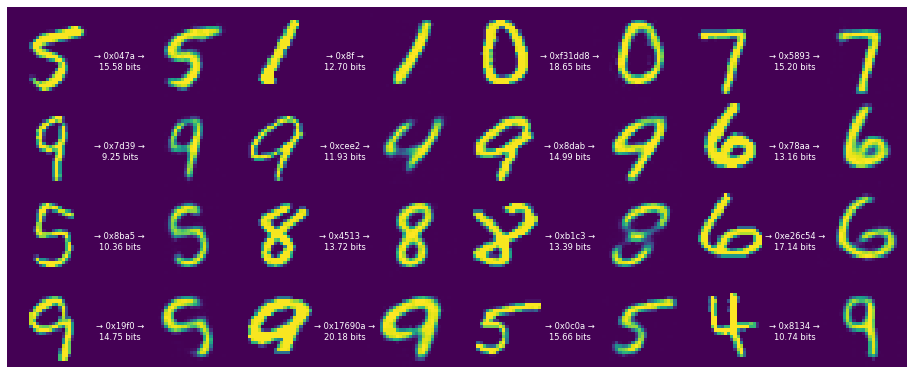

In [25]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

train_and_visualize_model(lmbda=500)


The bit rate of our code goes down, as does the fidelity of the digits. However, most of the digits remain recognizable.

Let's reduce $\lambda$ further.

Epoch 1/15


  1/469 [..............................] - ETA: 8:00 - loss: 140.4422 - distortion_loss: 0.1249 - rate_loss: 102.9685 - distortion_pass_through_loss: 0.1249 - rate_pass_through_loss: 102.9685

 11/469 [..............................] - ETA: 2s - loss: 142.2881 - distortion_loss: 0.1323 - rate_loss: 102.5861 - distortion_pass_through_loss: 0.1323 - rate_pass_through_loss: 102.5861  

 21/469 [>.............................] - ETA: 2s - loss: 141.5012 - distortion_loss: 0.1309 - rate_loss: 102.2441 - distortion_pass_through_loss: 0.1309 - rate_pass_through_loss: 102.2441

 32/469 [=>............................] - ETA: 2s - loss: 140.6052 - distortion_loss: 0.1290 - rate_loss: 101.9185 - distortion_pass_through_loss: 0.1290 - rate_pass_through_loss: 101.9185

 43/469 [=>............................] - ETA: 2s - loss: 139.5910 - distortion_loss: 0.1267 - rate_loss: 101.5859 - distortion_pass_through_loss: 0.1267 - rate_pass_through_loss: 101.5859

 53/469 [==>...........................] - ETA: 2s - loss: 138.8537 - distortion_loss: 0.1252 - rate_loss: 101.3012 - distortion_pass_through_loss: 0.1252 - rate_pass_through_loss: 101.3012

 63/469 [===>..........................] - ETA: 2s - loss: 137.9667 - distortion_loss: 0.1229 - rate_loss: 101.0959 - distortion_pass_through_loss: 0.1229 - rate_pass_through_loss: 101.0959

 73/469 [===>..........................] - ETA: 2s - loss: 136.9146 - distortion_loss: 0.1202 - rate_loss: 100.8655 - distortion_pass_through_loss: 0.1202 - rate_pass_through_loss: 100.8655

 84/469 [====>.........................] - ETA: 1s - loss: 135.7333 - distortion_loss: 0.1170 - rate_loss: 100.6190 - distortion_pass_through_loss: 0.1170 - rate_pass_through_loss: 100.6190

 95/469 [=====>........................] - ETA: 1s - loss: 134.5237 - distortion_loss: 0.1138 - rate_loss: 100.3919 - distortion_pass_through_loss: 0.1138 - rate_pass_through_loss: 100.3919

106/469 [=====>........................] - ETA: 1s - loss: 133.3995 - distortion_loss: 0.1108 - rate_loss: 100.1525 - distortion_pass_through_loss: 0.1108 - rate_pass_through_loss: 100.1525

117/469 [======>.......................] - ETA: 1s - loss: 132.3469 - distortion_loss: 0.1081 - rate_loss: 99.9087 - distortion_pass_through_loss: 0.1081 - rate_pass_through_loss: 99.9087  

128/469 [=======>......................] - ETA: 1s - loss: 131.3291 - distortion_loss: 0.1055 - rate_loss: 99.6690 - distortion_pass_through_loss: 0.1055 - rate_pass_through_loss: 99.6690

139/469 [=======>......................] - ETA: 1s - loss: 130.3898 - distortion_loss: 0.1032 - rate_loss: 99.4171 - distortion_pass_through_loss: 0.1032 - rate_pass_through_loss: 99.4171

150/469 [========>.....................] - ETA: 1s - loss: 129.5167 - distortion_loss: 0.1012 - rate_loss: 99.1646 - distortion_pass_through_loss: 0.1012 - rate_pass_through_loss: 99.1646

161/469 [=========>....................] - ETA: 1s - loss: 128.7114 - distortion_loss: 0.0993 - rate_loss: 98.9179 - distortion_pass_through_loss: 0.0993 - rate_pass_through_loss: 98.9179

172/469 [==========>...................] - ETA: 1s - loss: 127.9207 - distortion_loss: 0.0976 - rate_loss: 98.6520 - distortion_pass_through_loss: 0.0976 - rate_pass_through_loss: 98.6520

183/469 [==========>...................] - ETA: 1s - loss: 127.1907 - distortion_loss: 0.0960 - rate_loss: 98.3911 - distortion_pass_through_loss: 0.0960 - rate_pass_through_loss: 98.3911

194/469 [===========>..................] - ETA: 1s - loss: 126.4857 - distortion_loss: 0.0945 - rate_loss: 98.1260 - distortion_pass_through_loss: 0.0945 - rate_pass_through_loss: 98.1260

205/469 [============>.................] - ETA: 1s - loss: 125.7936 - distortion_loss: 0.0931 - rate_loss: 97.8546 - distortion_pass_through_loss: 0.0931 - rate_pass_through_loss: 97.8546

216/469 [============>.................] - ETA: 1s - loss: 125.1224 - distortion_loss: 0.0918 - rate_loss: 97.5861 - distortion_pass_through_loss: 0.0918 - rate_pass_through_loss: 97.5861

227/469 [=============>................] - ETA: 1s - loss: 124.4821 - distortion_loss: 0.0906 - rate_loss: 97.3113 - distortion_pass_through_loss: 0.0906 - rate_pass_through_loss: 97.3113

238/469 [==============>...............] - ETA: 1s - loss: 123.8772 - distortion_loss: 0.0895 - rate_loss: 97.0368 - distortion_pass_through_loss: 0.0895 - rate_pass_through_loss: 97.0368

249/469 [==============>...............] - ETA: 1s - loss: 123.2912 - distortion_loss: 0.0884 - rate_loss: 96.7576 - distortion_pass_through_loss: 0.0884 - rate_pass_through_loss: 96.7576

260/469 [===============>..............] - ETA: 1s - loss: 122.7117 - distortion_loss: 0.0874 - rate_loss: 96.4768 - distortion_pass_through_loss: 0.0874 - rate_pass_through_loss: 96.4768

271/469 [================>.............] - ETA: 0s - loss: 122.1504 - distortion_loss: 0.0865 - rate_loss: 96.1962 - distortion_pass_through_loss: 0.0865 - rate_pass_through_loss: 96.1962

282/469 [=================>............] - ETA: 0s - loss: 121.6096 - distortion_loss: 0.0857 - rate_loss: 95.9134 - distortion_pass_through_loss: 0.0857 - rate_pass_through_loss: 95.9134

293/469 [=================>............] - ETA: 0s - loss: 121.0847 - distortion_loss: 0.0848 - rate_loss: 95.6305 - distortion_pass_through_loss: 0.0848 - rate_pass_through_loss: 95.6305

304/469 [==================>...........] - ETA: 0s - loss: 120.5613 - distortion_loss: 0.0841 - rate_loss: 95.3457 - distortion_pass_through_loss: 0.0841 - rate_pass_through_loss: 95.3457

315/469 [===================>..........] - ETA: 0s - loss: 120.0659 - distortion_loss: 0.0834 - rate_loss: 95.0603 - distortion_pass_through_loss: 0.0834 - rate_pass_through_loss: 95.0603

326/469 [===================>..........] - ETA: 0s - loss: 119.5722 - distortion_loss: 0.0827 - rate_loss: 94.7722 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 94.7722

337/469 [====================>.........] - ETA: 0s - loss: 119.0852 - distortion_loss: 0.0820 - rate_loss: 94.4850 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 94.4850

348/469 [=====================>........] - ETA: 0s - loss: 118.6084 - distortion_loss: 0.0814 - rate_loss: 94.1964 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 94.1964

359/469 [=====================>........] - ETA: 0s - loss: 118.1491 - distortion_loss: 0.0808 - rate_loss: 93.9052 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 93.9052

370/469 [======================>.......] - ETA: 0s - loss: 117.6983 - distortion_loss: 0.0803 - rate_loss: 93.6163 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 93.6163

381/469 [=======================>......] - ETA: 0s - loss: 117.2452 - distortion_loss: 0.0797 - rate_loss: 93.3258 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 93.3258

392/469 [========================>.....] - ETA: 0s - loss: 116.8009 - distortion_loss: 0.0792 - rate_loss: 93.0358 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 93.0358

403/469 [========================>.....] - ETA: 0s - loss: 116.3564 - distortion_loss: 0.0787 - rate_loss: 92.7453 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 92.7453

414/469 [=========================>....] - ETA: 0s - loss: 115.9333 - distortion_loss: 0.0783 - rate_loss: 92.4554 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 92.4554

425/469 [==========================>...] - ETA: 0s - loss: 115.5047 - distortion_loss: 0.0778 - rate_loss: 92.1648 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 92.1648

436/469 [==========================>...] - ETA: 0s - loss: 115.0882 - distortion_loss: 0.0774 - rate_loss: 91.8729 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 91.8729

447/469 [===========================>..] - ETA: 0s - loss: 114.6798 - distortion_loss: 0.0770 - rate_loss: 91.5825 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 91.5825

458/469 [============================>.] - ETA: 0s - loss: 114.2690 - distortion_loss: 0.0766 - rate_loss: 91.2931 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 91.2931

469/469 [==============================] - ETA: 0s - loss: 113.8783 - distortion_loss: 0.0762 - rate_loss: 91.0098 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 91.0032

469/469 [==============================] - 4s 6ms/step - loss: 113.8783 - distortion_loss: 0.0762 - rate_loss: 91.0098 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 91.0032 - val_loss: 96.7003 - val_distortion_loss: 0.0691 - val_rate_loss: 75.9582 - val_distortion_pass_through_loss: 0.0691 - val_rate_pass_through_loss: 75.9580


Epoch 2/15


  1/469 [..............................] - ETA: 3s - loss: 95.8749 - distortion_loss: 0.0581 - rate_loss: 78.4440 - distortion_pass_through_loss: 0.0581 - rate_pass_through_loss: 78.4440

 11/469 [..............................] - ETA: 2s - loss: 96.7507 - distortion_loss: 0.0613 - rate_loss: 78.3561 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 78.3561

 21/469 [>.............................] - ETA: 2s - loss: 96.5223 - distortion_loss: 0.0614 - rate_loss: 78.1101 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 78.1101

 32/469 [=>............................] - ETA: 2s - loss: 96.1505 - distortion_loss: 0.0611 - rate_loss: 77.8107 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 77.8107

 43/469 [=>............................] - ETA: 2s - loss: 95.8195 - distortion_loss: 0.0609 - rate_loss: 77.5398 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 77.5398

 54/469 [==>...........................] - ETA: 2s - loss: 95.5441 - distortion_loss: 0.0609 - rate_loss: 77.2610 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 77.2610

 64/469 [===>..........................] - ETA: 2s - loss: 95.3250 - distortion_loss: 0.0611 - rate_loss: 77.0052 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 77.0052

 74/469 [===>..........................] - ETA: 1s - loss: 95.0235 - distortion_loss: 0.0609 - rate_loss: 76.7676 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 76.7676

 84/469 [====>.........................] - ETA: 1s - loss: 94.7429 - distortion_loss: 0.0608 - rate_loss: 76.5025 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 76.5025

 95/469 [=====>........................] - ETA: 1s - loss: 94.4217 - distortion_loss: 0.0607 - rate_loss: 76.2218 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.2218

106/469 [=====>........................] - ETA: 1s - loss: 94.1271 - distortion_loss: 0.0606 - rate_loss: 75.9415 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 75.9415

117/469 [======>.......................] - ETA: 1s - loss: 93.8474 - distortion_loss: 0.0606 - rate_loss: 75.6758 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 75.6758

127/469 [=======>......................] - ETA: 1s - loss: 93.5675 - distortion_loss: 0.0605 - rate_loss: 75.4279 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 75.4279

138/469 [=======>......................] - ETA: 1s - loss: 93.2650 - distortion_loss: 0.0604 - rate_loss: 75.1488 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.1488

149/469 [========>.....................] - ETA: 1s - loss: 93.0017 - distortion_loss: 0.0604 - rate_loss: 74.8767 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 74.8767

160/469 [=========>....................] - ETA: 1s - loss: 92.7588 - distortion_loss: 0.0605 - rate_loss: 74.6114 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.6114

171/469 [=========>....................] - ETA: 1s - loss: 92.4903 - distortion_loss: 0.0605 - rate_loss: 74.3353 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.3353

182/469 [==========>...................] - ETA: 1s - loss: 92.2313 - distortion_loss: 0.0605 - rate_loss: 74.0669 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.0669

193/469 [===========>..................] - ETA: 1s - loss: 91.9902 - distortion_loss: 0.0606 - rate_loss: 73.8044 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.8044

204/469 [============>.................] - ETA: 1s - loss: 91.7136 - distortion_loss: 0.0606 - rate_loss: 73.5353 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.5353

215/469 [============>.................] - ETA: 1s - loss: 91.4347 - distortion_loss: 0.0606 - rate_loss: 73.2659 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.2659

225/469 [=============>................] - ETA: 1s - loss: 91.1878 - distortion_loss: 0.0606 - rate_loss: 73.0226 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.0226

236/469 [==============>...............] - ETA: 1s - loss: 90.9400 - distortion_loss: 0.0606 - rate_loss: 72.7618 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.7618

247/469 [==============>...............] - ETA: 1s - loss: 90.6864 - distortion_loss: 0.0606 - rate_loss: 72.4973 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.4973

258/469 [===============>..............] - ETA: 1s - loss: 90.4337 - distortion_loss: 0.0606 - rate_loss: 72.2406 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.2406

269/469 [================>.............] - ETA: 0s - loss: 90.1756 - distortion_loss: 0.0606 - rate_loss: 71.9822 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.9822

280/469 [================>.............] - ETA: 0s - loss: 89.9123 - distortion_loss: 0.0606 - rate_loss: 71.7194 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.7194

291/469 [=================>............] - ETA: 0s - loss: 89.6626 - distortion_loss: 0.0607 - rate_loss: 71.4632 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.4632

302/469 [==================>...........] - ETA: 0s - loss: 89.4045 - distortion_loss: 0.0607 - rate_loss: 71.2065 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.2065

313/469 [===================>..........] - ETA: 0s - loss: 89.1579 - distortion_loss: 0.0607 - rate_loss: 70.9511 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.9511

324/469 [===================>..........] - ETA: 0s - loss: 88.9117 - distortion_loss: 0.0607 - rate_loss: 70.6973 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.6973

335/469 [====================>.........] - ETA: 0s - loss: 88.6700 - distortion_loss: 0.0607 - rate_loss: 70.4474 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.4474

346/469 [=====================>........] - ETA: 0s - loss: 88.4202 - distortion_loss: 0.0608 - rate_loss: 70.1948 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 70.1948

357/469 [=====================>........] - ETA: 0s - loss: 88.1806 - distortion_loss: 0.0608 - rate_loss: 69.9473 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.9473

368/469 [======================>.......] - ETA: 0s - loss: 87.9396 - distortion_loss: 0.0608 - rate_loss: 69.6986 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.6986

379/469 [=======================>......] - ETA: 0s - loss: 87.6967 - distortion_loss: 0.0608 - rate_loss: 69.4495 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.4495

390/469 [=======================>......] - ETA: 0s - loss: 87.4576 - distortion_loss: 0.0609 - rate_loss: 69.2010 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 69.2010

401/469 [========================>.....] - ETA: 0s - loss: 87.2186 - distortion_loss: 0.0609 - rate_loss: 68.9518 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.9518

412/469 [=========================>....] - ETA: 0s - loss: 86.9807 - distortion_loss: 0.0609 - rate_loss: 68.7089 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.7089

423/469 [==========================>...] - ETA: 0s - loss: 86.7466 - distortion_loss: 0.0609 - rate_loss: 68.4654 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.4654

434/469 [==========================>...] - ETA: 0s - loss: 86.5159 - distortion_loss: 0.0610 - rate_loss: 68.2254 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 68.2254

445/469 [===========================>..] - ETA: 0s - loss: 86.2838 - distortion_loss: 0.0610 - rate_loss: 67.9848 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.9848

456/469 [============================>.] - ETA: 0s - loss: 86.0515 - distortion_loss: 0.0610 - rate_loss: 67.7430 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.7430

467/469 [============================>.] - ETA: 0s - loss: 85.8250 - distortion_loss: 0.0611 - rate_loss: 67.5075 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 67.5075

469/469 [==============================] - 2s 5ms/step - loss: 85.7851 - distortion_loss: 0.0611 - rate_loss: 67.4697 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.4642 - val_loss: 73.7545 - val_distortion_loss: 0.0759 - val_rate_loss: 50.9975 - val_distortion_pass_through_loss: 0.0759 - val_rate_pass_through_loss: 50.9936


Epoch 3/15


  1/469 [..............................] - ETA: 4s - loss: 74.7099 - distortion_loss: 0.0592 - rate_loss: 56.9369 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 56.9369

 12/469 [..............................] - ETA: 2s - loss: 75.9997 - distortion_loss: 0.0628 - rate_loss: 57.1584 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 57.1584

 23/469 [>.............................] - ETA: 2s - loss: 75.7138 - distortion_loss: 0.0626 - rate_loss: 56.9251 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.9251

 34/469 [=>............................] - ETA: 2s - loss: 75.5207 - distortion_loss: 0.0627 - rate_loss: 56.7061 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.7061

 45/469 [=>............................] - ETA: 2s - loss: 75.2794 - distortion_loss: 0.0626 - rate_loss: 56.4949 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.4949

 56/469 [==>...........................] - ETA: 1s - loss: 75.1372 - distortion_loss: 0.0628 - rate_loss: 56.2926 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.2926

 67/469 [===>..........................] - ETA: 1s - loss: 74.9994 - distortion_loss: 0.0629 - rate_loss: 56.1228 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.1228

 78/469 [===>..........................] - ETA: 1s - loss: 74.7877 - distortion_loss: 0.0629 - rate_loss: 55.9278 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.9278

 89/469 [====>.........................] - ETA: 1s - loss: 74.5783 - distortion_loss: 0.0629 - rate_loss: 55.7211 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 55.7211

100/469 [=====>........................] - ETA: 1s - loss: 74.3509 - distortion_loss: 0.0628 - rate_loss: 55.5117 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.5117

111/469 [======>.......................] - ETA: 1s - loss: 74.1394 - distortion_loss: 0.0628 - rate_loss: 55.3007 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.3007

122/469 [======>.......................] - ETA: 1s - loss: 73.9472 - distortion_loss: 0.0628 - rate_loss: 55.0967 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.0967

133/469 [=======>......................] - ETA: 1s - loss: 73.7035 - distortion_loss: 0.0628 - rate_loss: 54.8721 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.8721

144/469 [========>.....................] - ETA: 1s - loss: 73.5134 - distortion_loss: 0.0628 - rate_loss: 54.6718 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.6718

155/469 [========>.....................] - ETA: 1s - loss: 73.3501 - distortion_loss: 0.0629 - rate_loss: 54.4877 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.4877

166/469 [=========>....................] - ETA: 1s - loss: 73.1758 - distortion_loss: 0.0630 - rate_loss: 54.2904 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.2904

177/469 [==========>...................] - ETA: 1s - loss: 73.0079 - distortion_loss: 0.0630 - rate_loss: 54.1046 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.1046

188/469 [===========>..................] - ETA: 1s - loss: 72.8340 - distortion_loss: 0.0631 - rate_loss: 53.9136 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.9136

199/469 [===========>..................] - ETA: 1s - loss: 72.6716 - distortion_loss: 0.0631 - rate_loss: 53.7273 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.7273

210/469 [============>.................] - ETA: 1s - loss: 72.4826 - distortion_loss: 0.0631 - rate_loss: 53.5376 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.5376

221/469 [=============>................] - ETA: 1s - loss: 72.3113 - distortion_loss: 0.0632 - rate_loss: 53.3511 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.3511

232/469 [=============>................] - ETA: 1s - loss: 72.1411 - distortion_loss: 0.0633 - rate_loss: 53.1601 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.1601

243/469 [==============>...............] - ETA: 1s - loss: 71.9627 - distortion_loss: 0.0633 - rate_loss: 52.9748 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 52.9748

254/469 [===============>..............] - ETA: 1s - loss: 71.8055 - distortion_loss: 0.0634 - rate_loss: 52.7901 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.7901

265/469 [===============>..............] - ETA: 0s - loss: 71.6417 - distortion_loss: 0.0635 - rate_loss: 52.6058 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.6058

276/469 [================>.............] - ETA: 0s - loss: 71.4762 - distortion_loss: 0.0635 - rate_loss: 52.4224 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.4224

287/469 [=================>............] - ETA: 0s - loss: 71.3178 - distortion_loss: 0.0636 - rate_loss: 52.2509 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.2509

298/469 [==================>...........] - ETA: 0s - loss: 71.1423 - distortion_loss: 0.0636 - rate_loss: 52.0716 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.0716

309/469 [==================>...........] - ETA: 0s - loss: 70.9867 - distortion_loss: 0.0636 - rate_loss: 51.8948 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 51.8948

320/469 [===================>..........] - ETA: 0s - loss: 70.8275 - distortion_loss: 0.0637 - rate_loss: 51.7201 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.7201

331/469 [====================>.........] - ETA: 0s - loss: 70.6703 - distortion_loss: 0.0638 - rate_loss: 51.5416 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.5416

342/469 [====================>.........] - ETA: 0s - loss: 70.5199 - distortion_loss: 0.0638 - rate_loss: 51.3690 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.3690

353/469 [=====================>........] - ETA: 0s - loss: 70.3577 - distortion_loss: 0.0639 - rate_loss: 51.1956 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.1956

364/469 [======================>.......] - ETA: 0s - loss: 70.2008 - distortion_loss: 0.0639 - rate_loss: 51.0237 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.0237

375/469 [======================>.......] - ETA: 0s - loss: 70.0443 - distortion_loss: 0.0640 - rate_loss: 50.8481 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.8481

386/469 [=======================>......] - ETA: 0s - loss: 69.8908 - distortion_loss: 0.0640 - rate_loss: 50.6786 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 50.6786

397/469 [========================>.....] - ETA: 0s - loss: 69.7354 - distortion_loss: 0.0641 - rate_loss: 50.5091 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.5091

408/469 [=========================>....] - ETA: 0s - loss: 69.5704 - distortion_loss: 0.0641 - rate_loss: 50.3372 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.3372

419/469 [=========================>....] - ETA: 0s - loss: 69.4265 - distortion_loss: 0.0642 - rate_loss: 50.1760 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.1760

430/469 [==========================>...] - ETA: 0s - loss: 69.2815 - distortion_loss: 0.0642 - rate_loss: 50.0138 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.0138

441/469 [===========================>..] - ETA: 0s - loss: 69.1293 - distortion_loss: 0.0643 - rate_loss: 49.8434 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.8434

452/469 [===========================>..] - ETA: 0s - loss: 68.9780 - distortion_loss: 0.0643 - rate_loss: 49.6811 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.6811

463/469 [============================>.] - ETA: 0s - loss: 68.8349 - distortion_loss: 0.0644 - rate_loss: 49.5179 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.5179

469/469 [==============================] - 2s 5ms/step - loss: 68.7572 - distortion_loss: 0.0644 - rate_loss: 49.4336 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.4297 - val_loss: 58.1989 - val_distortion_loss: 0.0892 - val_rate_loss: 31.4509 - val_distortion_pass_through_loss: 0.0891 - val_rate_pass_through_loss: 31.4538


Epoch 4/15


  1/469 [..............................] - ETA: 3s - loss: 61.0042 - distortion_loss: 0.0623 - rate_loss: 42.3041 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 42.3041

 12/469 [..............................] - ETA: 2s - loss: 62.3241 - distortion_loss: 0.0667 - rate_loss: 42.3150 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 42.3150

 22/469 [>.............................] - ETA: 2s - loss: 62.2676 - distortion_loss: 0.0669 - rate_loss: 42.2089 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.2089

 33/469 [=>............................] - ETA: 2s - loss: 62.1977 - distortion_loss: 0.0669 - rate_loss: 42.1210 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 42.1210

 44/469 [=>............................] - ETA: 2s - loss: 62.0266 - distortion_loss: 0.0669 - rate_loss: 41.9687 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 41.9687

 55/469 [==>...........................] - ETA: 2s - loss: 61.9194 - distortion_loss: 0.0669 - rate_loss: 41.8577 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 41.8577

 66/469 [===>..........................] - ETA: 1s - loss: 61.8604 - distortion_loss: 0.0671 - rate_loss: 41.7445 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 41.7445

 77/469 [===>..........................] - ETA: 1s - loss: 61.7267 - distortion_loss: 0.0670 - rate_loss: 41.6137 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 41.6137

 87/469 [====>.........................] - ETA: 1s - loss: 61.6373 - distortion_loss: 0.0671 - rate_loss: 41.4999 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 41.4999

 98/469 [=====>........................] - ETA: 1s - loss: 61.5006 - distortion_loss: 0.0671 - rate_loss: 41.3789 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 41.3789

108/469 [=====>........................] - ETA: 1s - loss: 61.3979 - distortion_loss: 0.0671 - rate_loss: 41.2545 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 41.2545

119/469 [======>.......................] - ETA: 1s - loss: 61.3012 - distortion_loss: 0.0672 - rate_loss: 41.1303 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 41.1303

129/469 [=======>......................] - ETA: 1s - loss: 61.1613 - distortion_loss: 0.0671 - rate_loss: 41.0173 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 41.0173

140/469 [=======>......................] - ETA: 1s - loss: 61.0545 - distortion_loss: 0.0672 - rate_loss: 40.8961 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 40.8961

151/469 [========>.....................] - ETA: 1s - loss: 60.9484 - distortion_loss: 0.0673 - rate_loss: 40.7713 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.7713

161/469 [=========>....................] - ETA: 1s - loss: 60.8590 - distortion_loss: 0.0673 - rate_loss: 40.6649 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 40.6649

171/469 [=========>....................] - ETA: 1s - loss: 60.7654 - distortion_loss: 0.0674 - rate_loss: 40.5462 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 40.5462

182/469 [==========>...................] - ETA: 1s - loss: 60.6714 - distortion_loss: 0.0675 - rate_loss: 40.4279 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.4279

193/469 [===========>..................] - ETA: 1s - loss: 60.5819 - distortion_loss: 0.0676 - rate_loss: 40.3080 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.3080

203/469 [===========>..................] - ETA: 1s - loss: 60.4775 - distortion_loss: 0.0676 - rate_loss: 40.1924 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.1924

213/469 [============>.................] - ETA: 1s - loss: 60.3729 - distortion_loss: 0.0676 - rate_loss: 40.0802 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.0802

224/469 [=============>................] - ETA: 1s - loss: 60.2583 - distortion_loss: 0.0677 - rate_loss: 39.9623 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 39.9623

234/469 [=============>................] - ETA: 1s - loss: 60.1794 - distortion_loss: 0.0677 - rate_loss: 39.8568 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 39.8568

244/469 [==============>...............] - ETA: 1s - loss: 60.0685 - distortion_loss: 0.0677 - rate_loss: 39.7455 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 39.7455

255/469 [===============>..............] - ETA: 1s - loss: 59.9795 - distortion_loss: 0.0678 - rate_loss: 39.6298 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 39.6298

266/469 [================>.............] - ETA: 1s - loss: 59.8834 - distortion_loss: 0.0679 - rate_loss: 39.5137 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.5137

277/469 [================>.............] - ETA: 0s - loss: 59.7906 - distortion_loss: 0.0680 - rate_loss: 39.4048 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.4048

288/469 [=================>............] - ETA: 0s - loss: 59.7007 - distortion_loss: 0.0680 - rate_loss: 39.2926 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.2926

298/469 [==================>...........] - ETA: 0s - loss: 59.6021 - distortion_loss: 0.0680 - rate_loss: 39.1918 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.1918

309/469 [==================>...........] - ETA: 0s - loss: 59.5078 - distortion_loss: 0.0681 - rate_loss: 39.0814 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.0814

319/469 [===================>..........] - ETA: 0s - loss: 59.4250 - distortion_loss: 0.0682 - rate_loss: 38.9760 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 38.9760

330/469 [====================>.........] - ETA: 0s - loss: 59.3338 - distortion_loss: 0.0683 - rate_loss: 38.8581 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.8581

341/469 [====================>.........] - ETA: 0s - loss: 59.2377 - distortion_loss: 0.0683 - rate_loss: 38.7483 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.7483

352/469 [=====================>........] - ETA: 0s - loss: 59.1416 - distortion_loss: 0.0683 - rate_loss: 38.6384 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 38.6384

363/469 [======================>.......] - ETA: 0s - loss: 59.0504 - distortion_loss: 0.0684 - rate_loss: 38.5264 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 38.5264

373/469 [======================>.......] - ETA: 0s - loss: 58.9658 - distortion_loss: 0.0685 - rate_loss: 38.4266 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.4266

384/469 [=======================>......] - ETA: 0s - loss: 58.8755 - distortion_loss: 0.0685 - rate_loss: 38.3201 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.3201

395/469 [========================>.....] - ETA: 0s - loss: 58.7838 - distortion_loss: 0.0686 - rate_loss: 38.2141 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.2141

406/469 [========================>.....] - ETA: 0s - loss: 58.6803 - distortion_loss: 0.0686 - rate_loss: 38.1034 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.1034

417/469 [=========================>....] - ETA: 0s - loss: 58.5977 - distortion_loss: 0.0687 - rate_loss: 38.0021 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.0021

428/469 [==========================>...] - ETA: 0s - loss: 58.5101 - distortion_loss: 0.0687 - rate_loss: 37.8945 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 37.8945

439/469 [===========================>..] - ETA: 0s - loss: 58.4186 - distortion_loss: 0.0688 - rate_loss: 37.7863 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.7863

450/469 [===========================>..] - ETA: 0s - loss: 58.3296 - distortion_loss: 0.0688 - rate_loss: 37.6804 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 37.6804

461/469 [============================>.] - ETA: 0s - loss: 58.2430 - distortion_loss: 0.0689 - rate_loss: 37.5783 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.5783

469/469 [==============================] - 2s 5ms/step - loss: 58.1805 - distortion_loss: 0.0689 - rate_loss: 37.5008 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 37.4983 - val_loss: 48.3966 - val_distortion_loss: 0.0972 - val_rate_loss: 19.2390 - val_distortion_pass_through_loss: 0.0972 - val_rate_pass_through_loss: 19.2377


Epoch 5/15


  1/469 [..............................] - ETA: 3s - loss: 52.5671 - distortion_loss: 0.0658 - rate_loss: 32.8307 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 32.8307

 11/469 [..............................] - ETA: 2s - loss: 54.3947 - distortion_loss: 0.0713 - rate_loss: 32.9904 - distortion_pass_through_loss: 0.0713 - rate_pass_through_loss: 32.9904

 22/469 [>.............................] - ETA: 2s - loss: 54.4449 - distortion_loss: 0.0716 - rate_loss: 32.9567 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.9567

 33/469 [=>............................] - ETA: 2s - loss: 54.3664 - distortion_loss: 0.0717 - rate_loss: 32.8522 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.8522

 43/469 [=>............................] - ETA: 2s - loss: 54.2497 - distortion_loss: 0.0716 - rate_loss: 32.7636 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.7636

 53/469 [==>...........................] - ETA: 2s - loss: 54.2315 - distortion_loss: 0.0718 - rate_loss: 32.7055 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.7055

 63/469 [===>..........................] - ETA: 2s - loss: 54.1746 - distortion_loss: 0.0718 - rate_loss: 32.6434 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.6434

 73/469 [===>..........................] - ETA: 2s - loss: 54.0903 - distortion_loss: 0.0717 - rate_loss: 32.5775 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.5775

 83/469 [====>.........................] - ETA: 1s - loss: 54.0240 - distortion_loss: 0.0717 - rate_loss: 32.5184 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.5184

 94/469 [=====>........................] - ETA: 1s - loss: 53.9412 - distortion_loss: 0.0718 - rate_loss: 32.4068 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4068

104/469 [=====>........................] - ETA: 1s - loss: 53.8556 - distortion_loss: 0.0718 - rate_loss: 32.3278 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3278

114/469 [======>.......................] - ETA: 1s - loss: 53.7921 - distortion_loss: 0.0718 - rate_loss: 32.2651 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.2651

124/469 [======>.......................] - ETA: 1s - loss: 53.7103 - distortion_loss: 0.0718 - rate_loss: 32.1784 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.1784

134/469 [=======>......................] - ETA: 1s - loss: 53.5992 - distortion_loss: 0.0717 - rate_loss: 32.0919 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.0919

144/469 [========>.....................] - ETA: 1s - loss: 53.5216 - distortion_loss: 0.0717 - rate_loss: 32.0184 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 32.0184

154/469 [========>.....................] - ETA: 1s - loss: 53.4939 - distortion_loss: 0.0717 - rate_loss: 31.9722 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 31.9722

164/469 [=========>....................] - ETA: 1s - loss: 53.4532 - distortion_loss: 0.0719 - rate_loss: 31.8970 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.8970

174/469 [==========>...................] - ETA: 1s - loss: 53.3815 - distortion_loss: 0.0719 - rate_loss: 31.8138 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 31.8138

184/469 [==========>...................] - ETA: 1s - loss: 53.3432 - distortion_loss: 0.0720 - rate_loss: 31.7502 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.7502

195/469 [===========>..................] - ETA: 1s - loss: 53.2961 - distortion_loss: 0.0721 - rate_loss: 31.6808 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.6808

205/469 [============>.................] - ETA: 1s - loss: 53.2379 - distortion_loss: 0.0721 - rate_loss: 31.6163 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.6163

216/469 [============>.................] - ETA: 1s - loss: 53.1580 - distortion_loss: 0.0721 - rate_loss: 31.5346 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.5346

227/469 [=============>................] - ETA: 1s - loss: 53.0918 - distortion_loss: 0.0721 - rate_loss: 31.4598 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.4598

237/469 [==============>...............] - ETA: 1s - loss: 53.0509 - distortion_loss: 0.0722 - rate_loss: 31.4026 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.4026

247/469 [==============>...............] - ETA: 1s - loss: 53.0041 - distortion_loss: 0.0723 - rate_loss: 31.3239 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.3239

258/469 [===============>..............] - ETA: 1s - loss: 52.9491 - distortion_loss: 0.0723 - rate_loss: 31.2506 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.2506

269/469 [================>.............] - ETA: 1s - loss: 52.8925 - distortion_loss: 0.0724 - rate_loss: 31.1753 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.1753

280/469 [================>.............] - ETA: 0s - loss: 52.8376 - distortion_loss: 0.0724 - rate_loss: 31.1067 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.1067

291/469 [=================>............] - ETA: 0s - loss: 52.7976 - distortion_loss: 0.0725 - rate_loss: 31.0452 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.0452

302/469 [==================>...........] - ETA: 0s - loss: 52.7279 - distortion_loss: 0.0725 - rate_loss: 30.9636 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 30.9636

313/469 [===================>..........] - ETA: 0s - loss: 52.6740 - distortion_loss: 0.0726 - rate_loss: 30.8907 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 30.8907

324/469 [===================>..........] - ETA: 0s - loss: 52.6212 - distortion_loss: 0.0727 - rate_loss: 30.8227 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.8227

335/469 [====================>.........] - ETA: 0s - loss: 52.5652 - distortion_loss: 0.0727 - rate_loss: 30.7472 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.7472

346/469 [=====================>........] - ETA: 0s - loss: 52.5033 - distortion_loss: 0.0728 - rate_loss: 30.6733 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6733

357/469 [=====================>........] - ETA: 0s - loss: 52.4480 - distortion_loss: 0.0728 - rate_loss: 30.6080 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.6080

368/469 [======================>.......] - ETA: 0s - loss: 52.3953 - distortion_loss: 0.0729 - rate_loss: 30.5360 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.5360

379/469 [=======================>......] - ETA: 0s - loss: 52.3346 - distortion_loss: 0.0729 - rate_loss: 30.4665 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.4665

390/469 [=======================>......] - ETA: 0s - loss: 52.2757 - distortion_loss: 0.0729 - rate_loss: 30.3982 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.3982

400/469 [========================>.....] - ETA: 0s - loss: 52.2286 - distortion_loss: 0.0730 - rate_loss: 30.3385 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.3385

411/469 [=========================>....] - ETA: 0s - loss: 52.1671 - distortion_loss: 0.0730 - rate_loss: 30.2676 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.2676

421/469 [=========================>....] - ETA: 0s - loss: 52.1199 - distortion_loss: 0.0730 - rate_loss: 30.2089 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.2089

431/469 [==========================>...] - ETA: 0s - loss: 52.0760 - distortion_loss: 0.0731 - rate_loss: 30.1465 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.1465

442/469 [===========================>..] - ETA: 0s - loss: 52.0222 - distortion_loss: 0.0731 - rate_loss: 30.0772 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.0772

452/469 [===========================>..] - ETA: 0s - loss: 51.9768 - distortion_loss: 0.0732 - rate_loss: 30.0165 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.0165

463/469 [============================>.] - ETA: 0s - loss: 51.9241 - distortion_loss: 0.0732 - rate_loss: 29.9520 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 29.9520

469/469 [==============================] - 2s 5ms/step - loss: 51.8958 - distortion_loss: 0.0733 - rate_loss: 29.9187 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 29.9171 - val_loss: 42.3829 - val_distortion_loss: 0.1035 - val_rate_loss: 11.3228 - val_distortion_pass_through_loss: 0.1036 - val_rate_pass_through_loss: 11.3198


Epoch 6/15


  1/469 [..............................] - ETA: 3s - loss: 47.9136 - distortion_loss: 0.0712 - rate_loss: 26.5540 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 26.5540

 12/469 [..............................] - ETA: 2s - loss: 49.8021 - distortion_loss: 0.0752 - rate_loss: 27.2345 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 27.2345

 23/469 [>.............................] - ETA: 2s - loss: 49.6953 - distortion_loss: 0.0755 - rate_loss: 27.0347 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 27.0347

 34/469 [=>............................] - ETA: 2s - loss: 49.6830 - distortion_loss: 0.0757 - rate_loss: 26.9851 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.9851

 45/469 [=>............................] - ETA: 2s - loss: 49.5563 - distortion_loss: 0.0754 - rate_loss: 26.9330 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 26.9330

 56/469 [==>...........................] - ETA: 2s - loss: 49.5560 - distortion_loss: 0.0756 - rate_loss: 26.8748 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.8748

 67/469 [===>..........................] - ETA: 1s - loss: 49.5627 - distortion_loss: 0.0758 - rate_loss: 26.8199 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8199

 78/469 [===>..........................] - ETA: 1s - loss: 49.4796 - distortion_loss: 0.0757 - rate_loss: 26.7760 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.7760

 89/469 [====>.........................] - ETA: 1s - loss: 49.4048 - distortion_loss: 0.0756 - rate_loss: 26.7266 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.7266

100/469 [=====>........................] - ETA: 1s - loss: 49.3302 - distortion_loss: 0.0756 - rate_loss: 26.6471 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6471

111/469 [======>.......................] - ETA: 1s - loss: 49.2610 - distortion_loss: 0.0756 - rate_loss: 26.5894 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.5894

122/469 [======>.......................] - ETA: 1s - loss: 49.2012 - distortion_loss: 0.0756 - rate_loss: 26.5196 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.5196

132/469 [=======>......................] - ETA: 1s - loss: 49.1030 - distortion_loss: 0.0755 - rate_loss: 26.4594 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 26.4594

143/469 [========>.....................] - ETA: 1s - loss: 49.0356 - distortion_loss: 0.0754 - rate_loss: 26.4061 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 26.4061

154/469 [========>.....................] - ETA: 1s - loss: 49.0189 - distortion_loss: 0.0755 - rate_loss: 26.3609 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 26.3609

165/469 [=========>....................] - ETA: 1s - loss: 48.9984 - distortion_loss: 0.0756 - rate_loss: 26.3213 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.3213

176/469 [==========>...................] - ETA: 1s - loss: 48.9620 - distortion_loss: 0.0756 - rate_loss: 26.2693 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.2693

187/469 [==========>...................] - ETA: 1s - loss: 48.9315 - distortion_loss: 0.0757 - rate_loss: 26.2173 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.2173

198/469 [===========>..................] - ETA: 1s - loss: 48.9055 - distortion_loss: 0.0758 - rate_loss: 26.1737 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.1737

209/469 [============>.................] - ETA: 1s - loss: 48.8532 - distortion_loss: 0.0758 - rate_loss: 26.1143 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.1143

220/469 [=============>................] - ETA: 1s - loss: 48.8034 - distortion_loss: 0.0758 - rate_loss: 26.0652 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.0652

231/469 [=============>................] - ETA: 1s - loss: 48.7629 - distortion_loss: 0.0758 - rate_loss: 26.0189 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.0189

242/469 [==============>...............] - ETA: 1s - loss: 48.7214 - distortion_loss: 0.0759 - rate_loss: 25.9620 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 25.9620

253/469 [===============>..............] - ETA: 1s - loss: 48.6925 - distortion_loss: 0.0760 - rate_loss: 25.9045 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.9045

264/469 [===============>..............] - ETA: 0s - loss: 48.6470 - distortion_loss: 0.0760 - rate_loss: 25.8609 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.8609

275/469 [================>.............] - ETA: 0s - loss: 48.6143 - distortion_loss: 0.0760 - rate_loss: 25.8066 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.8066

286/469 [=================>............] - ETA: 0s - loss: 48.5962 - distortion_loss: 0.0761 - rate_loss: 25.7614 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.7614

297/469 [=================>............] - ETA: 0s - loss: 48.5429 - distortion_loss: 0.0761 - rate_loss: 25.7118 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.7118

308/469 [==================>...........] - ETA: 0s - loss: 48.5014 - distortion_loss: 0.0762 - rate_loss: 25.6515 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.6515

319/469 [===================>..........] - ETA: 0s - loss: 48.4582 - distortion_loss: 0.0762 - rate_loss: 25.5948 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.5948

330/469 [====================>.........] - ETA: 0s - loss: 48.4219 - distortion_loss: 0.0762 - rate_loss: 25.5490 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.5490

341/469 [====================>.........] - ETA: 0s - loss: 48.3815 - distortion_loss: 0.0763 - rate_loss: 25.4957 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.4957

352/469 [=====================>........] - ETA: 0s - loss: 48.3482 - distortion_loss: 0.0763 - rate_loss: 25.4482 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.4482

363/469 [======================>.......] - ETA: 0s - loss: 48.3088 - distortion_loss: 0.0763 - rate_loss: 25.4039 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.4039

374/469 [======================>.......] - ETA: 0s - loss: 48.2748 - distortion_loss: 0.0764 - rate_loss: 25.3561 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.3561

385/469 [=======================>......] - ETA: 0s - loss: 48.2393 - distortion_loss: 0.0765 - rate_loss: 25.3029 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.3029

396/469 [========================>.....] - ETA: 0s - loss: 48.2024 - distortion_loss: 0.0765 - rate_loss: 25.2565 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.2565

407/469 [=========================>....] - ETA: 0s - loss: 48.1537 - distortion_loss: 0.0765 - rate_loss: 25.2020 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.2020

418/469 [=========================>....] - ETA: 0s - loss: 48.1195 - distortion_loss: 0.0765 - rate_loss: 25.1568 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.1568

429/469 [==========================>...] - ETA: 0s - loss: 48.0867 - distortion_loss: 0.0766 - rate_loss: 25.1142 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.1142

440/469 [===========================>..] - ETA: 0s - loss: 48.0523 - distortion_loss: 0.0766 - rate_loss: 25.0655 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.0655

451/469 [===========================>..] - ETA: 0s - loss: 48.0179 - distortion_loss: 0.0767 - rate_loss: 25.0186 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.0186

462/469 [============================>.] - ETA: 0s - loss: 47.9855 - distortion_loss: 0.0767 - rate_loss: 24.9750 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 24.9750

469/469 [==============================] - 2s 5ms/step - loss: 47.9622 - distortion_loss: 0.0767 - rate_loss: 24.9413 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 24.9403 - val_loss: 38.2396 - val_distortion_loss: 0.0998 - val_rate_loss: 8.2981 - val_distortion_pass_through_loss: 0.0998 - val_rate_pass_through_loss: 8.2938


Epoch 7/15


  1/469 [..............................] - ETA: 3s - loss: 45.1332 - distortion_loss: 0.0733 - rate_loss: 23.1539 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 23.1539

 11/469 [..............................] - ETA: 2s - loss: 46.3648 - distortion_loss: 0.0780 - rate_loss: 22.9734 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 22.9734

 22/469 [>.............................] - ETA: 2s - loss: 46.4912 - distortion_loss: 0.0787 - rate_loss: 22.8929 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.8929

 33/469 [=>............................] - ETA: 2s - loss: 46.4662 - distortion_loss: 0.0786 - rate_loss: 22.8984 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8984

 44/469 [=>............................] - ETA: 2s - loss: 46.3834 - distortion_loss: 0.0786 - rate_loss: 22.8101 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8101

 55/469 [==>...........................] - ETA: 2s - loss: 46.3815 - distortion_loss: 0.0787 - rate_loss: 22.7669 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7669

 66/469 [===>..........................] - ETA: 1s - loss: 46.3727 - distortion_loss: 0.0787 - rate_loss: 22.7534 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7534

 77/469 [===>..........................] - ETA: 1s - loss: 46.3030 - distortion_loss: 0.0786 - rate_loss: 22.7083 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.7083

 88/469 [====>.........................] - ETA: 1s - loss: 46.2767 - distortion_loss: 0.0787 - rate_loss: 22.6722 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.6722

 99/469 [=====>........................] - ETA: 1s - loss: 46.2156 - distortion_loss: 0.0786 - rate_loss: 22.6466 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.6466

110/469 [======>.......................] - ETA: 1s - loss: 46.1716 - distortion_loss: 0.0786 - rate_loss: 22.5908 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5908

121/469 [======>.......................] - ETA: 1s - loss: 46.1276 - distortion_loss: 0.0786 - rate_loss: 22.5501 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5501

132/469 [=======>......................] - ETA: 1s - loss: 46.0516 - distortion_loss: 0.0785 - rate_loss: 22.5092 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.5092

143/469 [========>.....................] - ETA: 1s - loss: 46.0078 - distortion_loss: 0.0784 - rate_loss: 22.4810 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 22.4810

154/469 [========>.....................] - ETA: 1s - loss: 45.9966 - distortion_loss: 0.0785 - rate_loss: 22.4505 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.4505

165/469 [=========>....................] - ETA: 1s - loss: 45.9725 - distortion_loss: 0.0785 - rate_loss: 22.4201 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.4201

176/469 [==========>...................] - ETA: 1s - loss: 45.9364 - distortion_loss: 0.0785 - rate_loss: 22.3813 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.3813

187/469 [==========>...................] - ETA: 1s - loss: 45.9126 - distortion_loss: 0.0786 - rate_loss: 22.3463 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.3463

198/469 [===========>..................] - ETA: 1s - loss: 45.9039 - distortion_loss: 0.0787 - rate_loss: 22.3043 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.3043

209/469 [============>.................] - ETA: 1s - loss: 45.8598 - distortion_loss: 0.0787 - rate_loss: 22.2558 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.2558

220/469 [=============>................] - ETA: 1s - loss: 45.8206 - distortion_loss: 0.0786 - rate_loss: 22.2332 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.2332

231/469 [=============>................] - ETA: 1s - loss: 45.7919 - distortion_loss: 0.0787 - rate_loss: 22.1879 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.1879

242/469 [==============>...............] - ETA: 1s - loss: 45.7567 - distortion_loss: 0.0787 - rate_loss: 22.1492 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.1492

253/469 [===============>..............] - ETA: 1s - loss: 45.7333 - distortion_loss: 0.0788 - rate_loss: 22.1020 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.1020

264/469 [===============>..............] - ETA: 0s - loss: 45.7021 - distortion_loss: 0.0788 - rate_loss: 22.0669 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.0669

275/469 [================>.............] - ETA: 0s - loss: 45.6759 - distortion_loss: 0.0788 - rate_loss: 22.0278 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.0278

286/469 [=================>............] - ETA: 0s - loss: 45.6689 - distortion_loss: 0.0789 - rate_loss: 21.9949 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 21.9949

297/469 [=================>............] - ETA: 0s - loss: 45.6307 - distortion_loss: 0.0789 - rate_loss: 21.9575 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 21.9575

308/469 [==================>...........] - ETA: 0s - loss: 45.6133 - distortion_loss: 0.0790 - rate_loss: 21.9188 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 21.9188

319/469 [===================>..........] - ETA: 0s - loss: 45.5963 - distortion_loss: 0.0790 - rate_loss: 21.8826 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 21.8826

330/469 [====================>.........] - ETA: 0s - loss: 45.5761 - distortion_loss: 0.0791 - rate_loss: 21.8465 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 21.8465

341/469 [====================>.........] - ETA: 0s - loss: 45.5447 - distortion_loss: 0.0791 - rate_loss: 21.8081 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 21.8081

352/469 [=====================>........] - ETA: 0s - loss: 45.5127 - distortion_loss: 0.0791 - rate_loss: 21.7717 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 21.7717

363/469 [======================>.......] - ETA: 0s - loss: 45.4913 - distortion_loss: 0.0792 - rate_loss: 21.7391 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.7391

374/469 [======================>.......] - ETA: 0s - loss: 45.4662 - distortion_loss: 0.0792 - rate_loss: 21.7042 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.7042

385/469 [=======================>......] - ETA: 0s - loss: 45.4320 - distortion_loss: 0.0792 - rate_loss: 21.6713 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.6713

396/469 [========================>.....] - ETA: 0s - loss: 45.4020 - distortion_loss: 0.0792 - rate_loss: 21.6324 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.6324

407/469 [=========================>....] - ETA: 0s - loss: 45.3693 - distortion_loss: 0.0792 - rate_loss: 21.5975 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.5975

418/469 [=========================>....] - ETA: 0s - loss: 45.3484 - distortion_loss: 0.0793 - rate_loss: 21.5586 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.5586

429/469 [==========================>...] - ETA: 0s - loss: 45.3265 - distortion_loss: 0.0793 - rate_loss: 21.5262 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.5262

440/469 [===========================>..] - ETA: 0s - loss: 45.2968 - distortion_loss: 0.0794 - rate_loss: 21.4905 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.4905

451/469 [===========================>..] - ETA: 0s - loss: 45.2687 - distortion_loss: 0.0794 - rate_loss: 21.4532 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.4532

462/469 [============================>.] - ETA: 0s - loss: 45.2477 - distortion_loss: 0.0794 - rate_loss: 21.4209 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.4209

469/469 [==============================] - 2s 5ms/step - loss: 45.2256 - distortion_loss: 0.0794 - rate_loss: 21.3975 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.3967 - val_loss: 35.4203 - val_distortion_loss: 0.0951 - val_rate_loss: 6.8925 - val_distortion_pass_through_loss: 0.0951 - val_rate_pass_through_loss: 6.8879


Epoch 8/15


  1/469 [..............................] - ETA: 3s - loss: 42.5748 - distortion_loss: 0.0762 - rate_loss: 19.7018 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 19.7018

 12/469 [..............................] - ETA: 2s - loss: 44.2008 - distortion_loss: 0.0805 - rate_loss: 20.0542 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 20.0542

 23/469 [>.............................] - ETA: 2s - loss: 44.0464 - distortion_loss: 0.0804 - rate_loss: 19.9167 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 19.9167

 34/469 [=>............................] - ETA: 2s - loss: 44.0400 - distortion_loss: 0.0806 - rate_loss: 19.8601 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.8601

 45/469 [=>............................] - ETA: 2s - loss: 43.8552 - distortion_loss: 0.0801 - rate_loss: 19.8285 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 19.8285

 55/469 [==>...........................] - ETA: 2s - loss: 43.8575 - distortion_loss: 0.0802 - rate_loss: 19.7953 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 19.7953

 65/469 [===>..........................] - ETA: 2s - loss: 43.9016 - distortion_loss: 0.0804 - rate_loss: 19.7695 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 19.7695

 75/469 [===>..........................] - ETA: 1s - loss: 43.8535 - distortion_loss: 0.0804 - rate_loss: 19.7395 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 19.7395

 85/469 [====>.........................] - ETA: 1s - loss: 43.8664 - distortion_loss: 0.0804 - rate_loss: 19.7413 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 19.7413

 96/469 [=====>........................] - ETA: 1s - loss: 43.7964 - distortion_loss: 0.0803 - rate_loss: 19.7022 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 19.7022

107/469 [=====>........................] - ETA: 1s - loss: 43.7703 - distortion_loss: 0.0803 - rate_loss: 19.6798 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 19.6798

118/469 [======>.......................] - ETA: 1s - loss: 43.7207 - distortion_loss: 0.0803 - rate_loss: 19.6411 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 19.6411

129/469 [=======>......................] - ETA: 1s - loss: 43.6614 - distortion_loss: 0.0802 - rate_loss: 19.6033 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 19.6033

140/469 [=======>......................] - ETA: 1s - loss: 43.5927 - distortion_loss: 0.0801 - rate_loss: 19.5631 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 19.5631

151/469 [========>.....................] - ETA: 1s - loss: 43.5787 - distortion_loss: 0.0801 - rate_loss: 19.5443 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 19.5443

162/469 [=========>....................] - ETA: 1s - loss: 43.5728 - distortion_loss: 0.0802 - rate_loss: 19.5259 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 19.5259

173/469 [==========>...................] - ETA: 1s - loss: 43.5500 - distortion_loss: 0.0802 - rate_loss: 19.4893 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 19.4893

184/469 [==========>...................] - ETA: 1s - loss: 43.5448 - distortion_loss: 0.0803 - rate_loss: 19.4557 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 19.4557

195/469 [===========>..................] - ETA: 1s - loss: 43.5450 - distortion_loss: 0.0804 - rate_loss: 19.4319 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 19.4319

206/469 [============>.................] - ETA: 1s - loss: 43.5080 - distortion_loss: 0.0804 - rate_loss: 19.4013 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 19.4013

217/469 [============>.................] - ETA: 1s - loss: 43.4634 - distortion_loss: 0.0803 - rate_loss: 19.3619 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 19.3619

228/469 [=============>................] - ETA: 1s - loss: 43.4529 - distortion_loss: 0.0804 - rate_loss: 19.3353 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 19.3353

239/469 [==============>...............] - ETA: 1s - loss: 43.4351 - distortion_loss: 0.0804 - rate_loss: 19.3063 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 19.3063

250/469 [==============>...............] - ETA: 1s - loss: 43.4215 - distortion_loss: 0.0805 - rate_loss: 19.2808 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 19.2808

261/469 [===============>..............] - ETA: 1s - loss: 43.3976 - distortion_loss: 0.0805 - rate_loss: 19.2516 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 19.2516

272/469 [================>.............] - ETA: 0s - loss: 43.3769 - distortion_loss: 0.0805 - rate_loss: 19.2178 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 19.2178

283/469 [=================>............] - ETA: 0s - loss: 43.3713 - distortion_loss: 0.0806 - rate_loss: 19.1914 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.1914

294/469 [=================>............] - ETA: 0s - loss: 43.3461 - distortion_loss: 0.0806 - rate_loss: 19.1631 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.1631

305/469 [==================>...........] - ETA: 0s - loss: 43.3150 - distortion_loss: 0.0806 - rate_loss: 19.1397 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.1397

316/469 [===================>..........] - ETA: 0s - loss: 43.2981 - distortion_loss: 0.0806 - rate_loss: 19.1124 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.1124

327/469 [===================>..........] - ETA: 0s - loss: 43.2786 - distortion_loss: 0.0807 - rate_loss: 19.0823 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.0823

337/469 [====================>.........] - ETA: 0s - loss: 43.2606 - distortion_loss: 0.0807 - rate_loss: 19.0507 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.0507

347/469 [=====================>........] - ETA: 0s - loss: 43.2321 - distortion_loss: 0.0807 - rate_loss: 19.0290 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.0290

358/469 [=====================>........] - ETA: 0s - loss: 43.2169 - distortion_loss: 0.0807 - rate_loss: 19.0002 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.0002

368/469 [======================>.......] - ETA: 0s - loss: 43.2004 - distortion_loss: 0.0808 - rate_loss: 18.9738 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 18.9738

379/469 [=======================>......] - ETA: 0s - loss: 43.1733 - distortion_loss: 0.0808 - rate_loss: 18.9457 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 18.9457

390/469 [=======================>......] - ETA: 0s - loss: 43.1442 - distortion_loss: 0.0808 - rate_loss: 18.9117 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 18.9117

401/469 [========================>.....] - ETA: 0s - loss: 43.1171 - distortion_loss: 0.0808 - rate_loss: 18.8876 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 18.8876

412/469 [=========================>....] - ETA: 0s - loss: 43.0917 - distortion_loss: 0.0808 - rate_loss: 18.8604 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 18.8604

423/469 [==========================>...] - ETA: 0s - loss: 43.0669 - distortion_loss: 0.0808 - rate_loss: 18.8328 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 18.8328

434/469 [==========================>...] - ETA: 0s - loss: 43.0450 - distortion_loss: 0.0808 - rate_loss: 18.8019 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 18.8019

445/469 [===========================>..] - ETA: 0s - loss: 43.0207 - distortion_loss: 0.0808 - rate_loss: 18.7734 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 18.7734

456/469 [============================>.] - ETA: 0s - loss: 42.9996 - distortion_loss: 0.0808 - rate_loss: 18.7465 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 18.7465

467/469 [============================>.] - ETA: 0s - loss: 42.9843 - distortion_loss: 0.0809 - rate_loss: 18.7245 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 18.7245

469/469 [==============================] - 2s 5ms/step - loss: 42.9767 - distortion_loss: 0.0809 - rate_loss: 18.7189 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 18.7183 - val_loss: 34.1213 - val_distortion_loss: 0.0924 - val_rate_loss: 6.4127 - val_distortion_pass_through_loss: 0.0924 - val_rate_pass_through_loss: 6.4081


Epoch 9/15


  1/469 [..............................] - ETA: 3s - loss: 40.1908 - distortion_loss: 0.0769 - rate_loss: 17.1355 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 17.1355

 12/469 [..............................] - ETA: 2s - loss: 42.0458 - distortion_loss: 0.0817 - rate_loss: 17.5453 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5453

 23/469 [>.............................] - ETA: 2s - loss: 42.0268 - distortion_loss: 0.0818 - rate_loss: 17.4854 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.4854

 34/469 [=>............................] - ETA: 2s - loss: 42.0620 - distortion_loss: 0.0821 - rate_loss: 17.4388 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.4388

 45/469 [=>............................] - ETA: 2s - loss: 41.9505 - distortion_loss: 0.0817 - rate_loss: 17.4277 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.4277

 56/469 [==>...........................] - ETA: 2s - loss: 41.9489 - distortion_loss: 0.0818 - rate_loss: 17.4027 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.4027

 67/469 [===>..........................] - ETA: 1s - loss: 41.9886 - distortion_loss: 0.0821 - rate_loss: 17.3697 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.3697

 78/469 [===>..........................] - ETA: 1s - loss: 41.9055 - distortion_loss: 0.0818 - rate_loss: 17.3719 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.3719

 89/469 [====>.........................] - ETA: 1s - loss: 41.8708 - distortion_loss: 0.0817 - rate_loss: 17.3563 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.3563

100/469 [=====>........................] - ETA: 1s - loss: 41.8229 - distortion_loss: 0.0816 - rate_loss: 17.3529 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.3529

111/469 [======>.......................] - ETA: 1s - loss: 41.7618 - distortion_loss: 0.0815 - rate_loss: 17.3144 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.3144

122/469 [======>.......................] - ETA: 1s - loss: 41.7080 - distortion_loss: 0.0814 - rate_loss: 17.2994 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2994

133/469 [=======>......................] - ETA: 1s - loss: 41.6351 - distortion_loss: 0.0812 - rate_loss: 17.2782 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.2782

144/469 [========>.....................] - ETA: 1s - loss: 41.6065 - distortion_loss: 0.0811 - rate_loss: 17.2662 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 17.2662

155/469 [========>.....................] - ETA: 1s - loss: 41.6032 - distortion_loss: 0.0812 - rate_loss: 17.2411 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.2411

166/469 [=========>....................] - ETA: 1s - loss: 41.5839 - distortion_loss: 0.0812 - rate_loss: 17.2322 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.2322

177/469 [==========>...................] - ETA: 1s - loss: 41.5782 - distortion_loss: 0.0812 - rate_loss: 17.2231 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.2231

188/469 [===========>..................] - ETA: 1s - loss: 41.5616 - distortion_loss: 0.0812 - rate_loss: 17.1923 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.1923

199/469 [===========>..................] - ETA: 1s - loss: 41.5629 - distortion_loss: 0.0813 - rate_loss: 17.1818 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.1818

210/469 [============>.................] - ETA: 1s - loss: 41.5236 - distortion_loss: 0.0812 - rate_loss: 17.1492 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.1492

221/469 [=============>................] - ETA: 1s - loss: 41.5082 - distortion_loss: 0.0813 - rate_loss: 17.1255 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.1255

232/469 [=============>................] - ETA: 1s - loss: 41.4904 - distortion_loss: 0.0813 - rate_loss: 17.1023 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.1023

243/469 [==============>...............] - ETA: 1s - loss: 41.4557 - distortion_loss: 0.0813 - rate_loss: 17.0733 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.0733

254/469 [===============>..............] - ETA: 1s - loss: 41.4421 - distortion_loss: 0.0813 - rate_loss: 17.0508 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.0508

265/469 [===============>..............] - ETA: 0s - loss: 41.4179 - distortion_loss: 0.0813 - rate_loss: 17.0371 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.0371

276/469 [================>.............] - ETA: 0s - loss: 41.3872 - distortion_loss: 0.0812 - rate_loss: 17.0133 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 17.0133

287/469 [=================>............] - ETA: 0s - loss: 41.3708 - distortion_loss: 0.0813 - rate_loss: 16.9918 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.9918

298/469 [==================>...........] - ETA: 0s - loss: 41.3368 - distortion_loss: 0.0812 - rate_loss: 16.9705 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 16.9705

309/469 [==================>...........] - ETA: 0s - loss: 41.3222 - distortion_loss: 0.0812 - rate_loss: 16.9502 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 16.9502

320/469 [===================>..........] - ETA: 0s - loss: 41.3067 - distortion_loss: 0.0813 - rate_loss: 16.9315 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.9315

331/469 [====================>.........] - ETA: 0s - loss: 41.2912 - distortion_loss: 0.0813 - rate_loss: 16.9088 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.9088

342/469 [====================>.........] - ETA: 0s - loss: 41.2753 - distortion_loss: 0.0813 - rate_loss: 16.8898 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8898

353/469 [=====================>........] - ETA: 0s - loss: 41.2514 - distortion_loss: 0.0813 - rate_loss: 16.8655 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8655

364/469 [======================>.......] - ETA: 0s - loss: 41.2294 - distortion_loss: 0.0813 - rate_loss: 16.8451 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8451

375/469 [======================>.......] - ETA: 0s - loss: 41.2078 - distortion_loss: 0.0813 - rate_loss: 16.8200 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8200

386/469 [=======================>......] - ETA: 0s - loss: 41.1767 - distortion_loss: 0.0813 - rate_loss: 16.7943 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.7943

397/469 [========================>.....] - ETA: 0s - loss: 41.1542 - distortion_loss: 0.0813 - rate_loss: 16.7730 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.7730

408/469 [=========================>....] - ETA: 0s - loss: 41.1211 - distortion_loss: 0.0812 - rate_loss: 16.7522 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 16.7522

419/469 [=========================>....] - ETA: 0s - loss: 41.1042 - distortion_loss: 0.0812 - rate_loss: 16.7315 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 16.7315

429/469 [==========================>...] - ETA: 0s - loss: 41.0894 - distortion_loss: 0.0813 - rate_loss: 16.7143 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.7143

440/469 [===========================>..] - ETA: 0s - loss: 41.0613 - distortion_loss: 0.0812 - rate_loss: 16.6928 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 16.6928

451/469 [===========================>..] - ETA: 0s - loss: 41.0356 - distortion_loss: 0.0812 - rate_loss: 16.6728 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 16.6728

462/469 [============================>.] - ETA: 0s - loss: 41.0179 - distortion_loss: 0.0812 - rate_loss: 16.6471 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 16.6471

469/469 [==============================] - 2s 5ms/step - loss: 41.0035 - distortion_loss: 0.0812 - rate_loss: 16.6346 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 16.6344 - val_loss: 32.9052 - val_distortion_loss: 0.0862 - val_rate_loss: 7.0431 - val_distortion_pass_through_loss: 0.0863 - val_rate_pass_through_loss: 7.0373


Epoch 10/15


  1/469 [..............................] - ETA: 3s - loss: 38.5340 - distortion_loss: 0.0766 - rate_loss: 15.5651 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 15.5651

 12/469 [..............................] - ETA: 2s - loss: 40.0376 - distortion_loss: 0.0813 - rate_loss: 15.6583 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.6583

 23/469 [>.............................] - ETA: 2s - loss: 40.0157 - distortion_loss: 0.0811 - rate_loss: 15.6724 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.6724

 34/469 [=>............................] - ETA: 2s - loss: 40.1026 - distortion_loss: 0.0812 - rate_loss: 15.7331 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.7331

 45/469 [=>............................] - ETA: 2s - loss: 39.9430 - distortion_loss: 0.0809 - rate_loss: 15.6648 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.6648

 56/469 [==>...........................] - ETA: 1s - loss: 39.9604 - distortion_loss: 0.0811 - rate_loss: 15.6364 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.6364

 67/469 [===>..........................] - ETA: 1s - loss: 40.0170 - distortion_loss: 0.0812 - rate_loss: 15.6451 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.6451

 78/469 [===>..........................] - ETA: 1s - loss: 39.9569 - distortion_loss: 0.0810 - rate_loss: 15.6528 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.6528

 89/469 [====>.........................] - ETA: 1s - loss: 39.9297 - distortion_loss: 0.0810 - rate_loss: 15.6318 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.6318

100/469 [=====>........................] - ETA: 1s - loss: 39.8916 - distortion_loss: 0.0809 - rate_loss: 15.6218 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.6218

111/469 [======>.......................] - ETA: 1s - loss: 39.8461 - distortion_loss: 0.0808 - rate_loss: 15.6061 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.6061

122/469 [======>.......................] - ETA: 1s - loss: 39.8164 - distortion_loss: 0.0808 - rate_loss: 15.5913 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.5913

133/469 [=======>......................] - ETA: 1s - loss: 39.7484 - distortion_loss: 0.0806 - rate_loss: 15.5697 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5697

144/469 [========>.....................] - ETA: 1s - loss: 39.7270 - distortion_loss: 0.0806 - rate_loss: 15.5551 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5551

155/469 [========>.....................] - ETA: 1s - loss: 39.7290 - distortion_loss: 0.0806 - rate_loss: 15.5365 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5365

166/469 [=========>....................] - ETA: 1s - loss: 39.7145 - distortion_loss: 0.0807 - rate_loss: 15.5187 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5187

177/469 [==========>...................] - ETA: 1s - loss: 39.7058 - distortion_loss: 0.0807 - rate_loss: 15.5038 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5038

188/469 [===========>..................] - ETA: 1s - loss: 39.6858 - distortion_loss: 0.0807 - rate_loss: 15.4834 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4834

199/469 [===========>..................] - ETA: 1s - loss: 39.6863 - distortion_loss: 0.0807 - rate_loss: 15.4684 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4684

210/469 [============>.................] - ETA: 1s - loss: 39.6440 - distortion_loss: 0.0807 - rate_loss: 15.4419 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4419

220/469 [=============>................] - ETA: 1s - loss: 39.6225 - distortion_loss: 0.0807 - rate_loss: 15.4259 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4259

231/469 [=============>................] - ETA: 1s - loss: 39.6001 - distortion_loss: 0.0806 - rate_loss: 15.4070 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4070

242/469 [==============>...............] - ETA: 1s - loss: 39.5740 - distortion_loss: 0.0806 - rate_loss: 15.3901 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3901

253/469 [===============>..............] - ETA: 1s - loss: 39.5612 - distortion_loss: 0.0806 - rate_loss: 15.3705 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3705

264/469 [===============>..............] - ETA: 0s - loss: 39.5343 - distortion_loss: 0.0806 - rate_loss: 15.3623 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3623

275/469 [================>.............] - ETA: 0s - loss: 39.5183 - distortion_loss: 0.0806 - rate_loss: 15.3439 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3439

286/469 [=================>............] - ETA: 0s - loss: 39.5178 - distortion_loss: 0.0806 - rate_loss: 15.3294 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3294

297/469 [=================>............] - ETA: 0s - loss: 39.4751 - distortion_loss: 0.0806 - rate_loss: 15.3077 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3077

308/469 [==================>...........] - ETA: 0s - loss: 39.4557 - distortion_loss: 0.0805 - rate_loss: 15.2948 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2948

319/469 [===================>..........] - ETA: 0s - loss: 39.4482 - distortion_loss: 0.0806 - rate_loss: 15.2768 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2768

330/469 [====================>.........] - ETA: 0s - loss: 39.4321 - distortion_loss: 0.0806 - rate_loss: 15.2669 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.2669

341/469 [====================>.........] - ETA: 0s - loss: 39.4145 - distortion_loss: 0.0805 - rate_loss: 15.2572 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2572

352/469 [=====================>........] - ETA: 0s - loss: 39.3951 - distortion_loss: 0.0805 - rate_loss: 15.2371 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2371

363/469 [======================>.......] - ETA: 0s - loss: 39.3803 - distortion_loss: 0.0805 - rate_loss: 15.2269 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2269

374/469 [======================>.......] - ETA: 0s - loss: 39.3655 - distortion_loss: 0.0805 - rate_loss: 15.2148 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2148

385/469 [=======================>......] - ETA: 0s - loss: 39.3423 - distortion_loss: 0.0805 - rate_loss: 15.1958 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.1958

396/469 [========================>.....] - ETA: 0s - loss: 39.3262 - distortion_loss: 0.0805 - rate_loss: 15.1839 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.1839

406/469 [========================>.....] - ETA: 0s - loss: 39.2962 - distortion_loss: 0.0804 - rate_loss: 15.1658 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 15.1658

417/469 [=========================>....] - ETA: 0s - loss: 39.2805 - distortion_loss: 0.0804 - rate_loss: 15.1524 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 15.1524

428/469 [==========================>...] - ETA: 0s - loss: 39.2610 - distortion_loss: 0.0804 - rate_loss: 15.1358 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 15.1358

439/469 [===========================>..] - ETA: 0s - loss: 39.2424 - distortion_loss: 0.0804 - rate_loss: 15.1207 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 15.1207

450/469 [===========================>..] - ETA: 0s - loss: 39.2259 - distortion_loss: 0.0804 - rate_loss: 15.1048 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 15.1048

461/469 [============================>.] - ETA: 0s - loss: 39.2137 - distortion_loss: 0.0804 - rate_loss: 15.0867 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 15.0867

469/469 [==============================] - 2s 5ms/step - loss: 39.1986 - distortion_loss: 0.0804 - rate_loss: 15.0752 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 15.0745 - val_loss: 32.6588 - val_distortion_loss: 0.0855 - val_rate_loss: 7.0213 - val_distortion_pass_through_loss: 0.0855 - val_rate_pass_through_loss: 7.0164


Epoch 11/15


  1/469 [..............................] - ETA: 4s - loss: 36.7183 - distortion_loss: 0.0764 - rate_loss: 13.8124 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 13.8124

 12/469 [..............................] - ETA: 2s - loss: 38.6159 - distortion_loss: 0.0805 - rate_loss: 14.4542 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 14.4542

 23/469 [>.............................] - ETA: 2s - loss: 38.4718 - distortion_loss: 0.0802 - rate_loss: 14.4255 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.4255

 34/469 [=>............................] - ETA: 2s - loss: 38.4340 - distortion_loss: 0.0802 - rate_loss: 14.3666 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.3666

 45/469 [=>............................] - ETA: 2s - loss: 38.2436 - distortion_loss: 0.0798 - rate_loss: 14.3030 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.3030

 56/469 [==>...........................] - ETA: 1s - loss: 38.3000 - distortion_loss: 0.0800 - rate_loss: 14.3062 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 14.3062

 67/469 [===>..........................] - ETA: 1s - loss: 38.3462 - distortion_loss: 0.0802 - rate_loss: 14.2896 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.2896

 78/469 [===>..........................] - ETA: 1s - loss: 38.2871 - distortion_loss: 0.0799 - rate_loss: 14.3087 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.3087

 89/469 [====>.........................] - ETA: 1s - loss: 38.2705 - distortion_loss: 0.0798 - rate_loss: 14.3253 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.3253

100/469 [=====>........................] - ETA: 1s - loss: 38.2103 - distortion_loss: 0.0797 - rate_loss: 14.3007 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.3007

111/469 [======>.......................] - ETA: 1s - loss: 38.1728 - distortion_loss: 0.0797 - rate_loss: 14.2758 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.2758

122/469 [======>.......................] - ETA: 1s - loss: 38.1306 - distortion_loss: 0.0795 - rate_loss: 14.2682 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2682

133/469 [=======>......................] - ETA: 1s - loss: 38.0630 - distortion_loss: 0.0793 - rate_loss: 14.2653 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.2653

144/469 [========>.....................] - ETA: 1s - loss: 38.0536 - distortion_loss: 0.0793 - rate_loss: 14.2563 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.2563

155/469 [========>.....................] - ETA: 1s - loss: 38.0637 - distortion_loss: 0.0794 - rate_loss: 14.2471 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2471

166/469 [=========>....................] - ETA: 1s - loss: 38.0468 - distortion_loss: 0.0794 - rate_loss: 14.2328 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2328

177/469 [==========>...................] - ETA: 1s - loss: 38.0419 - distortion_loss: 0.0794 - rate_loss: 14.2222 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2222

188/469 [===========>..................] - ETA: 1s - loss: 38.0365 - distortion_loss: 0.0794 - rate_loss: 14.2142 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2142

199/469 [===========>..................] - ETA: 1s - loss: 38.0402 - distortion_loss: 0.0794 - rate_loss: 14.2078 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2078

210/469 [============>.................] - ETA: 1s - loss: 38.0043 - distortion_loss: 0.0794 - rate_loss: 14.1916 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1916

221/469 [=============>................] - ETA: 1s - loss: 37.9861 - distortion_loss: 0.0793 - rate_loss: 14.1847 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1847

232/469 [=============>................] - ETA: 1s - loss: 37.9713 - distortion_loss: 0.0793 - rate_loss: 14.1792 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1792

243/469 [==============>...............] - ETA: 1s - loss: 37.9456 - distortion_loss: 0.0793 - rate_loss: 14.1604 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1604

254/469 [===============>..............] - ETA: 1s - loss: 37.9540 - distortion_loss: 0.0793 - rate_loss: 14.1514 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1514

265/469 [===============>..............] - ETA: 0s - loss: 37.9299 - distortion_loss: 0.0793 - rate_loss: 14.1387 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1387

276/469 [================>.............] - ETA: 0s - loss: 37.9115 - distortion_loss: 0.0793 - rate_loss: 14.1259 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1259

287/469 [=================>............] - ETA: 0s - loss: 37.9136 - distortion_loss: 0.0793 - rate_loss: 14.1182 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1182

298/469 [==================>...........] - ETA: 0s - loss: 37.8861 - distortion_loss: 0.0793 - rate_loss: 14.1088 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1088

309/469 [==================>...........] - ETA: 0s - loss: 37.8803 - distortion_loss: 0.0793 - rate_loss: 14.1033 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1033

320/469 [===================>..........] - ETA: 0s - loss: 37.8649 - distortion_loss: 0.0793 - rate_loss: 14.0884 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.0884

331/469 [====================>.........] - ETA: 0s - loss: 37.8553 - distortion_loss: 0.0792 - rate_loss: 14.0850 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 14.0850

342/469 [====================>.........] - ETA: 0s - loss: 37.8431 - distortion_loss: 0.0792 - rate_loss: 14.0754 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 14.0754

353/469 [=====================>........] - ETA: 0s - loss: 37.8181 - distortion_loss: 0.0792 - rate_loss: 14.0640 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 14.0640

364/469 [======================>.......] - ETA: 0s - loss: 37.8061 - distortion_loss: 0.0792 - rate_loss: 14.0496 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 14.0496

375/469 [======================>.......] - ETA: 0s - loss: 37.7893 - distortion_loss: 0.0792 - rate_loss: 14.0339 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 14.0339

386/469 [=======================>......] - ETA: 0s - loss: 37.7692 - distortion_loss: 0.0792 - rate_loss: 14.0223 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 14.0223

397/469 [========================>.....] - ETA: 0s - loss: 37.7522 - distortion_loss: 0.0791 - rate_loss: 14.0094 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 14.0094

408/469 [=========================>....] - ETA: 0s - loss: 37.7229 - distortion_loss: 0.0791 - rate_loss: 13.9972 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.9972

419/469 [=========================>....] - ETA: 0s - loss: 37.7164 - distortion_loss: 0.0791 - rate_loss: 13.9901 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.9901

430/469 [==========================>...] - ETA: 0s - loss: 37.7048 - distortion_loss: 0.0791 - rate_loss: 13.9797 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.9797

441/469 [===========================>..] - ETA: 0s - loss: 37.6880 - distortion_loss: 0.0791 - rate_loss: 13.9702 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.9702

452/469 [===========================>..] - ETA: 0s - loss: 37.6698 - distortion_loss: 0.0790 - rate_loss: 13.9582 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.9582

463/469 [============================>.] - ETA: 0s - loss: 37.6581 - distortion_loss: 0.0790 - rate_loss: 13.9474 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.9474

469/469 [==============================] - 2s 5ms/step - loss: 37.6487 - distortion_loss: 0.0790 - rate_loss: 13.9394 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.9389 - val_loss: 32.1648 - val_distortion_loss: 0.0817 - val_rate_loss: 7.6512 - val_distortion_pass_through_loss: 0.0818 - val_rate_pass_through_loss: 7.6501


Epoch 12/15


  1/469 [..............................] - ETA: 3s - loss: 35.2912 - distortion_loss: 0.0751 - rate_loss: 12.7692 - distortion_pass_through_loss: 0.0751 - rate_pass_through_loss: 12.7692

 11/469 [..............................] - ETA: 2s - loss: 37.1934 - distortion_loss: 0.0791 - rate_loss: 13.4750 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.4750

 22/469 [>.............................] - ETA: 2s - loss: 37.1467 - distortion_loss: 0.0789 - rate_loss: 13.4619 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.4619

 33/469 [=>............................] - ETA: 2s - loss: 37.0703 - distortion_loss: 0.0789 - rate_loss: 13.4137 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.4137

 44/469 [=>............................] - ETA: 2s - loss: 37.0114 - distortion_loss: 0.0787 - rate_loss: 13.4136 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.4136

 55/469 [==>...........................] - ETA: 2s - loss: 36.9811 - distortion_loss: 0.0787 - rate_loss: 13.3756 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.3756

 66/469 [===>..........................] - ETA: 1s - loss: 37.0210 - distortion_loss: 0.0787 - rate_loss: 13.4056 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.4056

 77/469 [===>..........................] - ETA: 1s - loss: 36.9607 - distortion_loss: 0.0785 - rate_loss: 13.4052 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4052

 88/469 [====>.........................] - ETA: 1s - loss: 36.9392 - distortion_loss: 0.0784 - rate_loss: 13.4100 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.4100

 99/469 [=====>........................] - ETA: 1s - loss: 36.8810 - distortion_loss: 0.0782 - rate_loss: 13.4082 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.4082

110/469 [======>.......................] - ETA: 1s - loss: 36.8358 - distortion_loss: 0.0782 - rate_loss: 13.3880 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 13.3880

121/469 [======>.......................] - ETA: 1s - loss: 36.7905 - distortion_loss: 0.0781 - rate_loss: 13.3731 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 13.3731

132/469 [=======>......................] - ETA: 1s - loss: 36.7337 - distortion_loss: 0.0779 - rate_loss: 13.3698 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.3698

143/469 [========>.....................] - ETA: 1s - loss: 36.7066 - distortion_loss: 0.0778 - rate_loss: 13.3539 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 13.3539

154/469 [========>.....................] - ETA: 1s - loss: 36.7153 - distortion_loss: 0.0779 - rate_loss: 13.3534 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.3534

165/469 [=========>....................] - ETA: 1s - loss: 36.7204 - distortion_loss: 0.0779 - rate_loss: 13.3381 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.3381

176/469 [==========>...................] - ETA: 1s - loss: 36.7071 - distortion_loss: 0.0780 - rate_loss: 13.3194 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.3194

187/469 [==========>...................] - ETA: 1s - loss: 36.7026 - distortion_loss: 0.0780 - rate_loss: 13.3110 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.3110

198/469 [===========>..................] - ETA: 1s - loss: 36.7045 - distortion_loss: 0.0780 - rate_loss: 13.3017 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.3017

209/469 [============>.................] - ETA: 1s - loss: 36.6828 - distortion_loss: 0.0780 - rate_loss: 13.2866 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2866

220/469 [=============>................] - ETA: 1s - loss: 36.6573 - distortion_loss: 0.0779 - rate_loss: 13.2726 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.2726

231/469 [=============>................] - ETA: 1s - loss: 36.6560 - distortion_loss: 0.0780 - rate_loss: 13.2671 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2671

242/469 [==============>...............] - ETA: 1s - loss: 36.6365 - distortion_loss: 0.0780 - rate_loss: 13.2498 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2498

253/469 [===============>..............] - ETA: 1s - loss: 36.6342 - distortion_loss: 0.0780 - rate_loss: 13.2362 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2362

264/469 [===============>..............] - ETA: 0s - loss: 36.6236 - distortion_loss: 0.0780 - rate_loss: 13.2343 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2343

275/469 [================>.............] - ETA: 0s - loss: 36.6162 - distortion_loss: 0.0780 - rate_loss: 13.2287 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2287

286/469 [=================>............] - ETA: 0s - loss: 36.6217 - distortion_loss: 0.0780 - rate_loss: 13.2214 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2214

297/469 [=================>............] - ETA: 0s - loss: 36.5950 - distortion_loss: 0.0780 - rate_loss: 13.2063 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 13.2063

308/469 [==================>...........] - ETA: 0s - loss: 36.5821 - distortion_loss: 0.0779 - rate_loss: 13.2008 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.2008

319/469 [===================>..........] - ETA: 0s - loss: 36.5799 - distortion_loss: 0.0779 - rate_loss: 13.1954 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.1954

330/469 [====================>.........] - ETA: 0s - loss: 36.5694 - distortion_loss: 0.0779 - rate_loss: 13.1852 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.1852

341/469 [====================>.........] - ETA: 0s - loss: 36.5543 - distortion_loss: 0.0779 - rate_loss: 13.1755 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.1755

352/469 [=====================>........] - ETA: 0s - loss: 36.5365 - distortion_loss: 0.0779 - rate_loss: 13.1655 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.1655

363/469 [======================>.......] - ETA: 0s - loss: 36.5275 - distortion_loss: 0.0779 - rate_loss: 13.1553 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.1553

374/469 [======================>.......] - ETA: 0s - loss: 36.5201 - distortion_loss: 0.0779 - rate_loss: 13.1448 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.1448

385/469 [=======================>......] - ETA: 0s - loss: 36.5041 - distortion_loss: 0.0779 - rate_loss: 13.1373 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.1373

396/469 [========================>.....] - ETA: 0s - loss: 36.4914 - distortion_loss: 0.0779 - rate_loss: 13.1274 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 13.1274

407/469 [=========================>....] - ETA: 0s - loss: 36.4674 - distortion_loss: 0.0778 - rate_loss: 13.1155 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 13.1155

418/469 [=========================>....] - ETA: 0s - loss: 36.4571 - distortion_loss: 0.0778 - rate_loss: 13.1081 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 13.1081

429/469 [==========================>...] - ETA: 0s - loss: 36.4520 - distortion_loss: 0.0778 - rate_loss: 13.0988 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 13.0988

440/469 [===========================>..] - ETA: 0s - loss: 36.4425 - distortion_loss: 0.0778 - rate_loss: 13.0916 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 13.0916

451/469 [===========================>..] - ETA: 0s - loss: 36.4279 - distortion_loss: 0.0778 - rate_loss: 13.0818 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 13.0818

462/469 [============================>.] - ETA: 0s - loss: 36.4211 - distortion_loss: 0.0778 - rate_loss: 13.0720 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 13.0720

469/469 [==============================] - 2s 5ms/step - loss: 36.4101 - distortion_loss: 0.0778 - rate_loss: 13.0658 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 13.0653 - val_loss: 31.8924 - val_distortion_loss: 0.0803 - val_rate_loss: 7.7989 - val_distortion_pass_through_loss: 0.0804 - val_rate_pass_through_loss: 7.7980


Epoch 13/15


  1/469 [..............................] - ETA: 3s - loss: 34.4728 - distortion_loss: 0.0750 - rate_loss: 11.9767 - distortion_pass_through_loss: 0.0750 - rate_pass_through_loss: 11.9767

 12/469 [..............................] - ETA: 2s - loss: 36.1521 - distortion_loss: 0.0778 - rate_loss: 12.7995 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.7995

 23/469 [>.............................] - ETA: 2s - loss: 36.1166 - distortion_loss: 0.0779 - rate_loss: 12.7573 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.7573

 34/469 [=>............................] - ETA: 2s - loss: 36.1167 - distortion_loss: 0.0780 - rate_loss: 12.7136 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.7136

 44/469 [=>............................] - ETA: 2s - loss: 35.9847 - distortion_loss: 0.0777 - rate_loss: 12.6720 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.6720

 55/469 [==>...........................] - ETA: 2s - loss: 36.0091 - distortion_loss: 0.0778 - rate_loss: 12.6602 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.6602

 65/469 [===>..........................] - ETA: 1s - loss: 36.0583 - distortion_loss: 0.0779 - rate_loss: 12.6871 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.6871

 76/469 [===>..........................] - ETA: 1s - loss: 36.0042 - distortion_loss: 0.0777 - rate_loss: 12.6819 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.6819

 87/469 [====>.........................] - ETA: 1s - loss: 35.9809 - distortion_loss: 0.0776 - rate_loss: 12.6970 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.6970

 98/469 [=====>........................] - ETA: 1s - loss: 35.8988 - distortion_loss: 0.0774 - rate_loss: 12.6826 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6826

109/469 [=====>........................] - ETA: 1s - loss: 35.8675 - distortion_loss: 0.0773 - rate_loss: 12.6658 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6658

120/469 [======>.......................] - ETA: 1s - loss: 35.8717 - distortion_loss: 0.0774 - rate_loss: 12.6615 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6615

131/469 [=======>......................] - ETA: 1s - loss: 35.8083 - distortion_loss: 0.0772 - rate_loss: 12.6532 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6532

142/469 [========>.....................] - ETA: 1s - loss: 35.7764 - distortion_loss: 0.0771 - rate_loss: 12.6336 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.6336

153/469 [========>.....................] - ETA: 1s - loss: 35.7810 - distortion_loss: 0.0772 - rate_loss: 12.6233 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6233

164/469 [=========>....................] - ETA: 1s - loss: 35.7977 - distortion_loss: 0.0772 - rate_loss: 12.6302 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6302

175/469 [==========>...................] - ETA: 1s - loss: 35.7730 - distortion_loss: 0.0772 - rate_loss: 12.6154 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6154

186/469 [==========>...................] - ETA: 1s - loss: 35.7741 - distortion_loss: 0.0772 - rate_loss: 12.6091 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.6091

196/469 [===========>..................] - ETA: 1s - loss: 35.7792 - distortion_loss: 0.0773 - rate_loss: 12.6034 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6034

207/469 [============>.................] - ETA: 1s - loss: 35.7634 - distortion_loss: 0.0773 - rate_loss: 12.5881 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.5881

217/469 [============>.................] - ETA: 1s - loss: 35.7332 - distortion_loss: 0.0772 - rate_loss: 12.5836 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5836

228/469 [=============>................] - ETA: 1s - loss: 35.7221 - distortion_loss: 0.0772 - rate_loss: 12.5747 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5747

239/469 [==============>...............] - ETA: 1s - loss: 35.7170 - distortion_loss: 0.0771 - rate_loss: 12.5729 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5729

250/469 [==============>...............] - ETA: 1s - loss: 35.7100 - distortion_loss: 0.0772 - rate_loss: 12.5634 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5634

261/469 [===============>..............] - ETA: 1s - loss: 35.6994 - distortion_loss: 0.0771 - rate_loss: 12.5566 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5566

272/469 [================>.............] - ETA: 0s - loss: 35.6882 - distortion_loss: 0.0771 - rate_loss: 12.5439 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5439

283/469 [=================>............] - ETA: 0s - loss: 35.6925 - distortion_loss: 0.0772 - rate_loss: 12.5351 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5351

294/469 [=================>............] - ETA: 0s - loss: 35.6786 - distortion_loss: 0.0772 - rate_loss: 12.5272 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5272

305/469 [==================>...........] - ETA: 0s - loss: 35.6584 - distortion_loss: 0.0771 - rate_loss: 12.5209 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5209

316/469 [===================>..........] - ETA: 0s - loss: 35.6548 - distortion_loss: 0.0771 - rate_loss: 12.5109 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5109

327/469 [===================>..........] - ETA: 0s - loss: 35.6406 - distortion_loss: 0.0771 - rate_loss: 12.5010 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.5010

338/469 [====================>.........] - ETA: 0s - loss: 35.6341 - distortion_loss: 0.0771 - rate_loss: 12.4967 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.4967

349/469 [=====================>........] - ETA: 0s - loss: 35.6190 - distortion_loss: 0.0771 - rate_loss: 12.4925 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.4925

360/469 [======================>.......] - ETA: 0s - loss: 35.6095 - distortion_loss: 0.0771 - rate_loss: 12.4810 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.4810

371/469 [======================>.......] - ETA: 0s - loss: 35.6041 - distortion_loss: 0.0771 - rate_loss: 12.4741 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.4741

382/469 [=======================>......] - ETA: 0s - loss: 35.5906 - distortion_loss: 0.0771 - rate_loss: 12.4650 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.4650

393/469 [========================>.....] - ETA: 0s - loss: 35.5847 - distortion_loss: 0.0771 - rate_loss: 12.4570 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.4570

404/469 [========================>.....] - ETA: 0s - loss: 35.5668 - distortion_loss: 0.0771 - rate_loss: 12.4498 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.4498

415/469 [=========================>....] - ETA: 0s - loss: 35.5602 - distortion_loss: 0.0771 - rate_loss: 12.4442 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.4442

426/469 [==========================>...] - ETA: 0s - loss: 35.5517 - distortion_loss: 0.0770 - rate_loss: 12.4377 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.4377

437/469 [==========================>...] - ETA: 0s - loss: 35.5379 - distortion_loss: 0.0770 - rate_loss: 12.4274 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.4274

448/469 [===========================>..] - ETA: 0s - loss: 35.5307 - distortion_loss: 0.0770 - rate_loss: 12.4207 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.4207

459/469 [============================>.] - ETA: 0s - loss: 35.5241 - distortion_loss: 0.0770 - rate_loss: 12.4102 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.4102

469/469 [==============================] - 2s 5ms/step - loss: 35.5168 - distortion_loss: 0.0770 - rate_loss: 12.4052 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.4051 - val_loss: 31.6670 - val_distortion_loss: 0.0777 - val_rate_loss: 8.3560 - val_distortion_pass_through_loss: 0.0777 - val_rate_pass_through_loss: 8.3633


Epoch 14/15


  1/469 [..............................] - ETA: 3s - loss: 33.2143 - distortion_loss: 0.0714 - rate_loss: 11.8078 - distortion_pass_through_loss: 0.0714 - rate_pass_through_loss: 11.8078

 12/469 [..............................] - ETA: 2s - loss: 35.2896 - distortion_loss: 0.0768 - rate_loss: 12.2587 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.2587

 23/469 [>.............................] - ETA: 2s - loss: 35.2569 - distortion_loss: 0.0770 - rate_loss: 12.1578 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1578

 34/469 [=>............................] - ETA: 2s - loss: 35.2222 - distortion_loss: 0.0771 - rate_loss: 12.0955 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0955

 45/469 [=>............................] - ETA: 2s - loss: 35.0841 - distortion_loss: 0.0768 - rate_loss: 12.0578 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0578

 56/469 [==>...........................] - ETA: 1s - loss: 35.1186 - distortion_loss: 0.0768 - rate_loss: 12.0650 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0650

 67/469 [===>..........................] - ETA: 1s - loss: 35.1862 - distortion_loss: 0.0771 - rate_loss: 12.0661 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.0661

 78/469 [===>..........................] - ETA: 1s - loss: 35.1326 - distortion_loss: 0.0768 - rate_loss: 12.0873 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0873

 89/469 [====>.........................] - ETA: 1s - loss: 35.1021 - distortion_loss: 0.0767 - rate_loss: 12.0876 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0876

100/469 [=====>........................] - ETA: 1s - loss: 35.0568 - distortion_loss: 0.0767 - rate_loss: 12.0597 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0597

111/469 [======>.......................] - ETA: 1s - loss: 35.0399 - distortion_loss: 0.0767 - rate_loss: 12.0385 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0385

122/469 [======>.......................] - ETA: 1s - loss: 35.0125 - distortion_loss: 0.0766 - rate_loss: 12.0340 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 12.0340

133/469 [=======>......................] - ETA: 1s - loss: 34.9524 - distortion_loss: 0.0764 - rate_loss: 12.0245 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 12.0245

144/469 [========>.....................] - ETA: 1s - loss: 34.9412 - distortion_loss: 0.0764 - rate_loss: 12.0207 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 12.0207

155/469 [========>.....................] - ETA: 1s - loss: 34.9575 - distortion_loss: 0.0765 - rate_loss: 12.0175 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0175

166/469 [=========>....................] - ETA: 1s - loss: 34.9497 - distortion_loss: 0.0765 - rate_loss: 12.0098 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0098

177/469 [==========>...................] - ETA: 1s - loss: 34.9438 - distortion_loss: 0.0765 - rate_loss: 12.0051 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0051

188/469 [===========>..................] - ETA: 1s - loss: 34.9446 - distortion_loss: 0.0765 - rate_loss: 12.0035 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 12.0035

199/469 [===========>..................] - ETA: 1s - loss: 34.9474 - distortion_loss: 0.0765 - rate_loss: 11.9948 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.9948

210/469 [============>.................] - ETA: 1s - loss: 34.9275 - distortion_loss: 0.0765 - rate_loss: 11.9854 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.9854

221/469 [=============>................] - ETA: 1s - loss: 34.9188 - distortion_loss: 0.0765 - rate_loss: 11.9761 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.9761

232/469 [=============>................] - ETA: 1s - loss: 34.9165 - distortion_loss: 0.0765 - rate_loss: 11.9711 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.9711

243/469 [==============>...............] - ETA: 1s - loss: 34.8953 - distortion_loss: 0.0765 - rate_loss: 11.9569 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.9569

254/469 [===============>..............] - ETA: 1s - loss: 34.9052 - distortion_loss: 0.0765 - rate_loss: 11.9536 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.9536

265/469 [===============>..............] - ETA: 0s - loss: 34.8913 - distortion_loss: 0.0765 - rate_loss: 11.9498 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.9498

276/469 [================>.............] - ETA: 0s - loss: 34.8832 - distortion_loss: 0.0765 - rate_loss: 11.9447 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.9447

287/469 [=================>............] - ETA: 0s - loss: 34.8875 - distortion_loss: 0.0765 - rate_loss: 11.9427 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.9427

298/469 [==================>...........] - ETA: 0s - loss: 34.8629 - distortion_loss: 0.0764 - rate_loss: 11.9309 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.9309

309/469 [==================>...........] - ETA: 0s - loss: 34.8558 - distortion_loss: 0.0764 - rate_loss: 11.9254 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.9254

320/469 [===================>..........] - ETA: 0s - loss: 34.8459 - distortion_loss: 0.0764 - rate_loss: 11.9167 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.9167

331/469 [====================>.........] - ETA: 0s - loss: 34.8412 - distortion_loss: 0.0764 - rate_loss: 11.9120 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.9120

342/469 [====================>.........] - ETA: 0s - loss: 34.8357 - distortion_loss: 0.0764 - rate_loss: 11.9091 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.9091

353/469 [=====================>........] - ETA: 0s - loss: 34.8280 - distortion_loss: 0.0764 - rate_loss: 11.9080 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.9080

364/469 [======================>.......] - ETA: 0s - loss: 34.8292 - distortion_loss: 0.0764 - rate_loss: 11.9030 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.9030

375/469 [======================>.......] - ETA: 0s - loss: 34.8266 - distortion_loss: 0.0765 - rate_loss: 11.8882 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8882

386/469 [=======================>......] - ETA: 0s - loss: 34.8175 - distortion_loss: 0.0765 - rate_loss: 11.8824 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8824

397/469 [========================>.....] - ETA: 0s - loss: 34.8106 - distortion_loss: 0.0765 - rate_loss: 11.8738 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8738

408/469 [=========================>....] - ETA: 0s - loss: 34.7858 - distortion_loss: 0.0764 - rate_loss: 11.8663 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8663

419/469 [=========================>....] - ETA: 0s - loss: 34.7861 - distortion_loss: 0.0764 - rate_loss: 11.8637 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8637

429/469 [==========================>...] - ETA: 0s - loss: 34.7883 - distortion_loss: 0.0764 - rate_loss: 11.8560 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8560

440/469 [===========================>..] - ETA: 0s - loss: 34.7809 - distortion_loss: 0.0764 - rate_loss: 11.8471 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8471

451/469 [===========================>..] - ETA: 0s - loss: 34.7727 - distortion_loss: 0.0764 - rate_loss: 11.8411 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.8411

462/469 [============================>.] - ETA: 0s - loss: 34.7738 - distortion_loss: 0.0765 - rate_loss: 11.8364 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8364

469/469 [==============================] - 2s 5ms/step - loss: 34.7672 - distortion_loss: 0.0765 - rate_loss: 11.8313 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.8310 - val_loss: 31.5442 - val_distortion_loss: 0.0764 - val_rate_loss: 8.6302 - val_distortion_pass_through_loss: 0.0765 - val_rate_pass_through_loss: 8.6235


Epoch 15/15


  1/469 [..............................] - ETA: 3s - loss: 32.8807 - distortion_loss: 0.0717 - rate_loss: 11.3769 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 11.3769

 12/469 [..............................] - ETA: 2s - loss: 34.8340 - distortion_loss: 0.0769 - rate_loss: 11.7674 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.7674

 23/469 [>.............................] - ETA: 2s - loss: 34.7460 - distortion_loss: 0.0769 - rate_loss: 11.6642 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.6642

 34/469 [=>............................] - ETA: 2s - loss: 34.7736 - distortion_loss: 0.0771 - rate_loss: 11.6511 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 11.6511

 45/469 [=>............................] - ETA: 2s - loss: 34.6034 - distortion_loss: 0.0766 - rate_loss: 11.6228 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.6228

 56/469 [==>...........................] - ETA: 1s - loss: 34.5948 - distortion_loss: 0.0766 - rate_loss: 11.6198 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.6198

 67/469 [===>..........................] - ETA: 1s - loss: 34.6375 - distortion_loss: 0.0768 - rate_loss: 11.5954 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.5954

 78/469 [===>..........................] - ETA: 1s - loss: 34.5713 - distortion_loss: 0.0766 - rate_loss: 11.6013 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.6013

 89/469 [====>.........................] - ETA: 1s - loss: 34.5515 - distortion_loss: 0.0765 - rate_loss: 11.5994 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.5994

100/469 [=====>........................] - ETA: 1s - loss: 34.5112 - distortion_loss: 0.0764 - rate_loss: 11.5825 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5825

111/469 [======>.......................] - ETA: 1s - loss: 34.4753 - distortion_loss: 0.0764 - rate_loss: 11.5543 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.5543

122/469 [======>.......................] - ETA: 1s - loss: 34.4460 - distortion_loss: 0.0763 - rate_loss: 11.5504 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5504

133/469 [=======>......................] - ETA: 1s - loss: 34.3825 - distortion_loss: 0.0762 - rate_loss: 11.5325 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5325

144/469 [========>.....................] - ETA: 1s - loss: 34.3752 - distortion_loss: 0.0762 - rate_loss: 11.5210 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5210

155/469 [========>.....................] - ETA: 1s - loss: 34.3830 - distortion_loss: 0.0762 - rate_loss: 11.5190 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5190

166/469 [=========>....................] - ETA: 1s - loss: 34.3777 - distortion_loss: 0.0762 - rate_loss: 11.5146 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5146

177/469 [==========>...................] - ETA: 1s - loss: 34.3768 - distortion_loss: 0.0762 - rate_loss: 11.5059 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.5059

188/469 [===========>..................] - ETA: 1s - loss: 34.3819 - distortion_loss: 0.0763 - rate_loss: 11.5041 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.5041

198/469 [===========>..................] - ETA: 1s - loss: 34.3852 - distortion_loss: 0.0763 - rate_loss: 11.4988 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.4988

209/469 [============>.................] - ETA: 1s - loss: 34.3560 - distortion_loss: 0.0762 - rate_loss: 11.4853 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4853

220/469 [=============>................] - ETA: 1s - loss: 34.3354 - distortion_loss: 0.0762 - rate_loss: 11.4771 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4771

231/469 [=============>................] - ETA: 1s - loss: 34.3302 - distortion_loss: 0.0762 - rate_loss: 11.4679 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4679

242/469 [==============>...............] - ETA: 1s - loss: 34.3150 - distortion_loss: 0.0762 - rate_loss: 11.4593 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4593

253/469 [===============>..............] - ETA: 1s - loss: 34.3229 - distortion_loss: 0.0762 - rate_loss: 11.4541 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4541

264/469 [===============>..............] - ETA: 0s - loss: 34.3047 - distortion_loss: 0.0762 - rate_loss: 11.4509 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4509

275/469 [================>.............] - ETA: 0s - loss: 34.2904 - distortion_loss: 0.0762 - rate_loss: 11.4395 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4395

286/469 [=================>............] - ETA: 0s - loss: 34.3006 - distortion_loss: 0.0762 - rate_loss: 11.4401 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4401

297/469 [=================>............] - ETA: 0s - loss: 34.2840 - distortion_loss: 0.0762 - rate_loss: 11.4313 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4313

308/469 [==================>...........] - ETA: 0s - loss: 34.2750 - distortion_loss: 0.0762 - rate_loss: 11.4299 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4299

319/469 [===================>..........] - ETA: 0s - loss: 34.2725 - distortion_loss: 0.0762 - rate_loss: 11.4246 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4246

330/469 [====================>.........] - ETA: 0s - loss: 34.2640 - distortion_loss: 0.0762 - rate_loss: 11.4164 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.4164

341/469 [====================>.........] - ETA: 0s - loss: 34.2563 - distortion_loss: 0.0761 - rate_loss: 11.4126 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.4126

352/469 [=====================>........] - ETA: 0s - loss: 34.2476 - distortion_loss: 0.0761 - rate_loss: 11.4095 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.4095

363/469 [======================>.......] - ETA: 0s - loss: 34.2445 - distortion_loss: 0.0761 - rate_loss: 11.4031 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.4031

374/469 [======================>.......] - ETA: 0s - loss: 34.2384 - distortion_loss: 0.0761 - rate_loss: 11.3938 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.3938

385/469 [=======================>......] - ETA: 0s - loss: 34.2299 - distortion_loss: 0.0762 - rate_loss: 11.3844 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.3844

396/469 [========================>.....] - ETA: 0s - loss: 34.2240 - distortion_loss: 0.0762 - rate_loss: 11.3755 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.3755

407/469 [=========================>....] - ETA: 0s - loss: 34.2057 - distortion_loss: 0.0761 - rate_loss: 11.3672 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.3672

418/469 [=========================>....] - ETA: 0s - loss: 34.2058 - distortion_loss: 0.0761 - rate_loss: 11.3644 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.3644

429/469 [==========================>...] - ETA: 0s - loss: 34.2069 - distortion_loss: 0.0762 - rate_loss: 11.3577 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.3577

440/469 [===========================>..] - ETA: 0s - loss: 34.2022 - distortion_loss: 0.0762 - rate_loss: 11.3545 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.3545

451/469 [===========================>..] - ETA: 0s - loss: 34.1970 - distortion_loss: 0.0762 - rate_loss: 11.3463 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.3463

462/469 [============================>.] - ETA: 0s - loss: 34.1947 - distortion_loss: 0.0762 - rate_loss: 11.3393 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.3393

469/469 [==============================] - 2s 5ms/step - loss: 34.1881 - distortion_loss: 0.0762 - rate_loss: 11.3369 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.3367 - val_loss: 31.3543 - val_distortion_loss: 0.0768 - val_rate_loss: 8.3237 - val_distortion_pass_through_loss: 0.0768 - val_rate_pass_through_loss: 8.3218


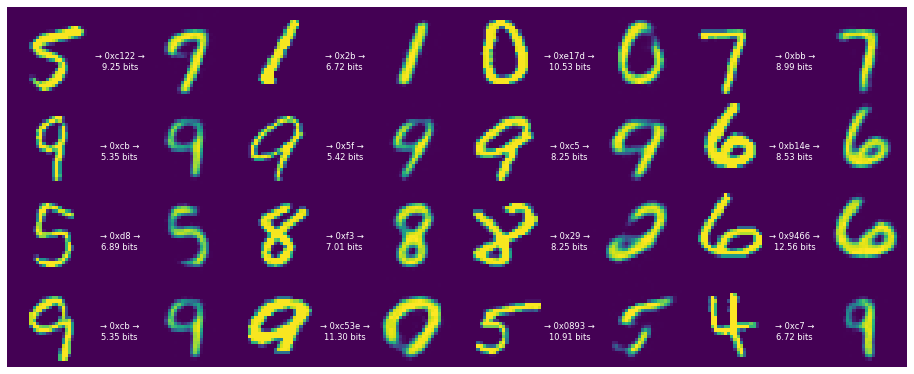

In [26]:
train_and_visualize_model(lmbda=300)


The strings begin to get much shorter now, on the order of one byte per digit. However, this comes at a cost. More digits are becoming unrecognizable.

This demonstrates that this model is agnostic to human perceptions of error, it just measures the absolute deviation in terms of pixel values. To achieve a better perceived image quality, we would need to replace the pixel loss with a perceptual loss.